In [ ]:
%%capture
%run '/content/drive/MyDrive/Federated_Learning/MNIST/NonIID/PathologicalPartition/Decentralized/MNIST_Pathological_Requirement.ipynb'

In [ ]:
def train(net, trainloader, epochs: int, verbose=False):
    """Train the network on the training set."""
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters())

    for epoch in range(epochs):
        correct, total, epoch_loss = 0, 0, 0.0
        for batch in trainloader:
            images,labels=batch["image"].to(DEVICE), batch["label"].to(DEVICE)
            if images.size(0)<=1:
                continue
            else:
                optimizer.zero_grad()
                outputs = net(images)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                epoch_loss += loss.item()
                total += labels.size(0)
                correct += (torch.max(outputs.data,1)[1]==labels).sum().item()

        if total>0:
            epoch_loss /= total
            epoch_acc = correct / total
            if verbose:
                print(f"Epoch {epoch+1}: train loss {epoch_loss}, accuracy {epoch_acc}")

In [ ]:
def test(net, testloader):
    """Evaluate the network on the entire test set."""
    criterion = torch.nn.CrossEntropyLoss()
    correct, total, loss = 0, 0, 0.0
    net.eval()
    with torch.no_grad():
        for batch in testloader:
            images, labels = batch["image"].to(DEVICE), batch["label"].to(DEVICE)
            outputs = net(images)
            loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    loss /= len(testloader.dataset)
    accuracy = correct / total
    return loss, accuracy

In [ ]:
class FlowerClient(NumPyClient):
    def __init__(self, net, trainloader, valloader):
        self.net = net
        self.trainloader = trainloader
        self.valloader = valloader

    def get_parameters(self, config):
        return get_parameters(self.net)

    def fit(self, parameters, config):
        set_parameters(self.net, parameters)
        train(self.net, self.trainloader, epochs=1)
        return get_parameters(self.net), len(self.trainloader), {}

    def evaluate(self, parameters, config):
        set_parameters(self.net, parameters)
        loss, accuracy = test(self.net, self.valloader)
        return float(loss), len(self.valloader), {"accuracy": float(accuracy)}

In [ ]:
def client_fn(context: Context) -> Client:
    """Create a Flower client representing a single organization."""
    net = Net().to(DEVICE)
    print(f"Context data: {context.__dict__}")

    partition_id = int(context.node_id) % NUM_CLIENTS if hasattr(context, 'node_id') else 0
    if hasattr(context, 'node_config') and 'partition_id' in context.node_config:
        partition_id = context.node_config['partition_id']

    print(f"Using partition_id: {partition_id}")
    trainloader, valloader, _ = load_datasets(partition_id=partition_id)
    return FlowerClient(net, trainloader, valloader).to_client()

client = ClientApp(client_fn=client_fn)

In [ ]:
def weighted_average(metrics: List[Tuple[int, Metrics]]) -> Metrics:
    accuracies = [num_examples * m["accuracy"] for num_examples, m in metrics]
    examples = [num_examples for num_examples, _ in metrics]

    return {"accuracy": sum(accuracies) / sum(examples)}

In [ ]:
test_accuracies = []

class CustomFedAvg(FedAvg):
    def aggregate_evaluate(self, server_round, results, failures):
        aggregated_result=super().aggregate_evaluate(server_round,results,failures)

        if aggregated_result is not None:
            loss,metrics=aggregated_result
            accuracy=metrics.get("accuracy",0.0)
            test_accuracies.append(accuracy)
            print(f"Round {server_round}: Test Accuracy: {accuracy:.4f}")
        return aggregated_result

In [ ]:
strategy = CustomFedAvg(
    fraction_fit=1.0,
    fraction_evaluate=0.5,
    min_fit_clients=10,
    min_evaluate_clients=5,
    min_available_clients=10,
    evaluate_metrics_aggregation_fn=weighted_average,
)

In [ ]:
def server_fn(context: Context) -> ServerAppComponents:
    config = ServerConfig(num_rounds=50)
    return ServerAppComponents(strategy=strategy, config=config)

server = ServerApp(server_fn=server_fn)

In [ ]:
backend_config = {"client_resources": {"num_cpus": 1, "num_gpus": 0.0}}

if DEVICE == "cuda":
    backend_config = {"client_resources": {"num_cpus": 1, "num_gpus": 1.0}}

In [ ]:
run_simulation(
    server_app=server,
    client_app=client,
    num_supernodes=NUM_CLIENTS,
    backend_config=backend_config,
)

DEBUG:flwr:Asyncio event loop already running.
INFO :      Starting Flower ServerApp, config: num_rounds=50, no round_timeout
INFO :      
INFO :      [INIT]
INFO :      Requesting initial parameters from one random client
(pid=1755) 2025-04-28 18:52:58.967596: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(pid=1755) WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
(pid=1755) E0000 00:00:1745866379.006108    1755 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(pid=1755) E0000 00:00:1745866379.022573    1755 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/jupyter_client/co

(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 10645475576504936861, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 1


Generating test split: 100%|██████████| 10000/10000 [00:00<00:00, 197711.17 examples/s]
(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(
INFO :      Received initial parameters from one random client
INFO :      Starting evaluation of initial global parameters
INFO :      Evaluation returned no results (`None`)
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=1755) Partition 1 size: 5987
(ClientAppActor pid=1755) Partition 1 train size: 4789
(ClientAppActor pid=1755) Partition 1 test size: 1198
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 10645475576504936861, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 1


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 1 size: 5987
(ClientAppActor pid=1755) Partition 1 train size: 4789
(ClientAppActor pid=1755) Partition 1 test size: 1198
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 2944581469879073680, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 0


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 0 size: 3020
(ClientAppActor pid=1755) Partition 0 train size: 2416
(ClientAppActor pid=1755) Partition 0 test size: 604
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 980560591126167513, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 3


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 3 size: 3781
(ClientAppActor pid=1755) Partition 3 train size: 3024
(ClientAppActor pid=1755) Partition 3 test size: 757
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 7226642581745158178, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 8
(ClientAppActor pid=1755) Partition 8 size: 3016
(ClientAppActor pid=1755) Partition 8 train size: 2412
(ClientAppActor pid=1755) Partition 8 test size: 604


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 2150608581805053540, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 0


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 0 size: 3020
(ClientAppActor pid=1755) Partition 0 train size: 2416
(ClientAppActor pid=1755) Partition 0 test size: 604
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 12156316487453098578, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 8


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 8 size: 3016
(ClientAppActor pid=1755) Partition 8 train size: 2412
(ClientAppActor pid=1755) Partition 8 test size: 604
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 11272675390493006416, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 6


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 6 size: 3965
(ClientAppActor pid=1755) Partition 6 train size: 3172
(ClientAppActor pid=1755) Partition 6 test size: 793
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 7959249247042294089, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 9


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 9 size: 2851
(ClientAppActor pid=1755) Partition 9 train size: 2280
(ClientAppActor pid=1755) Partition 9 test size: 571
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 11286993822044359192, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 2


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 2 size: 3947
(ClientAppActor pid=1755) Partition 2 train size: 3157
(ClientAppActor pid=1755) Partition 2 test size: 790
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 16312757697826071424, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 4


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 4 size: 3017
(ClientAppActor pid=1755) Partition 4 train size: 2413
(ClientAppActor pid=1755) Partition 4 test size: 604


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 7226642581745158178, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 8


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 8 size: 3016
(ClientAppActor pid=1755) Partition 8 train size: 2412
(ClientAppActor pid=1755) Partition 8 test size: 604
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 2150608581805053540, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 0


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 0 size: 3020
(ClientAppActor pid=1755) Partition 0 train size: 2416
(ClientAppActor pid=1755) Partition 0 test size: 604
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 16312757697826071424, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 4


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 4 size: 3017
(ClientAppActor pid=1755) Partition 4 train size: 2413
(ClientAppActor pid=1755) Partition 4 test size: 604
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 12156316487453098578, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 8


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 8 size: 3016
(ClientAppActor pid=1755) Partition 8 train size: 2412
(ClientAppActor pid=1755) Partition 8 test size: 604
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 11286993822044359192, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 2


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 2 size: 3947
(ClientAppActor pid=1755) Partition 2 train size: 3157
(ClientAppActor pid=1755) Partition 2 test size: 790


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 1: Test Accuracy: 0.2657
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 10645475576504936861, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 1


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 1 size: 5987
(ClientAppActor pid=1755) Partition 1 train size: 4789
(ClientAppActor pid=1755) Partition 1 test size: 1198
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 2944581469879073680, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 0


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 0 size: 3020
(ClientAppActor pid=1755) Partition 0 train size: 2416
(ClientAppActor pid=1755) Partition 0 test size: 604
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 980560591126167513, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 3


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 3 size: 3781
(ClientAppActor pid=1755) Partition 3 train size: 3024
(ClientAppActor pid=1755) Partition 3 test size: 757
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 7226642581745158178, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 8


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 8 size: 3016
(ClientAppActor pid=1755) Partition 8 train size: 2412
(ClientAppActor pid=1755) Partition 8 test size: 604
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 2150608581805053540, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 0


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 0 size: 3020
(ClientAppActor pid=1755) Partition 0 train size: 2416
(ClientAppActor pid=1755) Partition 0 test size: 604
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 11286993822044359192, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 2


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 2 size: 3947
(ClientAppActor pid=1755) Partition 2 train size: 3157
(ClientAppActor pid=1755) Partition 2 test size: 790
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 12156316487453098578, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 8
(ClientAppActor pid=1755) Partition 8 size: 3016
(ClientAppActor pid=1755) Partition 8 train size: 2412
(ClientAppActor pid=1755) Partition 8 test size: 604


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 7959249247042294089, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 9


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 9 size: 2851
(ClientAppActor pid=1755) Partition 9 train size: 2280
(ClientAppActor pid=1755) Partition 9 test size: 571
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 16312757697826071424, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 4


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 4 size: 3017
(ClientAppActor pid=1755) Partition 4 train size: 2413
(ClientAppActor pid=1755) Partition 4 test size: 604
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 11272675390493006416, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 6


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 6 size: 3965
(ClientAppActor pid=1755) Partition 6 train size: 3172
(ClientAppActor pid=1755) Partition 6 test size: 793


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 2150608581805053540, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 0


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 0 size: 3020
(ClientAppActor pid=1755) Partition 0 train size: 2416
(ClientAppActor pid=1755) Partition 0 test size: 604
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 16312757697826071424, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 4


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 4 size: 3017
(ClientAppActor pid=1755) Partition 4 train size: 2413
(ClientAppActor pid=1755) Partition 4 test size: 604
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 10645475576504936861, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 1


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 1 size: 5987
(ClientAppActor pid=1755) Partition 1 train size: 4789
(ClientAppActor pid=1755) Partition 1 test size: 1198
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 12156316487453098578, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 8


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 8 size: 3016
(ClientAppActor pid=1755) Partition 8 train size: 2412
(ClientAppActor pid=1755) Partition 8 test size: 604
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 11286993822044359192, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 2


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 2 size: 3947
(ClientAppActor pid=1755) Partition 2 train size: 3157
(ClientAppActor pid=1755) Partition 2 test size: 790


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 2: Test Accuracy: 0.7821
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 7226642581745158178, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 8


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 8 size: 3016
(ClientAppActor pid=1755) 
(ClientAppActor pid=1755) Partition 8 train size: 2412
(ClientAppActor pid=1755) Partition 8 test size: 604
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 2150608581805053540, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 0


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 0 size: 3020
(ClientAppActor pid=1755) Partition 0 train size: 2416
(ClientAppActor pid=1755) Partition 0 test size: 604
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 16312757697826071424, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 4


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 4 size: 3017
(ClientAppActor pid=1755) Partition 4 train size: 2413
(ClientAppActor pid=1755) Partition 4 test size: 604
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 7959249247042294089, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 9


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 9 size: 2851
(ClientAppActor pid=1755) Partition 9 train size: 2280
(ClientAppActor pid=1755) Partition 9 test size: 571
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 11272675390493006416, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 6


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 6 size: 3965
(ClientAppActor pid=1755) Partition 6 train size: 3172
(ClientAppActor pid=1755) Partition 6 test size: 793
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 11286993822044359192, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 2


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 2 size: 3947
(ClientAppActor pid=1755) Partition 2 train size: 3157
(ClientAppActor pid=1755) Partition 2 test size: 790
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 980560591126167513, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 3


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 3 size: 3781
(ClientAppActor pid=1755) Partition 3 train size: 3024
(ClientAppActor pid=1755) Partition 3 test size: 757
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 12156316487453098578, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 8


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 8 size: 3016
(ClientAppActor pid=1755) Partition 8 train size: 2412
(ClientAppActor pid=1755) Partition 8 test size: 604
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 2944581469879073680, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 0


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 0 size: 3020
(ClientAppActor pid=1755) Partition 0 train size: 2416
(ClientAppActor pid=1755) Partition 0 test size: 604
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 10645475576504936861, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 1


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 1 size: 5987
(ClientAppActor pid=1755) Partition 1 train size: 4789
(ClientAppActor pid=1755) Partition 1 test size: 1198


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 2944581469879073680, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 0


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 0 size: 3020
(ClientAppActor pid=1755) Partition 0 train size: 2416
(ClientAppActor pid=1755) Partition 0 test size: 604
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 980560591126167513, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 3


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 3 size: 3781
(ClientAppActor pid=1755) Partition 3 train size: 3024
(ClientAppActor pid=1755) Partition 3 test size: 757
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 2150608581805053540, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 0


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 0 size: 3020
(ClientAppActor pid=1755) Partition 0 train size: 2416
(ClientAppActor pid=1755) Partition 0 test size: 604
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 7959249247042294089, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 9


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 9 size: 2851
(ClientAppActor pid=1755) Partition 9 train size: 2280
(ClientAppActor pid=1755) Partition 9 test size: 571
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 12156316487453098578, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 8


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=1755) Partition 8 size: 3016
(ClientAppActor pid=1755) Partition 8 train size: 2412
(ClientAppActor pid=1755) Partition 8 test size: 604
Round 3: Test Accuracy: 0.7411
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 2944581469879073680, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 0


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 0 size: 3020
(ClientAppActor pid=1755) Partition 0 train size: 2416
(ClientAppActor pid=1755) Partition 0 test size: 604
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 980560591126167513, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 3


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 3 size: 3781
(ClientAppActor pid=1755) Partition 3 train size: 3024
(ClientAppActor pid=1755) Partition 3 test size: 757
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 16312757697826071424, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 4


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 4 size: 3017
(ClientAppActor pid=1755) Partition 4 train size: 2413
(ClientAppActor pid=1755) Partition 4 test size: 604
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 11272675390493006416, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 6


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 6 size: 3965
(ClientAppActor pid=1755) Partition 6 train size: 3172
(ClientAppActor pid=1755) Partition 6 test size: 793
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 12156316487453098578, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 8


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 8 size: 3016
(ClientAppActor pid=1755) Partition 8 train size: 2412
(ClientAppActor pid=1755) Partition 8 test size: 604
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 11286993822044359192, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 2


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 2 size: 3947
(ClientAppActor pid=1755) Partition 2 train size: 3157
(ClientAppActor pid=1755) Partition 2 test size: 790
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 2150608581805053540, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 0


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 0 size: 3020
(ClientAppActor pid=1755) Partition 0 train size: 2416
(ClientAppActor pid=1755) Partition 0 test size: 604
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 10645475576504936861, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 1


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 1 size: 5987
(ClientAppActor pid=1755) Partition 1 train size: 4789
(ClientAppActor pid=1755) Partition 1 test size: 1198
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 7959249247042294089, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 9


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 9 size: 2851
(ClientAppActor pid=1755) Partition 9 train size: 2280
(ClientAppActor pid=1755) Partition 9 test size: 571
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 7226642581745158178, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 8


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 8 size: 3016
(ClientAppActor pid=1755) Partition 8 train size: 2412
(ClientAppActor pid=1755) Partition 8 test size: 604


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 10645475576504936861, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 1


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 1 size: 5987
(ClientAppActor pid=1755) Partition 1 train size: 4789
(ClientAppActor pid=1755) Partition 1 test size: 1198
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 7226642581745158178, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 8
(ClientAppActor pid=1755) Partition 8 size: 3016
(ClientAppActor pid=1755) Partition 8 train size: 2412
(ClientAppActor pid=1755) Partition 8 test size: 604


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 16312757697826071424, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 4


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 4 size: 3017
(ClientAppActor pid=1755) Partition 4 train size: 2413
(ClientAppActor pid=1755) Partition 4 test size: 604
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 7959249247042294089, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 9


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 9 size: 2851
(ClientAppActor pid=1755) Partition 9 train size: 2280
(ClientAppActor pid=1755) Partition 9 test size: 571
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 12156316487453098578, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 8


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=1755) Partition 8 size: 3016
(ClientAppActor pid=1755) Partition 8 train size: 2412
(ClientAppActor pid=1755) Partition 8 test size: 604
Round 4: Test Accuracy: 0.7158
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 10645475576504936861, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 1


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 1 size: 5987
(ClientAppActor pid=1755) Partition 1 train size: 4789
(ClientAppActor pid=1755) Partition 1 test size: 1198
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 7226642581745158178, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 8
(ClientAppActor pid=1755) Partition 8 size: 3016
(ClientAppActor pid=1755) Partition 8 train size: 2412
(ClientAppActor pid=1755) Partition 8 test size: 604


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 2150608581805053540, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 0
(ClientAppActor pid=1755) Partition 0 size: 3020
(ClientAppActor pid=1755) Partition 0 train size: 2416
(ClientAppActor pid=1755) Partition 0 test size: 604


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 11272675390493006416, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 6


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 6 size: 3965
(ClientAppActor pid=1755) Partition 6 train size: 3172
(ClientAppActor pid=1755) Partition 6 test size: 793
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 12156316487453098578, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 8


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 8 size: 3016
(ClientAppActor pid=1755) Partition 8 train size: 2412
(ClientAppActor pid=1755) Partition 8 test size: 604
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 11286993822044359192, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 2


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 2 size: 3947
(ClientAppActor pid=1755) Partition 2 train size: 3157
(ClientAppActor pid=1755) Partition 2 test size: 790
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 980560591126167513, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 3


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 3 size: 3781
(ClientAppActor pid=1755) Partition 3 train size: 3024
(ClientAppActor pid=1755) Partition 3 test size: 757
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 7959249247042294089, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 9


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 9 size: 2851
(ClientAppActor pid=1755) Partition 9 train size: 2280
(ClientAppActor pid=1755) Partition 9 test size: 571
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 16312757697826071424, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 4


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 4 size: 3017
(ClientAppActor pid=1755) Partition 4 train size: 2413
(ClientAppActor pid=1755) Partition 4 test size: 604
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 2944581469879073680, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 0


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 0 size: 3020
(ClientAppActor pid=1755) Partition 0 train size: 2416
(ClientAppActor pid=1755) Partition 0 test size: 604


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 980560591126167513, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 3


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 3 size: 3781
(ClientAppActor pid=1755) Partition 3 train size: 3024
(ClientAppActor pid=1755) Partition 3 test size: 757
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 7226642581745158178, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 8


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 8 size: 3016
(ClientAppActor pid=1755) Partition 8 train size: 2412
(ClientAppActor pid=1755) Partition 8 test size: 604
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 2150608581805053540, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 0


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 0 size: 3020
(ClientAppActor pid=1755) Partition 0 train size: 2416
(ClientAppActor pid=1755) Partition 0 test size: 604
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 11272675390493006416, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 6


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 6 size: 3965
(ClientAppActor pid=1755) Partition 6 train size: 3172
(ClientAppActor pid=1755) Partition 6 test size: 793
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 11286993822044359192, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 2


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 2 size: 3947
(ClientAppActor pid=1755) Partition 2 train size: 3157
(ClientAppActor pid=1755) Partition 2 test size: 790


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 6]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 5: Test Accuracy: 0.8996
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 980560591126167513, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 3


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 3 size: 3781
(ClientAppActor pid=1755) Partition 3 train size: 3024
(ClientAppActor pid=1755) Partition 3 test size: 757
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 7226642581745158178, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 8


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 8 size: 3016
(ClientAppActor pid=1755) Partition 8 train size: 2412
(ClientAppActor pid=1755) Partition 8 test size: 604
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 2150608581805053540, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 0


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 0 size: 3020
(ClientAppActor pid=1755) Partition 0 train size: 2416
(ClientAppActor pid=1755) Partition 0 test size: 604
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 16312757697826071424, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 4


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 4 size: 3017
(ClientAppActor pid=1755) Partition 4 train size: 2413
(ClientAppActor pid=1755) Partition 4 test size: 604
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 7959249247042294089, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 9


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 9 size: 2851
(ClientAppActor pid=1755) Partition 9 train size: 2280
(ClientAppActor pid=1755) Partition 9 test size: 571
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 11286993822044359192, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 2


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 2 size: 3947
(ClientAppActor pid=1755) Partition 2 train size: 3157
(ClientAppActor pid=1755) Partition 2 test size: 790
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 10645475576504936861, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 1


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 1 size: 5987
(ClientAppActor pid=1755) Partition 1 train size: 4789
(ClientAppActor pid=1755) Partition 1 test size: 1198
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 12156316487453098578, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 8


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 8 size: 3016
(ClientAppActor pid=1755) Partition 8 train size: 2412
(ClientAppActor pid=1755) Partition 8 test size: 604
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 11272675390493006416, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 6


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 6 size: 3965
(ClientAppActor pid=1755) Partition 6 train size: 3172
(ClientAppActor pid=1755) Partition 6 test size: 793
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 2944581469879073680, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 0


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 0 size: 3020
(ClientAppActor pid=1755) Partition 0 train size: 2416
(ClientAppActor pid=1755) Partition 0 test size: 604


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 10645475576504936861, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 1


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 1 size: 5987
(ClientAppActor pid=1755) Partition 1 train size: 4789
(ClientAppActor pid=1755) Partition 1 test size: 1198
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 7226642581745158178, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 8


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 8 size: 3016
(ClientAppActor pid=1755) Partition 8 train size: 2412
(ClientAppActor pid=1755) Partition 8 test size: 604
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 7959249247042294089, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 9


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 9 size: 2851
(ClientAppActor pid=1755) Partition 9 train size: 2280
(ClientAppActor pid=1755) Partition 9 test size: 571
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 11272675390493006416, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 6


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 6 size: 3965
(ClientAppActor pid=1755) Partition 6 train size: 3172
(ClientAppActor pid=1755) Partition 6 test size: 793
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 12156316487453098578, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 8


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 8 size: 3016
(ClientAppActor pid=1755) Partition 8 train size: 2412
(ClientAppActor pid=1755) Partition 8 test size: 604


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 7]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 6: Test Accuracy: 0.8052
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 2150608581805053540, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 0


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 0 size: 3020
(ClientAppActor pid=1755) Partition 0 train size: 2416
(ClientAppActor pid=1755) Partition 0 test size: 604
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 7959249247042294089, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 9


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 9 size: 2851
(ClientAppActor pid=1755) Partition 9 train size: 2280
(ClientAppActor pid=1755) Partition 9 test size: 571
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 980560591126167513, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 3


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 3 size: 3781
(ClientAppActor pid=1755) Partition 3 train size: 3024
(ClientAppActor pid=1755) Partition 3 test size: 757
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 16312757697826071424, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 4


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 4 size: 3017
(ClientAppActor pid=1755) Partition 4 train size: 2413
(ClientAppActor pid=1755) Partition 4 test size: 604
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 11272675390493006416, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 6


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 6 size: 3965
(ClientAppActor pid=1755) Partition 6 train size: 3172
(ClientAppActor pid=1755) Partition 6 test size: 793
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 11286993822044359192, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 2


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 2 size: 3947
(ClientAppActor pid=1755) Partition 2 train size: 3157
(ClientAppActor pid=1755) Partition 2 test size: 790
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 12156316487453098578, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 8


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 8 size: 3016
(ClientAppActor pid=1755) Partition 8 train size: 2412
(ClientAppActor pid=1755) Partition 8 test size: 604
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 10645475576504936861, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 1


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 1 size: 5987
(ClientAppActor pid=1755) Partition 1 train size: 4789
(ClientAppActor pid=1755) Partition 1 test size: 1198
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 2944581469879073680, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 0


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 0 size: 3020
(ClientAppActor pid=1755) Partition 0 train size: 2416
(ClientAppActor pid=1755) Partition 0 test size: 604
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 7226642581745158178, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 8


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 8 size: 3016
(ClientAppActor pid=1755) Partition 8 train size: 2412
(ClientAppActor pid=1755) Partition 8 test size: 604


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 10645475576504936861, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 1


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 1 size: 5987
(ClientAppActor pid=1755) Partition 1 train size: 4789
(ClientAppActor pid=1755) Partition 1 test size: 1198
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 2150608581805053540, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 0


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 0 size: 3020
(ClientAppActor pid=1755) Partition 0 train size: 2416
(ClientAppActor pid=1755) Partition 0 test size: 604
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 7959249247042294089, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 9


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 9 size: 2851
(ClientAppActor pid=1755) Partition 9 train size: 2280
(ClientAppActor pid=1755) Partition 9 test size: 571
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 11272675390493006416, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 6


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 6 size: 3965
(ClientAppActor pid=1755) Partition 6 train size: 3172
(ClientAppActor pid=1755) Partition 6 test size: 793
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 12156316487453098578, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 8
(ClientAppActor pid=1755) Partition 8 size: 3016
(ClientAppActor pid=1755) Partition 8 train size: 2412
(ClientAppActor pid=1755) Partition 8 test size: 604


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 8]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 7: Test Accuracy: 0.8706
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 2944581469879073680, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 0


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 0 size: 3020
(ClientAppActor pid=1755) Partition 0 train size: 2416
(ClientAppActor pid=1755) Partition 0 test size: 604
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 980560591126167513, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 3


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 3 size: 3781
(ClientAppActor pid=1755) Partition 3 train size: 3024
(ClientAppActor pid=1755) Partition 3 test size: 757
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 7226642581745158178, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 8


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 8 size: 3016
(ClientAppActor pid=1755) Partition 8 train size: 2412
(ClientAppActor pid=1755) Partition 8 test size: 604
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 2150608581805053540, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 0


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 0 size: 3020
(ClientAppActor pid=1755) Partition 0 train size: 2416
(ClientAppActor pid=1755) Partition 0 test size: 604
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 11272675390493006416, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 6


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 6 size: 3965
(ClientAppActor pid=1755) Partition 6 train size: 3172
(ClientAppActor pid=1755) Partition 6 test size: 793
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 12156316487453098578, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 8


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 8 size: 3016
(ClientAppActor pid=1755) Partition 8 train size: 2412
(ClientAppActor pid=1755) Partition 8 test size: 604
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 7959249247042294089, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 9


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 9 size: 2851
(ClientAppActor pid=1755) Partition 9 train size: 2280
(ClientAppActor pid=1755) Partition 9 test size: 571
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 11286993822044359192, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 2


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 2 size: 3947
(ClientAppActor pid=1755) Partition 2 train size: 3157
(ClientAppActor pid=1755) Partition 2 test size: 790
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 10645475576504936861, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 1


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 1 size: 5987
(ClientAppActor pid=1755) Partition 1 train size: 4789
(ClientAppActor pid=1755) Partition 1 test size: 1198
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 16312757697826071424, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 4


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 4 size: 3017
(ClientAppActor pid=1755) Partition 4 train size: 2413
(ClientAppActor pid=1755) Partition 4 test size: 604


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 10645475576504936861, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 1


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 1 size: 5987
(ClientAppActor pid=1755) Partition 1 train size: 4789
(ClientAppActor pid=1755) Partition 1 test size: 1198
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 2944581469879073680, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 0


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 0 size: 3020
(ClientAppActor pid=1755) Partition 0 train size: 2416
(ClientAppActor pid=1755) Partition 0 test size: 604
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 16312757697826071424, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 4


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 4 size: 3017
(ClientAppActor pid=1755) Partition 4 train size: 2413
(ClientAppActor pid=1755) Partition 4 test size: 604
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 7959249247042294089, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 9


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 9 size: 2851
(ClientAppActor pid=1755) Partition 9 train size: 2280
(ClientAppActor pid=1755) Partition 9 test size: 571
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 11286993822044359192, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 2


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 2 size: 3947
(ClientAppActor pid=1755) Partition 2 train size: 3157
(ClientAppActor pid=1755) Partition 2 test size: 790


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 9]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 8: Test Accuracy: 0.8717
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 10645475576504936861, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 1


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 1 size: 5987
(ClientAppActor pid=1755) Partition 1 train size: 4789
(ClientAppActor pid=1755) Partition 1 test size: 1198
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 2944581469879073680, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 0
(ClientAppActor pid=1755) Partition 0 size: 3020
(ClientAppActor pid=1755) Partition 0 train size: 2416
(ClientAppActor pid=1755) Partition 0 test size: 604


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 7226642581745158178, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 8


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 8 size: 3016
(ClientAppActor pid=1755) Partition 8 train size: 2412
(ClientAppActor pid=1755) Partition 8 test size: 604
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 2150608581805053540, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 0


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 0 size: 3020
(ClientAppActor pid=1755) Partition 0 train size: 2416
(ClientAppActor pid=1755) Partition 0 test size: 604
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 16312757697826071424, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 4


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 4 size: 3017
(ClientAppActor pid=1755) Partition 4 train size: 2413
(ClientAppActor pid=1755) Partition 4 test size: 604
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 7959249247042294089, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 9


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 9 size: 2851
(ClientAppActor pid=1755) Partition 9 train size: 2280
(ClientAppActor pid=1755) Partition 9 test size: 571
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 12156316487453098578, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 8


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 8 size: 3016
(ClientAppActor pid=1755) Partition 8 train size: 2412
(ClientAppActor pid=1755) Partition 8 test size: 604
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 11286993822044359192, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 2


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 2 size: 3947
(ClientAppActor pid=1755) Partition 2 train size: 3157
(ClientAppActor pid=1755) Partition 2 test size: 790
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 980560591126167513, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 3


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 3 size: 3781
(ClientAppActor pid=1755) Partition 3 train size: 3024
(ClientAppActor pid=1755) Partition 3 test size: 757
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 11272675390493006416, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 6


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 6 size: 3965
(ClientAppActor pid=1755) Partition 6 train size: 3172
(ClientAppActor pid=1755) Partition 6 test size: 793


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 2944581469879073680, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 0


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 0 size: 3020
(ClientAppActor pid=1755) Partition 0 train size: 2416
(ClientAppActor pid=1755) Partition 0 test size: 604
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 980560591126167513, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 3


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 3 size: 3781
(ClientAppActor pid=1755) Partition 3 train size: 3024
(ClientAppActor pid=1755) Partition 3 test size: 757
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 2150608581805053540, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 0


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 0 size: 3020
(ClientAppActor pid=1755) Partition 0 train size: 2416
(ClientAppActor pid=1755) Partition 0 test size: 604
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 7959249247042294089, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 9


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 9 size: 2851
(ClientAppActor pid=1755) Partition 9 train size: 2280
(ClientAppActor pid=1755) Partition 9 test size: 571
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 11286993822044359192, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 2


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 2 size: 3947
(ClientAppActor pid=1755) Partition 2 train size: 3157
(ClientAppActor pid=1755) Partition 2 test size: 790


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 10]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 9: Test Accuracy: 0.8973
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 10645475576504936861, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 1


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 1 size: 5987
(ClientAppActor pid=1755) Partition 1 train size: 4789
(ClientAppActor pid=1755) Partition 1 test size: 1198
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 7226642581745158178, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 8


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 8 size: 3016
(ClientAppActor pid=1755) Partition 8 train size: 2412
(ClientAppActor pid=1755) Partition 8 test size: 604
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 16312757697826071424, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 4


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 4 size: 3017
(ClientAppActor pid=1755) Partition 4 train size: 2413
(ClientAppActor pid=1755) Partition 4 test size: 604
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 7959249247042294089, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 9


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 9 size: 2851
(ClientAppActor pid=1755) Partition 9 train size: 2280
(ClientAppActor pid=1755) Partition 9 test size: 571
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 12156316487453098578, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 8


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 8 size: 3016
(ClientAppActor pid=1755) Partition 8 train size: 2412
(ClientAppActor pid=1755) Partition 8 test size: 604
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 11286993822044359192, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 2


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 2 size: 3947
(ClientAppActor pid=1755) Partition 2 train size: 3157
(ClientAppActor pid=1755) Partition 2 test size: 790
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 2944581469879073680, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 0
(ClientAppActor pid=1755) Partition 0 size: 3020
(ClientAppActor pid=1755) Partition 0 train size: 2416
(ClientAppActor pid=1755) Partition 0 test size: 604


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 2150608581805053540, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 0


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 0 size: 3020
(ClientAppActor pid=1755) Partition 0 train size: 2416
(ClientAppActor pid=1755) Partition 0 test size: 604
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 11272675390493006416, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 6


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 6 size: 3965
(ClientAppActor pid=1755) Partition 6 train size: 3172
(ClientAppActor pid=1755) Partition 6 test size: 793
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 980560591126167513, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 3


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 3 size: 3781
(ClientAppActor pid=1755) Partition 3 train size: 3024
(ClientAppActor pid=1755) Partition 3 test size: 757


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 10645475576504936861, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 1


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 1 size: 5987
(ClientAppActor pid=1755) Partition 1 train size: 4789
(ClientAppActor pid=1755) Partition 1 test size: 1198
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 7226642581745158178, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 8


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 8 size: 3016
(ClientAppActor pid=1755) Partition 8 train size: 2412
(ClientAppActor pid=1755) Partition 8 test size: 604
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 2150608581805053540, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 0


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 0 size: 3020
(ClientAppActor pid=1755) Partition 0 train size: 2416
(ClientAppActor pid=1755) Partition 0 test size: 604
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 7959249247042294089, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 9


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 9 size: 2851
(ClientAppActor pid=1755) Partition 9 train size: 2280
(ClientAppActor pid=1755) Partition 9 test size: 571
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 12156316487453098578, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 8


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 8 size: 3016
(ClientAppActor pid=1755) Partition 8 train size: 2412
(ClientAppActor pid=1755) Partition 8 test size: 604


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 11]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 10: Test Accuracy: 0.8644
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 10645475576504936861, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 1


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 1 size: 5987
(ClientAppActor pid=1755) Partition 1 train size: 4789
(ClientAppActor pid=1755) Partition 1 test size: 1198
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 2944581469879073680, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 0
(ClientAppActor pid=1755) Partition 0 size: 3020
(ClientAppActor pid=1755) Partition 0 train size: 2416
(ClientAppActor pid=1755) Partition 0 test size: 604


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 7226642581745158178, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 8


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 8 size: 3016
(ClientAppActor pid=1755) Partition 8 train size: 2412
(ClientAppActor pid=1755) Partition 8 test size: 604
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 16312757697826071424, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 4


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 4 size: 3017
(ClientAppActor pid=1755) Partition 4 train size: 2413
(ClientAppActor pid=1755) Partition 4 test size: 604
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 11272675390493006416, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 6


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 6 size: 3965
(ClientAppActor pid=1755) Partition 6 train size: 3172
(ClientAppActor pid=1755) Partition 6 test size: 793
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 11286993822044359192, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 2


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 2 size: 3947
(ClientAppActor pid=1755) Partition 2 train size: 3157
(ClientAppActor pid=1755) Partition 2 test size: 790
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 7959249247042294089, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 9


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 9 size: 2851
(ClientAppActor pid=1755) Partition 9 train size: 2280
(ClientAppActor pid=1755) Partition 9 test size: 571
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 980560591126167513, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 3


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 3 size: 3781
(ClientAppActor pid=1755) Partition 3 train size: 3024
(ClientAppActor pid=1755) Partition 3 test size: 757
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 2150608581805053540, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 0


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 0 size: 3020
(ClientAppActor pid=1755) Partition 0 train size: 2416
(ClientAppActor pid=1755) Partition 0 test size: 604
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 12156316487453098578, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 8


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 8 size: 3016
(ClientAppActor pid=1755) Partition 8 train size: 2412
(ClientAppActor pid=1755) Partition 8 test size: 604


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 2944581469879073680, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 0


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 0 size: 3020
(ClientAppActor pid=1755) Partition 0 train size: 2416
(ClientAppActor pid=1755) Partition 0 test size: 604
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 16312757697826071424, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 4


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 4 size: 3017
(ClientAppActor pid=1755) Partition 4 train size: 2413
(ClientAppActor pid=1755) Partition 4 test size: 604
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 7959249247042294089, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 9


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 9 size: 2851
(ClientAppActor pid=1755) Partition 9 train size: 2280
(ClientAppActor pid=1755) Partition 9 test size: 571
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 11272675390493006416, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 6


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 6 size: 3965
(ClientAppActor pid=1755) Partition 6 train size: 3172
(ClientAppActor pid=1755) Partition 6 test size: 793
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 12156316487453098578, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 8
(ClientAppActor pid=1755) Partition 8 size: 3016
(ClientAppActor pid=1755) Partition 8 train size: 2412
(ClientAppActor pid=1755) Partition 8 test size: 604


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 12]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 11: Test Accuracy: 0.9366
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 10645475576504936861, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 1


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 1 size: 5987
(ClientAppActor pid=1755) Partition 1 train size: 4789
(ClientAppActor pid=1755) Partition 1 test size: 1198
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 7226642581745158178, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 8


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 8 size: 3016
(ClientAppActor pid=1755) Partition 8 train size: 2412
(ClientAppActor pid=1755) Partition 8 test size: 604
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 2150608581805053540, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 0


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 0 size: 3020
(ClientAppActor pid=1755) Partition 0 train size: 2416
(ClientAppActor pid=1755) Partition 0 test size: 604
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 11272675390493006416, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 6


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 6 size: 3965
(ClientAppActor pid=1755) Partition 6 train size: 3172
(ClientAppActor pid=1755) Partition 6 test size: 793
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 12156316487453098578, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 8


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 8 size: 3016
(ClientAppActor pid=1755) Partition 8 train size: 2412
(ClientAppActor pid=1755) Partition 8 test size: 604
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 11286993822044359192, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 2


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 2 size: 3947
(ClientAppActor pid=1755) Partition 2 train size: 3157
(ClientAppActor pid=1755) Partition 2 test size: 790
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 980560591126167513, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 3


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 3 size: 3781
(ClientAppActor pid=1755) Partition 3 train size: 3024
(ClientAppActor pid=1755) Partition 3 test size: 757
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 16312757697826071424, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 4


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 4 size: 3017
(ClientAppActor pid=1755) Partition 4 train size: 2413
(ClientAppActor pid=1755) Partition 4 test size: 604
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 7959249247042294089, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 9


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 9 size: 2851
(ClientAppActor pid=1755) Partition 9 train size: 2280
(ClientAppActor pid=1755) Partition 9 test size: 571
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 2944581469879073680, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 0


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 0 size: 3020
(ClientAppActor pid=1755) Partition 0 train size: 2416
(ClientAppActor pid=1755) Partition 0 test size: 604


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 10645475576504936861, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 1


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 1 size: 5987
(ClientAppActor pid=1755) Partition 1 train size: 4789
(ClientAppActor pid=1755) Partition 1 test size: 1198
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 2944581469879073680, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 0


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 0 size: 3020
(ClientAppActor pid=1755) Partition 0 train size: 2416
(ClientAppActor pid=1755) Partition 0 test size: 604
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 980560591126167513, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 3


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 3 size: 3781
(ClientAppActor pid=1755) Partition 3 train size: 3024
(ClientAppActor pid=1755) Partition 3 test size: 757
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 2150608581805053540, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 0


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 0 size: 3020
(ClientAppActor pid=1755) Partition 0 train size: 2416
(ClientAppActor pid=1755) Partition 0 test size: 604
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 16312757697826071424, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 4


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 13]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=1755) Partition 4 size: 3017
(ClientAppActor pid=1755) Partition 4 train size: 2413
(ClientAppActor pid=1755) Partition 4 test size: 604
Round 12: Test Accuracy: 0.8444
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 10645475576504936861, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 1


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 1 size: 5987
(ClientAppActor pid=1755) Partition 1 train size: 4789
(ClientAppActor pid=1755) Partition 1 test size: 1198
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 2944581469879073680, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 0


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 0 size: 3020
(ClientAppActor pid=1755) Partition 0 train size: 2416
(ClientAppActor pid=1755) Partition 0 test size: 604
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 980560591126167513, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 3


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 3 size: 3781
(ClientAppActor pid=1755) Partition 3 train size: 3024
(ClientAppActor pid=1755) Partition 3 test size: 757
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 7226642581745158178, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 8


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 8 size: 3016
(ClientAppActor pid=1755) Partition 8 train size: 2412
(ClientAppActor pid=1755) Partition 8 test size: 604
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 2150608581805053540, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 0


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 0 size: 3020
(ClientAppActor pid=1755) Partition 0 train size: 2416
(ClientAppActor pid=1755) Partition 0 test size: 604
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 7959249247042294089, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 9


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 9 size: 2851
(ClientAppActor pid=1755) Partition 9 train size: 2280
(ClientAppActor pid=1755) Partition 9 test size: 571
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 12156316487453098578, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 8


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 8 size: 3016
(ClientAppActor pid=1755) Partition 8 train size: 2412
(ClientAppActor pid=1755) Partition 8 test size: 604
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 16312757697826071424, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 4


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 4 size: 3017
(ClientAppActor pid=1755) Partition 4 train size: 2413
(ClientAppActor pid=1755) Partition 4 test size: 604
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 11286993822044359192, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 2


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 2 size: 3947
(ClientAppActor pid=1755) Partition 2 train size: 3157
(ClientAppActor pid=1755) Partition 2 test size: 790
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 11272675390493006416, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 6


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 6 size: 3965
(ClientAppActor pid=1755) Partition 6 train size: 3172
(ClientAppActor pid=1755) Partition 6 test size: 793


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 2944581469879073680, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 0


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 0 size: 3020
(ClientAppActor pid=1755) Partition 0 train size: 2416
(ClientAppActor pid=1755) Partition 0 test size: 604
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 980560591126167513, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 3


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 3 size: 3781
(ClientAppActor pid=1755) Partition 3 train size: 3024
(ClientAppActor pid=1755) Partition 3 test size: 757
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 16312757697826071424, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 4


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 4 size: 3017
(ClientAppActor pid=1755) Partition 4 train size: 2413
(ClientAppActor pid=1755) Partition 4 test size: 604
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 11272675390493006416, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 6


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 6 size: 3965
(ClientAppActor pid=1755) Partition 6 train size: 3172
(ClientAppActor pid=1755) Partition 6 test size: 793
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 12156316487453098578, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 8


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 8 size: 3016
(ClientAppActor pid=1755) Partition 8 train size: 2412
(ClientAppActor pid=1755) Partition 8 test size: 604


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 14]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 13: Test Accuracy: 0.9074
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 2944581469879073680, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 0


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 0 size: 3020
(ClientAppActor pid=1755) Partition 0 train size: 2416
(ClientAppActor pid=1755) Partition 0 test size: 604
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 980560591126167513, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 3


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 3 size: 3781
(ClientAppActor pid=1755) Partition 3 train size: 3024
(ClientAppActor pid=1755) Partition 3 test size: 757
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 16312757697826071424, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 4
(ClientAppActor pid=1755) Partition 4 size: 3017
(ClientAppActor pid=1755) Partition 4 train size: 2413
(ClientAppActor pid=1755) Partition 4 test size: 604


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 7959249247042294089, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 9


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 9 size: 2851
(ClientAppActor pid=1755) Partition 9 train size: 2280
(ClientAppActor pid=1755) Partition 9 test size: 571
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 11272675390493006416, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 6


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 6 size: 3965
(ClientAppActor pid=1755) Partition 6 train size: 3172
(ClientAppActor pid=1755) Partition 6 test size: 793
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 12156316487453098578, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 8


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 8 size: 3016
(ClientAppActor pid=1755) Partition 8 train size: 2412
(ClientAppActor pid=1755) Partition 8 test size: 604
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 7226642581745158178, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 8


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 8 size: 3016
(ClientAppActor pid=1755) Partition 8 train size: 2412
(ClientAppActor pid=1755) Partition 8 test size: 604
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 11286993822044359192, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 2


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 2 size: 3947
(ClientAppActor pid=1755) Partition 2 train size: 3157
(ClientAppActor pid=1755) Partition 2 test size: 790
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 10645475576504936861, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 1


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 1 size: 5987
(ClientAppActor pid=1755) Partition 1 train size: 4789
(ClientAppActor pid=1755) Partition 1 test size: 1198
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 2150608581805053540, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 0


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 0 size: 3020
(ClientAppActor pid=1755) Partition 0 train size: 2416
(ClientAppActor pid=1755) Partition 0 test size: 604


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 2944581469879073680, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 0


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 0 size: 3020
(ClientAppActor pid=1755) Partition 0 train size: 2416
(ClientAppActor pid=1755) Partition 0 test size: 604
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 2150608581805053540, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 0


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 0 size: 3020
(ClientAppActor pid=1755) Partition 0 train size: 2416
(ClientAppActor pid=1755) Partition 0 test size: 604
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 11272675390493006416, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 6


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 6 size: 3965
(ClientAppActor pid=1755) Partition 6 train size: 3172
(ClientAppActor pid=1755) Partition 6 test size: 793
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 12156316487453098578, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 8


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 8 size: 3016
(ClientAppActor pid=1755) Partition 8 train size: 2412
(ClientAppActor pid=1755) Partition 8 test size: 604
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 11286993822044359192, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 2


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 2 size: 3947
(ClientAppActor pid=1755) Partition 2 train size: 3157
(ClientAppActor pid=1755) Partition 2 test size: 790


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 15]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 14: Test Accuracy: 0.9894
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 980560591126167513, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 3


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 3 size: 3781
(ClientAppActor pid=1755) Partition 3 train size: 3024
(ClientAppActor pid=1755) Partition 3 test size: 757
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 7226642581745158178, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 8


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 8 size: 3016
(ClientAppActor pid=1755) Partition 8 train size: 2412
(ClientAppActor pid=1755) Partition 8 test size: 604
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 16312757697826071424, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 4


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 4 size: 3017
(ClientAppActor pid=1755) Partition 4 train size: 2413
(ClientAppActor pid=1755) Partition 4 test size: 604
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 7959249247042294089, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 9


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 9 size: 2851
(ClientAppActor pid=1755) Partition 9 train size: 2280
(ClientAppActor pid=1755) Partition 9 test size: 571
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 11272675390493006416, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 6


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 6 size: 3965
(ClientAppActor pid=1755) Partition 6 train size: 3172
(ClientAppActor pid=1755) Partition 6 test size: 793
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 11286993822044359192, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 2


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 2 size: 3947
(ClientAppActor pid=1755) Partition 2 train size: 3157
(ClientAppActor pid=1755) Partition 2 test size: 790
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 12156316487453098578, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 8


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 8 size: 3016
(ClientAppActor pid=1755) Partition 8 train size: 2412
(ClientAppActor pid=1755) Partition 8 test size: 604
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 2150608581805053540, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 0


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 0 size: 3020
(ClientAppActor pid=1755) Partition 0 train size: 2416
(ClientAppActor pid=1755) Partition 0 test size: 604
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 2944581469879073680, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 0


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 0 size: 3020
(ClientAppActor pid=1755) Partition 0 train size: 2416
(ClientAppActor pid=1755) Partition 0 test size: 604
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 10645475576504936861, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 1


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 1 size: 5987
(ClientAppActor pid=1755) Partition 1 train size: 4789
(ClientAppActor pid=1755) Partition 1 test size: 1198


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 2944581469879073680, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 0


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 0 size: 3020
(ClientAppActor pid=1755) Partition 0 train size: 2416
(ClientAppActor pid=1755) Partition 0 test size: 604
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 980560591126167513, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 3


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 3 size: 3781
(ClientAppActor pid=1755) Partition 3 train size: 3024
(ClientAppActor pid=1755) Partition 3 test size: 757
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 7226642581745158178, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 8


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 8 size: 3016
(ClientAppActor pid=1755) Partition 8 train size: 2412
(ClientAppActor pid=1755) Partition 8 test size: 604
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 2150608581805053540, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 0


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 0 size: 3020
(ClientAppActor pid=1755) Partition 0 train size: 2416
(ClientAppActor pid=1755) Partition 0 test size: 604
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 7959249247042294089, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 9


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 9 size: 2851
(ClientAppActor pid=1755) Partition 9 train size: 2280
(ClientAppActor pid=1755) Partition 9 test size: 571


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 16]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 15: Test Accuracy: 0.9173
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 980560591126167513, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 3


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 3 size: 3781
(ClientAppActor pid=1755) Partition 3 train size: 3024
(ClientAppActor pid=1755) Partition 3 test size: 757
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 7226642581745158178, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 8


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 8 size: 3016
(ClientAppActor pid=1755) Partition 8 train size: 2412
(ClientAppActor pid=1755) Partition 8 test size: 604
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 2150608581805053540, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 0


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 0 size: 3020
(ClientAppActor pid=1755) Partition 0 train size: 2416
(ClientAppActor pid=1755) Partition 0 test size: 604
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 16312757697826071424, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 4


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 4 size: 3017
(ClientAppActor pid=1755) Partition 4 train size: 2413
(ClientAppActor pid=1755) Partition 4 test size: 604
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 7959249247042294089, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 9


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 9 size: 2851
(ClientAppActor pid=1755) Partition 9 train size: 2280
(ClientAppActor pid=1755) Partition 9 test size: 571
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 11286993822044359192, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 2


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 2 size: 3947
(ClientAppActor pid=1755) Partition 2 train size: 3157
(ClientAppActor pid=1755) Partition 2 test size: 790
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 2944581469879073680, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 0


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 0 size: 3020
(ClientAppActor pid=1755) Partition 0 train size: 2416
(ClientAppActor pid=1755) Partition 0 test size: 604
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 10645475576504936861, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 1


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 1 size: 5987
(ClientAppActor pid=1755) Partition 1 train size: 4789
(ClientAppActor pid=1755) Partition 1 test size: 1198
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 11272675390493006416, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 6


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 6 size: 3965
(ClientAppActor pid=1755) Partition 6 train size: 3172
(ClientAppActor pid=1755) Partition 6 test size: 793
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 12156316487453098578, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 8


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 8 size: 3016
(ClientAppActor pid=1755) Partition 8 train size: 2412
(ClientAppActor pid=1755) Partition 8 test size: 604


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 10645475576504936861, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 1


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 1 size: 5987
(ClientAppActor pid=1755) Partition 1 train size: 4789
(ClientAppActor pid=1755) Partition 1 test size: 1198
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 16312757697826071424, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 4
(ClientAppActor pid=1755) Partition 4 size: 3017
(ClientAppActor pid=1755) Partition 4 train size: 2413
(ClientAppActor pid=1755) 
(ClientAppActor pid=1755) Partition 4 test size: 604


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 7959249247042294089, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 9


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 9 size: 2851
(ClientAppActor pid=1755) Partition 9 train size: 2280
(ClientAppActor pid=1755) Partition 9 test size: 571
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 11272675390493006416, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 6


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 6 size: 3965
(ClientAppActor pid=1755) Partition 6 train size: 3172
(ClientAppActor pid=1755) Partition 6 test size: 793
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 12156316487453098578, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 8


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 8 size: 3016
(ClientAppActor pid=1755) Partition 8 train size: 2412
(ClientAppActor pid=1755) Partition 8 test size: 604


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 17]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 16: Test Accuracy: 0.8858
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 10645475576504936861, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 1


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 1 size: 5987
(ClientAppActor pid=1755) Partition 1 train size: 4789
(ClientAppActor pid=1755) Partition 1 test size: 1198
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 2150608581805053540, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 0


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 0 size: 3020
(ClientAppActor pid=1755) Partition 0 train size: 2416
(ClientAppActor pid=1755) Partition 0 test size: 604
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 16312757697826071424, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 4


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 4 size: 3017
(ClientAppActor pid=1755) Partition 4 train size: 2413
(ClientAppActor pid=1755) Partition 4 test size: 604
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 7959249247042294089, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 9


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 9 size: 2851
(ClientAppActor pid=1755) Partition 9 train size: 2280
(ClientAppActor pid=1755) Partition 9 test size: 571
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 12156316487453098578, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 8


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 8 size: 3016
(ClientAppActor pid=1755) Partition 8 train size: 2412
(ClientAppActor pid=1755) Partition 8 test size: 604
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 11286993822044359192, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 2


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 2 size: 3947
(ClientAppActor pid=1755) Partition 2 train size: 3157
(ClientAppActor pid=1755) Partition 2 test size: 790
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 2944581469879073680, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 0


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 0 size: 3020
(ClientAppActor pid=1755) Partition 0 train size: 2416
(ClientAppActor pid=1755) Partition 0 test size: 604
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 7226642581745158178, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 8


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 8 size: 3016
(ClientAppActor pid=1755) Partition 8 train size: 2412
(ClientAppActor pid=1755) Partition 8 test size: 604
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 980560591126167513, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 3


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 3 size: 3781
(ClientAppActor pid=1755) Partition 3 train size: 3024
(ClientAppActor pid=1755) Partition 3 test size: 757
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 11272675390493006416, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 6


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 6 size: 3965
(ClientAppActor pid=1755) Partition 6 train size: 3172
(ClientAppActor pid=1755) Partition 6 test size: 793


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 10645475576504936861, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 1


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 1 size: 5987
(ClientAppActor pid=1755) Partition 1 train size: 4789
(ClientAppActor pid=1755) Partition 1 test size: 1198
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 980560591126167513, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 3


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 3 size: 3781
(ClientAppActor pid=1755) Partition 3 train size: 3024
(ClientAppActor pid=1755) Partition 3 test size: 757
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 16312757697826071424, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 4


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 4 size: 3017
(ClientAppActor pid=1755) Partition 4 train size: 2413
(ClientAppActor pid=1755) Partition 4 test size: 604
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 11272675390493006416, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 6


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 6 size: 3965
(ClientAppActor pid=1755) Partition 6 train size: 3172
(ClientAppActor pid=1755) Partition 6 test size: 793
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 12156316487453098578, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 8


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 18]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=1755) Partition 8 size: 3016
(ClientAppActor pid=1755) Partition 8 train size: 2412
(ClientAppActor pid=1755) Partition 8 test size: 604
Round 17: Test Accuracy: 0.9069
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 2944581469879073680, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 0


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 0 size: 3020
(ClientAppActor pid=1755) Partition 0 train size: 2416
(ClientAppActor pid=1755) Partition 0 test size: 604
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 980560591126167513, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 3


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 3 size: 3781
(ClientAppActor pid=1755) Partition 3 train size: 3024
(ClientAppActor pid=1755) Partition 3 test size: 757
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 2150608581805053540, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 0


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 0 size: 3020
(ClientAppActor pid=1755) Partition 0 train size: 2416
(ClientAppActor pid=1755) Partition 0 test size: 604
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 7959249247042294089, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 9


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 9 size: 2851
(ClientAppActor pid=1755) Partition 9 train size: 2280
(ClientAppActor pid=1755) Partition 9 test size: 571
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 11272675390493006416, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 6


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 6 size: 3965
(ClientAppActor pid=1755) Partition 6 train size: 3172
(ClientAppActor pid=1755) Partition 6 test size: 793
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 11286993822044359192, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 2


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 2 size: 3947
(ClientAppActor pid=1755) Partition 2 train size: 3157
(ClientAppActor pid=1755) Partition 2 test size: 790
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 12156316487453098578, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 8


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 8 size: 3016
(ClientAppActor pid=1755) Partition 8 train size: 2412
(ClientAppActor pid=1755) Partition 8 test size: 604
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 16312757697826071424, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 4


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 4 size: 3017
(ClientAppActor pid=1755) Partition 4 train size: 2413
(ClientAppActor pid=1755) Partition 4 test size: 604
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 7226642581745158178, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 8


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 8 size: 3016
(ClientAppActor pid=1755) Partition 8 train size: 2412
(ClientAppActor pid=1755) Partition 8 test size: 604
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 10645475576504936861, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 1


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 1 size: 5987
(ClientAppActor pid=1755) Partition 1 train size: 4789
(ClientAppActor pid=1755) Partition 1 test size: 1198


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 10645475576504936861, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 1


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 1 size: 5987
(ClientAppActor pid=1755) Partition 1 train size: 4789
(ClientAppActor pid=1755) Partition 1 test size: 1198
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 7226642581745158178, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 8


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 8 size: 3016
(ClientAppActor pid=1755) Partition 8 train size: 2412
(ClientAppActor pid=1755) Partition 8 test size: 604
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 7959249247042294089, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 9


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 9 size: 2851
(ClientAppActor pid=1755) Partition 9 train size: 2280
(ClientAppActor pid=1755) Partition 9 test size: 571
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 11272675390493006416, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 6


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 6 size: 3965
(ClientAppActor pid=1755) Partition 6 train size: 3172
(ClientAppActor pid=1755) Partition 6 test size: 793
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 11286993822044359192, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 2


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 2 size: 3947
(ClientAppActor pid=1755) Partition 2 train size: 3157
(ClientAppActor pid=1755) Partition 2 test size: 790


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 19]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 18: Test Accuracy: 0.9069
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 980560591126167513, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 3


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 3 size: 3781
(ClientAppActor pid=1755) Partition 3 train size: 3024
(ClientAppActor pid=1755) Partition 3 test size: 757
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 2150608581805053540, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 0


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 0 size: 3020
(ClientAppActor pid=1755) Partition 0 train size: 2416
(ClientAppActor pid=1755) Partition 0 test size: 604
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 7959249247042294089, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 9
(ClientAppActor pid=1755) Partition 9 size: 2851
(ClientAppActor pid=1755) Partition 9 train size: 2280
(ClientAppActor pid=1755) Partition 9 test size: 571


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 11272675390493006416, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 6


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 6 size: 3965
(ClientAppActor pid=1755) Partition 6 train size: 3172
(ClientAppActor pid=1755) Partition 6 test size: 793
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 12156316487453098578, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 8
(ClientAppActor pid=1755) Partition 8 size: 3016
(ClientAppActor pid=1755) Partition 8 train size: 2412
(ClientAppActor pid=1755) Partition 8 test size: 604


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 11286993822044359192, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 2


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 2 size: 3947
(ClientAppActor pid=1755) Partition 2 train size: 3157
(ClientAppActor pid=1755) Partition 2 test size: 790
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 2944581469879073680, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 0


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 0 size: 3020
(ClientAppActor pid=1755) Partition 0 train size: 2416
(ClientAppActor pid=1755) Partition 0 test size: 604
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 16312757697826071424, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 4


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 4 size: 3017
(ClientAppActor pid=1755) Partition 4 train size: 2413
(ClientAppActor pid=1755) Partition 4 test size: 604
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 10645475576504936861, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 1


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 1 size: 5987
(ClientAppActor pid=1755) Partition 1 train size: 4789
(ClientAppActor pid=1755) Partition 1 test size: 1198
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 7226642581745158178, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 8
(ClientAppActor pid=1755) Partition 8 size: 3016
(ClientAppActor pid=1755) Partition 8 train size: 2412
(ClientAppActor pid=1755) Partition 8 test size: 604


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(
INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 10645475576504936861, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 1


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 1 size: 5987
(ClientAppActor pid=1755) Partition 1 train size: 4789
(ClientAppActor pid=1755) Partition 1 test size: 1198
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 7226642581745158178, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 8


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 8 size: 3016
(ClientAppActor pid=1755) Partition 8 train size: 2412
(ClientAppActor pid=1755) Partition 8 test size: 604
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 16312757697826071424, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 4


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 4 size: 3017
(ClientAppActor pid=1755) Partition 4 train size: 2413
(ClientAppActor pid=1755) Partition 4 test size: 604
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 7959249247042294089, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 9


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 9 size: 2851
(ClientAppActor pid=1755) Partition 9 train size: 2280
(ClientAppActor pid=1755) Partition 9 test size: 571
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 11286993822044359192, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 2


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 2 size: 3947
(ClientAppActor pid=1755) Partition 2 train size: 3157
(ClientAppActor pid=1755) Partition 2 test size: 790


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 20]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 19: Test Accuracy: 0.9021
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 10645475576504936861, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 1


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 1 size: 5987
(ClientAppActor pid=1755) Partition 1 train size: 4789
(ClientAppActor pid=1755) Partition 1 test size: 1198
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 980560591126167513, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 3


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 3 size: 3781
(ClientAppActor pid=1755) Partition 3 train size: 3024
(ClientAppActor pid=1755) Partition 3 test size: 757
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 2150608581805053540, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 0


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 0 size: 3020
(ClientAppActor pid=1755) Partition 0 train size: 2416
(ClientAppActor pid=1755) Partition 0 test size: 604
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 16312757697826071424, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 4


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 4 size: 3017
(ClientAppActor pid=1755) Partition 4 train size: 2413
(ClientAppActor pid=1755) Partition 4 test size: 604
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 7959249247042294089, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 9


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 9 size: 2851
(ClientAppActor pid=1755) Partition 9 train size: 2280
(ClientAppActor pid=1755) Partition 9 test size: 571
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 11272675390493006416, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 6


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 6 size: 3965
(ClientAppActor pid=1755) Partition 6 train size: 3172
(ClientAppActor pid=1755) Partition 6 test size: 793
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 12156316487453098578, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 8


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 8 size: 3016
(ClientAppActor pid=1755) Partition 8 train size: 2412
(ClientAppActor pid=1755) Partition 8 test size: 604
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 2944581469879073680, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 0


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 0 size: 3020
(ClientAppActor pid=1755) Partition 0 train size: 2416
(ClientAppActor pid=1755) Partition 0 test size: 604
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 7226642581745158178, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 8


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 8 size: 3016
(ClientAppActor pid=1755) Partition 8 train size: 2412
(ClientAppActor pid=1755) Partition 8 test size: 604
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 11286993822044359192, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 2


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 2 size: 3947
(ClientAppActor pid=1755) Partition 2 train size: 3157
(ClientAppActor pid=1755) Partition 2 test size: 790


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 7226642581745158178, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 8


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 8 size: 3016
(ClientAppActor pid=1755) Partition 8 train size: 2412
(ClientAppActor pid=1755) Partition 8 test size: 604
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 2150608581805053540, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 0


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 0 size: 3020
(ClientAppActor pid=1755) Partition 0 train size: 2416
(ClientAppActor pid=1755) Partition 0 test size: 604
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 16312757697826071424, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 4


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 4 size: 3017
(ClientAppActor pid=1755) Partition 4 train size: 2413
(ClientAppActor pid=1755) Partition 4 test size: 604
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 12156316487453098578, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 8


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 8 size: 3016
(ClientAppActor pid=1755) Partition 8 train size: 2412
(ClientAppActor pid=1755) Partition 8 test size: 604
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 11286993822044359192, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 2


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 2 size: 3947
(ClientAppActor pid=1755) Partition 2 train size: 3157
(ClientAppActor pid=1755) Partition 2 test size: 790


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 21]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 20: Test Accuracy: 0.9950
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 10645475576504936861, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 1


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 1 size: 5987
(ClientAppActor pid=1755) Partition 1 train size: 4789
(ClientAppActor pid=1755) Partition 1 test size: 1198
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 2944581469879073680, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 0


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 0 size: 3020
(ClientAppActor pid=1755) Partition 0 train size: 2416
(ClientAppActor pid=1755) Partition 0 test size: 604
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 2150608581805053540, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 0


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 0 size: 3020
(ClientAppActor pid=1755) Partition 0 train size: 2416
(ClientAppActor pid=1755) Partition 0 test size: 604
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 16312757697826071424, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 4


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 4 size: 3017
(ClientAppActor pid=1755) Partition 4 train size: 2413
(ClientAppActor pid=1755) Partition 4 test size: 604
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 7959249247042294089, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 9


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 9 size: 2851
(ClientAppActor pid=1755) Partition 9 train size: 2280
(ClientAppActor pid=1755) Partition 9 test size: 571
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 11272675390493006416, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 6


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 6 size: 3965
(ClientAppActor pid=1755) Partition 6 train size: 3172
(ClientAppActor pid=1755) Partition 6 test size: 793
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 980560591126167513, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 3


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 3 size: 3781
(ClientAppActor pid=1755) Partition 3 train size: 3024
(ClientAppActor pid=1755) Partition 3 test size: 757
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 7226642581745158178, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 8


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 8 size: 3016
(ClientAppActor pid=1755) Partition 8 train size: 2412
(ClientAppActor pid=1755) Partition 8 test size: 604
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 12156316487453098578, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 8


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 8 size: 3016
(ClientAppActor pid=1755) Partition 8 train size: 2412
(ClientAppActor pid=1755) Partition 8 test size: 604
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 11286993822044359192, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 2


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 2 size: 3947
(ClientAppActor pid=1755) Partition 2 train size: 3157
(ClientAppActor pid=1755) Partition 2 test size: 790


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 980560591126167513, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 3


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 3 size: 3781
(ClientAppActor pid=1755) Partition 3 train size: 3024
(ClientAppActor pid=1755) Partition 3 test size: 757
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 7226642581745158178, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 8


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 8 size: 3016
(ClientAppActor pid=1755) Partition 8 train size: 2412
(ClientAppActor pid=1755) Partition 8 test size: 604
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 2150608581805053540, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 0


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 0 size: 3020
(ClientAppActor pid=1755) Partition 0 train size: 2416
(ClientAppActor pid=1755) Partition 0 test size: 604
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 16312757697826071424, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 4


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 4 size: 3017
(ClientAppActor pid=1755) Partition 4 train size: 2413
(ClientAppActor pid=1755) Partition 4 test size: 604
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 12156316487453098578, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 8


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 22]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=1755) Partition 8 size: 3016
(ClientAppActor pid=1755) Partition 8 train size: 2412
(ClientAppActor pid=1755) Partition 8 test size: 604
Round 21: Test Accuracy: 0.9426
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 10645475576504936861, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 1


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 1 size: 5987
(ClientAppActor pid=1755) Partition 1 train size: 4789
(ClientAppActor pid=1755) Partition 1 test size: 1198
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 2150608581805053540, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 0


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 0 size: 3020
(ClientAppActor pid=1755) Partition 0 train size: 2416
(ClientAppActor pid=1755) Partition 0 test size: 604
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 16312757697826071424, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 4


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 4 size: 3017
(ClientAppActor pid=1755) Partition 4 train size: 2413
(ClientAppActor pid=1755) Partition 4 test size: 604
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 7959249247042294089, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 9


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 9 size: 2851
(ClientAppActor pid=1755) Partition 9 train size: 2280
(ClientAppActor pid=1755) Partition 9 test size: 571
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 12156316487453098578, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 8


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 8 size: 3016
(ClientAppActor pid=1755) Partition 8 train size: 2412
(ClientAppActor pid=1755) Partition 8 test size: 604
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 11286993822044359192, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 2


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 2 size: 3947
(ClientAppActor pid=1755) Partition 2 train size: 3157
(ClientAppActor pid=1755) Partition 2 test size: 790
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 7226642581745158178, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 8


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 8 size: 3016
(ClientAppActor pid=1755) Partition 8 train size: 2412
(ClientAppActor pid=1755) Partition 8 test size: 604
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 2944581469879073680, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 0


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 0 size: 3020
(ClientAppActor pid=1755) Partition 0 train size: 2416
(ClientAppActor pid=1755) Partition 0 test size: 604
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 980560591126167513, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 3


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 3 size: 3781
(ClientAppActor pid=1755) Partition 3 train size: 3024
(ClientAppActor pid=1755) Partition 3 test size: 757
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 11272675390493006416, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 6


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 6 size: 3965
(ClientAppActor pid=1755) Partition 6 train size: 3172
(ClientAppActor pid=1755) Partition 6 test size: 793


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 10645475576504936861, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 1


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 1 size: 5987
(ClientAppActor pid=1755) Partition 1 train size: 4789
(ClientAppActor pid=1755) Partition 1 test size: 1198
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 7226642581745158178, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 8


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 8 size: 3016
(ClientAppActor pid=1755) Partition 8 train size: 2412
(ClientAppActor pid=1755) Partition 8 test size: 604
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 16312757697826071424, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 4


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 4 size: 3017
(ClientAppActor pid=1755) Partition 4 train size: 2413
(ClientAppActor pid=1755) Partition 4 test size: 604
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 7959249247042294089, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 9


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 9 size: 2851
(ClientAppActor pid=1755) Partition 9 train size: 2280
(ClientAppActor pid=1755) Partition 9 test size: 571
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 11272675390493006416, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 6


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 6 size: 3965
(ClientAppActor pid=1755) Partition 6 train size: 3172
(ClientAppActor pid=1755) Partition 6 test size: 793


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 23]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 22: Test Accuracy: 0.8608
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 980560591126167513, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 3


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 3 size: 3781
(ClientAppActor pid=1755) Partition 3 train size: 3024
(ClientAppActor pid=1755) Partition 3 test size: 757
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 7226642581745158178, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 8


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 8 size: 3016
(ClientAppActor pid=1755) Partition 8 train size: 2412
(ClientAppActor pid=1755) Partition 8 test size: 604
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 2150608581805053540, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 0


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 0 size: 3020
(ClientAppActor pid=1755) Partition 0 train size: 2416
(ClientAppActor pid=1755) Partition 0 test size: 604
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 7959249247042294089, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 9


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 9 size: 2851
(ClientAppActor pid=1755) Partition 9 train size: 2280
(ClientAppActor pid=1755) Partition 9 test size: 571
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 11272675390493006416, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 6


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 6 size: 3965
(ClientAppActor pid=1755) Partition 6 train size: 3172
(ClientAppActor pid=1755) Partition 6 test size: 793
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 12156316487453098578, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 8


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 8 size: 3016
(ClientAppActor pid=1755) Partition 8 train size: 2412
(ClientAppActor pid=1755) Partition 8 test size: 604
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 16312757697826071424, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 4


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 4 size: 3017
(ClientAppActor pid=1755) Partition 4 train size: 2413
(ClientAppActor pid=1755) Partition 4 test size: 604
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 10645475576504936861, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 1


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 1 size: 5987
(ClientAppActor pid=1755) Partition 1 train size: 4789
(ClientAppActor pid=1755) Partition 1 test size: 1198
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 11286993822044359192, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 2


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 2 size: 3947
(ClientAppActor pid=1755) Partition 2 train size: 3157
(ClientAppActor pid=1755) Partition 2 test size: 790
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 2944581469879073680, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 0


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 0 size: 3020
(ClientAppActor pid=1755) Partition 0 train size: 2416
(ClientAppActor pid=1755) Partition 0 test size: 604


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 2944581469879073680, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 0


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 0 size: 3020
(ClientAppActor pid=1755) Partition 0 train size: 2416
(ClientAppActor pid=1755) Partition 0 test size: 604
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 7226642581745158178, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 8


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 8 size: 3016
(ClientAppActor pid=1755) Partition 8 train size: 2412
(ClientAppActor pid=1755) Partition 8 test size: 604
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 7959249247042294089, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 9


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 9 size: 2851
(ClientAppActor pid=1755) Partition 9 train size: 2280
(ClientAppActor pid=1755) Partition 9 test size: 571
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 11272675390493006416, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 6


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 6 size: 3965
(ClientAppActor pid=1755) Partition 6 train size: 3172
(ClientAppActor pid=1755) Partition 6 test size: 793
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 11286993822044359192, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 2


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 2 size: 3947
(ClientAppActor pid=1755) Partition 2 train size: 3157
(ClientAppActor pid=1755) Partition 2 test size: 790


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 24]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 23: Test Accuracy: 0.9358
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 10645475576504936861, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 1


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 1 size: 5987
(ClientAppActor pid=1755) Partition 1 train size: 4789
(ClientAppActor pid=1755) Partition 1 test size: 1198
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 980560591126167513, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 3


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 3 size: 3781
(ClientAppActor pid=1755) Partition 3 train size: 3024
(ClientAppActor pid=1755) Partition 3 test size: 757
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 2150608581805053540, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 0


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 0 size: 3020
(ClientAppActor pid=1755) Partition 0 train size: 2416
(ClientAppActor pid=1755) Partition 0 test size: 604
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 11272675390493006416, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 6


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 6 size: 3965
(ClientAppActor pid=1755) Partition 6 train size: 3172
(ClientAppActor pid=1755) Partition 6 test size: 793
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 12156316487453098578, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 8


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 8 size: 3016
(ClientAppActor pid=1755) Partition 8 train size: 2412
(ClientAppActor pid=1755) Partition 8 test size: 604
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 11286993822044359192, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 2


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 2 size: 3947
(ClientAppActor pid=1755) Partition 2 train size: 3157
(ClientAppActor pid=1755) Partition 2 test size: 790
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 7226642581745158178, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 8


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 8 size: 3016
(ClientAppActor pid=1755) Partition 8 train size: 2412
(ClientAppActor pid=1755) Partition 8 test size: 604
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 2944581469879073680, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 0


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 0 size: 3020
(ClientAppActor pid=1755) Partition 0 train size: 2416
(ClientAppActor pid=1755) Partition 0 test size: 604
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 7959249247042294089, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 9


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 9 size: 2851
(ClientAppActor pid=1755) Partition 9 train size: 2280
(ClientAppActor pid=1755) Partition 9 test size: 571
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 16312757697826071424, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 4


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 4 size: 3017
(ClientAppActor pid=1755) Partition 4 train size: 2413
(ClientAppActor pid=1755) Partition 4 test size: 604


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 10645475576504936861, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 1


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 1 size: 5987
(ClientAppActor pid=1755) Partition 1 train size: 4789
(ClientAppActor pid=1755) Partition 1 test size: 1198
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 2944581469879073680, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 0


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 0 size: 3020
(ClientAppActor pid=1755) Partition 0 train size: 2416
(ClientAppActor pid=1755) Partition 0 test size: 604
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 7226642581745158178, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 8


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 8 size: 3016
(ClientAppActor pid=1755) Partition 8 train size: 2412
(ClientAppActor pid=1755) Partition 8 test size: 604
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 12156316487453098578, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 8


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 8 size: 3016
(ClientAppActor pid=1755) Partition 8 train size: 2412
(ClientAppActor pid=1755) Partition 8 test size: 604
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 11286993822044359192, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 2


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 2 size: 3947
(ClientAppActor pid=1755) Partition 2 train size: 3157
(ClientAppActor pid=1755) Partition 2 test size: 790


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 25]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 24: Test Accuracy: 0.9107
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 980560591126167513, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 3


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 3 size: 3781
(ClientAppActor pid=1755) Partition 3 train size: 3024
(ClientAppActor pid=1755) Partition 3 test size: 757
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 2150608581805053540, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 0


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 0 size: 3020
(ClientAppActor pid=1755) Partition 0 train size: 2416
(ClientAppActor pid=1755) Partition 0 test size: 604
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 7959249247042294089, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 9


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 9 size: 2851
(ClientAppActor pid=1755) Partition 9 train size: 2280
(ClientAppActor pid=1755) Partition 9 test size: 571
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 11272675390493006416, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 6


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 6 size: 3965
(ClientAppActor pid=1755) Partition 6 train size: 3172
(ClientAppActor pid=1755) Partition 6 test size: 793
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 12156316487453098578, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 8


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 8 size: 3016
(ClientAppActor pid=1755) Partition 8 train size: 2412
(ClientAppActor pid=1755) Partition 8 test size: 604
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 11286993822044359192, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 2


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 2 size: 3947
(ClientAppActor pid=1755) Partition 2 train size: 3157
(ClientAppActor pid=1755) Partition 2 test size: 790
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 7226642581745158178, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 8


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 8 size: 3016
(ClientAppActor pid=1755) Partition 8 train size: 2412
(ClientAppActor pid=1755) Partition 8 test size: 604
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 2944581469879073680, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 0


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 0 size: 3020
(ClientAppActor pid=1755) Partition 0 train size: 2416
(ClientAppActor pid=1755) Partition 0 test size: 604
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 10645475576504936861, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 1


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 1 size: 5987
(ClientAppActor pid=1755) Partition 1 train size: 4789
(ClientAppActor pid=1755) Partition 1 test size: 1198
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 16312757697826071424, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 4


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 4 size: 3017
(ClientAppActor pid=1755) Partition 4 train size: 2413
(ClientAppActor pid=1755) Partition 4 test size: 604


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 10645475576504936861, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 1


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 1 size: 5987
(ClientAppActor pid=1755) Partition 1 train size: 4789
(ClientAppActor pid=1755) Partition 1 test size: 1198
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 2944581469879073680, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 0


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 0 size: 3020
(ClientAppActor pid=1755) Partition 0 train size: 2416
(ClientAppActor pid=1755) Partition 0 test size: 604
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 7226642581745158178, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 8
(ClientAppActor pid=1755) Partition 8 size: 3016
(ClientAppActor pid=1755) Partition 8 train size: 2412
(ClientAppActor pid=1755) Partition 8 test size: 604


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 11272675390493006416, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 6


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 6 size: 3965
(ClientAppActor pid=1755) Partition 6 train size: 3172
(ClientAppActor pid=1755) Partition 6 test size: 793
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 11286993822044359192, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 2


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 2 size: 3947
(ClientAppActor pid=1755) Partition 2 train size: 3157
(ClientAppActor pid=1755) Partition 2 test size: 790


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 26]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 25: Test Accuracy: 0.9157
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 10645475576504936861, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 1


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 1 size: 5987
(ClientAppActor pid=1755) Partition 1 train size: 4789
(ClientAppActor pid=1755) Partition 1 test size: 1198
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 2944581469879073680, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 0


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 0 size: 3020
(ClientAppActor pid=1755) Partition 0 train size: 2416
(ClientAppActor pid=1755) Partition 0 test size: 604
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 980560591126167513, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 3


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 3 size: 3781
(ClientAppActor pid=1755) Partition 3 train size: 3024
(ClientAppActor pid=1755) Partition 3 test size: 757
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 7226642581745158178, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 8


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 8 size: 3016
(ClientAppActor pid=1755) Partition 8 train size: 2412
(ClientAppActor pid=1755) Partition 8 test size: 604
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 16312757697826071424, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 4


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 4 size: 3017
(ClientAppActor pid=1755) Partition 4 train size: 2413
(ClientAppActor pid=1755) Partition 4 test size: 604
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 7959249247042294089, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 9


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 9 size: 2851
(ClientAppActor pid=1755) Partition 9 train size: 2280
(ClientAppActor pid=1755) Partition 9 test size: 571
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 11286993822044359192, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 2


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 2 size: 3947
(ClientAppActor pid=1755) Partition 2 train size: 3157
(ClientAppActor pid=1755) Partition 2 test size: 790
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 11272675390493006416, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 6


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 6 size: 3965
(ClientAppActor pid=1755) Partition 6 train size: 3172
(ClientAppActor pid=1755) Partition 6 test size: 793
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 12156316487453098578, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 8


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 8 size: 3016
(ClientAppActor pid=1755) Partition 8 train size: 2412
(ClientAppActor pid=1755) Partition 8 test size: 604
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 2150608581805053540, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 0
(ClientAppActor pid=1755) Partition 0 size: 3020
(ClientAppActor pid=1755) Partition 0 train size: 2416
(ClientAppActor pid=1755) Partition 0 test size: 604


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(
INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 10645475576504936861, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 1


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 1 size: 5987
(ClientAppActor pid=1755) Partition 1 train size: 4789
(ClientAppActor pid=1755) Partition 1 test size: 1198
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 980560591126167513, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 3


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 3 size: 3781
(ClientAppActor pid=1755) Partition 3 train size: 3024
(ClientAppActor pid=1755) Partition 3 test size: 757
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 2150608581805053540, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 0
(ClientAppActor pid=1755) Partition 0 size: 3020
(ClientAppActor pid=1755) Partition 0 train size: 2416
(ClientAppActor pid=1755) Partition 0 test size: 604


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 16312757697826071424, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 4


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 4 size: 3017
(ClientAppActor pid=1755) Partition 4 train size: 2413
(ClientAppActor pid=1755) Partition 4 test size: 604
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 11286993822044359192, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 2


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 2 size: 3947
(ClientAppActor pid=1755) Partition 2 train size: 3157
(ClientAppActor pid=1755) Partition 2 test size: 790


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 27]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 26: Test Accuracy: 0.9155
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 10645475576504936861, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 1


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 1 size: 5987
(ClientAppActor pid=1755) Partition 1 train size: 4789
(ClientAppActor pid=1755) Partition 1 test size: 1198
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 2944581469879073680, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 0


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 0 size: 3020
(ClientAppActor pid=1755) Partition 0 train size: 2416
(ClientAppActor pid=1755) Partition 0 test size: 604
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 980560591126167513, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 3


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 3 size: 3781
(ClientAppActor pid=1755) Partition 3 train size: 3024
(ClientAppActor pid=1755) Partition 3 test size: 757
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 7226642581745158178, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 8


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 8 size: 3016
(ClientAppActor pid=1755) Partition 8 train size: 2412
(ClientAppActor pid=1755) Partition 8 test size: 604
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 7959249247042294089, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 9


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 9 size: 2851
(ClientAppActor pid=1755) Partition 9 train size: 2280
(ClientAppActor pid=1755) Partition 9 test size: 571
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 12156316487453098578, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 8


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 8 size: 3016
(ClientAppActor pid=1755) Partition 8 train size: 2412
(ClientAppActor pid=1755) Partition 8 test size: 604
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 11286993822044359192, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 2


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 2 size: 3947
(ClientAppActor pid=1755) Partition 2 train size: 3157
(ClientAppActor pid=1755) Partition 2 test size: 790
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 11272675390493006416, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 6


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 6 size: 3965
(ClientAppActor pid=1755) Partition 6 train size: 3172
(ClientAppActor pid=1755) Partition 6 test size: 793
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 2150608581805053540, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 0


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 0 size: 3020
(ClientAppActor pid=1755) Partition 0 train size: 2416
(ClientAppActor pid=1755) Partition 0 test size: 604
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 16312757697826071424, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 4


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 4 size: 3017
(ClientAppActor pid=1755) Partition 4 train size: 2413
(ClientAppActor pid=1755) Partition 4 test size: 604


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 10645475576504936861, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 1


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 1 size: 5987
(ClientAppActor pid=1755) Partition 1 train size: 4789
(ClientAppActor pid=1755) Partition 1 test size: 1198
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 2944581469879073680, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 0


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 0 size: 3020
(ClientAppActor pid=1755) Partition 0 train size: 2416
(ClientAppActor pid=1755) Partition 0 test size: 604
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 2150608581805053540, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 0


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 0 size: 3020
(ClientAppActor pid=1755) Partition 0 train size: 2416
(ClientAppActor pid=1755) Partition 0 test size: 604
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 16312757697826071424, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 4


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 4 size: 3017
(ClientAppActor pid=1755) Partition 4 train size: 2413
(ClientAppActor pid=1755) Partition 4 test size: 604
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 7959249247042294089, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 9


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 9 size: 2851
(ClientAppActor pid=1755) Partition 9 train size: 2280
(ClientAppActor pid=1755) Partition 9 test size: 571


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 28]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 27: Test Accuracy: 0.8999
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 10645475576504936861, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 1


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 1 size: 5987
(ClientAppActor pid=1755) Partition 1 train size: 4789
(ClientAppActor pid=1755) Partition 1 test size: 1198
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 980560591126167513, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 3


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 3 size: 3781
(ClientAppActor pid=1755) Partition 3 train size: 3024
(ClientAppActor pid=1755) Partition 3 test size: 757
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 7226642581745158178, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 8


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 8 size: 3016
(ClientAppActor pid=1755) Partition 8 train size: 2412
(ClientAppActor pid=1755) Partition 8 test size: 604
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 2150608581805053540, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 0


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 0 size: 3020
(ClientAppActor pid=1755) Partition 0 train size: 2416
(ClientAppActor pid=1755) Partition 0 test size: 604
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 7959249247042294089, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 9


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 9 size: 2851
(ClientAppActor pid=1755) Partition 9 train size: 2280
(ClientAppActor pid=1755) Partition 9 test size: 571
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 11286993822044359192, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 2


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 2 size: 3947
(ClientAppActor pid=1755) Partition 2 train size: 3157
(ClientAppActor pid=1755) Partition 2 test size: 790
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 2944581469879073680, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 0


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 0 size: 3020
(ClientAppActor pid=1755) Partition 0 train size: 2416
(ClientAppActor pid=1755) Partition 0 test size: 604
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 11272675390493006416, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 6


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 6 size: 3965
(ClientAppActor pid=1755) Partition 6 train size: 3172
(ClientAppActor pid=1755) Partition 6 test size: 793
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 12156316487453098578, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 8


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 8 size: 3016
(ClientAppActor pid=1755) Partition 8 train size: 2412
(ClientAppActor pid=1755) Partition 8 test size: 604
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 16312757697826071424, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 4


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 4 size: 3017
(ClientAppActor pid=1755) Partition 4 train size: 2413
(ClientAppActor pid=1755) Partition 4 test size: 604


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 10645475576504936861, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 1


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 1 size: 5987
(ClientAppActor pid=1755) Partition 1 train size: 4789
(ClientAppActor pid=1755) Partition 1 test size: 1198
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 980560591126167513, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 3


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 3 size: 3781
(ClientAppActor pid=1755) Partition 3 train size: 3024
(ClientAppActor pid=1755) Partition 3 test size: 757
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 2150608581805053540, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 0


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 0 size: 3020
(ClientAppActor pid=1755) Partition 0 train size: 2416
(ClientAppActor pid=1755) Partition 0 test size: 604
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 16312757697826071424, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 4


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 4 size: 3017
(ClientAppActor pid=1755) Partition 4 train size: 2413
(ClientAppActor pid=1755) Partition 4 test size: 604
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 12156316487453098578, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 8


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 29]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=1755) Partition 8 size: 3016
(ClientAppActor pid=1755) Partition 8 train size: 2412
(ClientAppActor pid=1755) Partition 8 test size: 604
Round 28: Test Accuracy: 0.9107
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 2944581469879073680, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 0


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 0 size: 3020
(ClientAppActor pid=1755) Partition 0 train size: 2416
(ClientAppActor pid=1755) Partition 0 test size: 604
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 7226642581745158178, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 8


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 8 size: 3016
(ClientAppActor pid=1755) Partition 8 train size: 2412
(ClientAppActor pid=1755) Partition 8 test size: 604
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 2150608581805053540, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 0


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 0 size: 3020
(ClientAppActor pid=1755) Partition 0 train size: 2416
(ClientAppActor pid=1755) Partition 0 test size: 604
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 7959249247042294089, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 9


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 9 size: 2851
(ClientAppActor pid=1755) Partition 9 train size: 2280
(ClientAppActor pid=1755) Partition 9 test size: 571
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 11272675390493006416, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 6


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 6 size: 3965
(ClientAppActor pid=1755) Partition 6 train size: 3172
(ClientAppActor pid=1755) Partition 6 test size: 793
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 11286993822044359192, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 2


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 2 size: 3947
(ClientAppActor pid=1755) Partition 2 train size: 3157
(ClientAppActor pid=1755) Partition 2 test size: 790
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 16312757697826071424, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 4


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 4 size: 3017
(ClientAppActor pid=1755) Partition 4 train size: 2413
(ClientAppActor pid=1755) Partition 4 test size: 604
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 980560591126167513, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 3


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 3 size: 3781
(ClientAppActor pid=1755) Partition 3 train size: 3024
(ClientAppActor pid=1755) Partition 3 test size: 757
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 12156316487453098578, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 8


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 8 size: 3016
(ClientAppActor pid=1755) Partition 8 train size: 2412
(ClientAppActor pid=1755) Partition 8 test size: 604
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 10645475576504936861, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 1


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 1 size: 5987
(ClientAppActor pid=1755) Partition 1 train size: 4789
(ClientAppActor pid=1755) Partition 1 test size: 1198


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 2944581469879073680, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 0


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 0 size: 3020
(ClientAppActor pid=1755) Partition 0 train size: 2416
(ClientAppActor pid=1755) Partition 0 test size: 604
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 16312757697826071424, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 4


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 4 size: 3017
(ClientAppActor pid=1755) Partition 4 train size: 2413
(ClientAppActor pid=1755) Partition 4 test size: 604
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 7959249247042294089, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 9


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 9 size: 2851
(ClientAppActor pid=1755) Partition 9 train size: 2280
(ClientAppActor pid=1755) Partition 9 test size: 571
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 11272675390493006416, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 6


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 6 size: 3965
(ClientAppActor pid=1755) Partition 6 train size: 3172
(ClientAppActor pid=1755) Partition 6 test size: 793
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 11286993822044359192, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 2


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 2 size: 3947
(ClientAppActor pid=1755) Partition 2 train size: 3157
(ClientAppActor pid=1755) Partition 2 test size: 790


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 30]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 29: Test Accuracy: 0.9438
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 2944581469879073680, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 0


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 0 size: 3020
(ClientAppActor pid=1755) Partition 0 train size: 2416
(ClientAppActor pid=1755) Partition 0 test size: 604
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 980560591126167513, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 3


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 3 size: 3781
(ClientAppActor pid=1755) Partition 3 train size: 3024
(ClientAppActor pid=1755) Partition 3 test size: 757
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 16312757697826071424, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 4


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 4 size: 3017
(ClientAppActor pid=1755) Partition 4 train size: 2413
(ClientAppActor pid=1755) Partition 4 test size: 604
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 7959249247042294089, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 9


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 9 size: 2851
(ClientAppActor pid=1755) Partition 9 train size: 2280
(ClientAppActor pid=1755) Partition 9 test size: 571
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 11272675390493006416, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 6


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 6 size: 3965
(ClientAppActor pid=1755) Partition 6 train size: 3172
(ClientAppActor pid=1755) Partition 6 test size: 793
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 11286993822044359192, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 2


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 2 size: 3947
(ClientAppActor pid=1755) Partition 2 train size: 3157
(ClientAppActor pid=1755) Partition 2 test size: 790
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 10645475576504936861, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 1


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 1 size: 5987
(ClientAppActor pid=1755) Partition 1 train size: 4789
(ClientAppActor pid=1755) Partition 1 test size: 1198
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 2150608581805053540, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 0


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 0 size: 3020
(ClientAppActor pid=1755) Partition 0 train size: 2416
(ClientAppActor pid=1755) Partition 0 test size: 604
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 12156316487453098578, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 8


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 8 size: 3016
(ClientAppActor pid=1755) Partition 8 train size: 2412
(ClientAppActor pid=1755) Partition 8 test size: 604
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 7226642581745158178, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 8


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 8 size: 3016
(ClientAppActor pid=1755) Partition 8 train size: 2412
(ClientAppActor pid=1755) Partition 8 test size: 604


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 2944581469879073680, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 0


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 0 size: 3020
(ClientAppActor pid=1755) Partition 0 train size: 2416
(ClientAppActor pid=1755) Partition 0 test size: 604
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 980560591126167513, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 3


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 3 size: 3781
(ClientAppActor pid=1755) Partition 3 train size: 3024
(ClientAppActor pid=1755) Partition 3 test size: 757
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 2150608581805053540, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 0


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 0 size: 3020
(ClientAppActor pid=1755) Partition 0 train size: 2416
(ClientAppActor pid=1755) Partition 0 test size: 604
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 16312757697826071424, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 4


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 4 size: 3017
(ClientAppActor pid=1755) Partition 4 train size: 2413
(ClientAppActor pid=1755) Partition 4 test size: 604
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 11272675390493006416, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 6


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 6 size: 3965
(ClientAppActor pid=1755) Partition 6 train size: 3172
(ClientAppActor pid=1755) Partition 6 test size: 793


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 31]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 30: Test Accuracy: 0.9492
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 10645475576504936861, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 1


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 1 size: 5987
(ClientAppActor pid=1755) Partition 1 train size: 4789
(ClientAppActor pid=1755) Partition 1 test size: 1198
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 2944581469879073680, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 0


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 0 size: 3020
(ClientAppActor pid=1755) Partition 0 train size: 2416
(ClientAppActor pid=1755) Partition 0 test size: 604
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 980560591126167513, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 3


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 3 size: 3781
(ClientAppActor pid=1755) Partition 3 train size: 3024
(ClientAppActor pid=1755) Partition 3 test size: 757
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 11272675390493006416, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 6


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 6 size: 3965
(ClientAppActor pid=1755) Partition 6 train size: 3172
(ClientAppActor pid=1755) Partition 6 test size: 793
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 12156316487453098578, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 8


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 8 size: 3016
(ClientAppActor pid=1755) Partition 8 train size: 2412
(ClientAppActor pid=1755) Partition 8 test size: 604
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 11286993822044359192, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 2


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 2 size: 3947
(ClientAppActor pid=1755) Partition 2 train size: 3157
(ClientAppActor pid=1755) Partition 2 test size: 790
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 7959249247042294089, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 9
(ClientAppActor pid=1755) Partition 9 size: 2851
(ClientAppActor pid=1755) Partition 9 train size: 2280
(ClientAppActor pid=1755) Partition 9 test size: 571


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 2150608581805053540, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 0


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 0 size: 3020
(ClientAppActor pid=1755) Partition 0 train size: 2416
(ClientAppActor pid=1755) Partition 0 test size: 604
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 7226642581745158178, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 8


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 8 size: 3016
(ClientAppActor pid=1755) Partition 8 train size: 2412
(ClientAppActor pid=1755) Partition 8 test size: 604
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 16312757697826071424, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 4


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 4 size: 3017
(ClientAppActor pid=1755) Partition 4 train size: 2413
(ClientAppActor pid=1755) Partition 4 test size: 604


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 10645475576504936861, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 1


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 1 size: 5987
(ClientAppActor pid=1755) Partition 1 train size: 4789
(ClientAppActor pid=1755) Partition 1 test size: 1198
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 7226642581745158178, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 8


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 8 size: 3016
(ClientAppActor pid=1755) Partition 8 train size: 2412
(ClientAppActor pid=1755) Partition 8 test size: 604
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 7959249247042294089, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 9


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 9 size: 2851
(ClientAppActor pid=1755) Partition 9 train size: 2280
(ClientAppActor pid=1755) Partition 9 test size: 571
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 11272675390493006416, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 6


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 6 size: 3965
(ClientAppActor pid=1755) Partition 6 train size: 3172
(ClientAppActor pid=1755) Partition 6 test size: 793
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 12156316487453098578, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 8


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 32]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=1755) Partition 8 size: 3016
(ClientAppActor pid=1755) Partition 8 train size: 2412
(ClientAppActor pid=1755) Partition 8 test size: 604
Round 31: Test Accuracy: 0.9349
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 11272675390493006416, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 6


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 6 size: 3965
(ClientAppActor pid=1755) Partition 6 train size: 3172
(ClientAppActor pid=1755) Partition 6 test size: 793
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 10645475576504936861, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 1


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 1 size: 5987
(ClientAppActor pid=1755) Partition 1 train size: 4789
(ClientAppActor pid=1755) Partition 1 test size: 1198
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 2944581469879073680, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 0


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 0 size: 3020
(ClientAppActor pid=1755) Partition 0 train size: 2416
(ClientAppActor pid=1755) Partition 0 test size: 604
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 980560591126167513, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 3


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 3 size: 3781
(ClientAppActor pid=1755) Partition 3 train size: 3024
(ClientAppActor pid=1755) Partition 3 test size: 757
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 7226642581745158178, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 8


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 8 size: 3016
(ClientAppActor pid=1755) Partition 8 train size: 2412
(ClientAppActor pid=1755) Partition 8 test size: 604
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 16312757697826071424, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 4


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 4 size: 3017
(ClientAppActor pid=1755) Partition 4 train size: 2413
(ClientAppActor pid=1755) Partition 4 test size: 604
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 12156316487453098578, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 8


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 8 size: 3016
(ClientAppActor pid=1755) Partition 8 train size: 2412
(ClientAppActor pid=1755) Partition 8 test size: 604
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 7959249247042294089, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 9


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 9 size: 2851
(ClientAppActor pid=1755) Partition 9 train size: 2280
(ClientAppActor pid=1755) Partition 9 test size: 571
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 2150608581805053540, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 0


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 0 size: 3020
(ClientAppActor pid=1755) Partition 0 train size: 2416
(ClientAppActor pid=1755) Partition 0 test size: 604
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 11286993822044359192, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 2


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 2 size: 3947
(ClientAppActor pid=1755) Partition 2 train size: 3157
(ClientAppActor pid=1755) Partition 2 test size: 790


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 2150608581805053540, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 0


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 0 size: 3020
(ClientAppActor pid=1755) Partition 0 train size: 2416
(ClientAppActor pid=1755) Partition 0 test size: 604
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 16312757697826071424, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 4


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 4 size: 3017
(ClientAppActor pid=1755) Partition 4 train size: 2413
(ClientAppActor pid=1755) Partition 4 test size: 604
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 7959249247042294089, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 9


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 9 size: 2851
(ClientAppActor pid=1755) Partition 9 train size: 2280
(ClientAppActor pid=1755) Partition 9 test size: 571
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 12156316487453098578, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 8


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 8 size: 3016
(ClientAppActor pid=1755) Partition 8 train size: 2412
(ClientAppActor pid=1755) Partition 8 test size: 604
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 11286993822044359192, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 2


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 33]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=1755) Partition 2 size: 3947
(ClientAppActor pid=1755) Partition 2 train size: 3157
(ClientAppActor pid=1755) Partition 2 test size: 790
Round 32: Test Accuracy: 0.9767
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 10645475576504936861, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 1


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 1 size: 5987
(ClientAppActor pid=1755) Partition 1 train size: 4789
(ClientAppActor pid=1755) Partition 1 test size: 1198
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 980560591126167513, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 3


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 3 size: 3781
(ClientAppActor pid=1755) Partition 3 train size: 3024
(ClientAppActor pid=1755) Partition 3 test size: 757
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 7226642581745158178, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 8


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 8 size: 3016
(ClientAppActor pid=1755) Partition 8 train size: 2412
(ClientAppActor pid=1755) Partition 8 test size: 604
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 2150608581805053540, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 0


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 0 size: 3020
(ClientAppActor pid=1755) Partition 0 train size: 2416
(ClientAppActor pid=1755) Partition 0 test size: 604
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 7959249247042294089, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 9


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 9 size: 2851
(ClientAppActor pid=1755) Partition 9 train size: 2280
(ClientAppActor pid=1755) Partition 9 test size: 571
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 11286993822044359192, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 2


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 2 size: 3947
(ClientAppActor pid=1755) Partition 2 train size: 3157
(ClientAppActor pid=1755) Partition 2 test size: 790
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 11272675390493006416, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 6


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 6 size: 3965
(ClientAppActor pid=1755) Partition 6 train size: 3172
(ClientAppActor pid=1755) Partition 6 test size: 793
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 16312757697826071424, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 4


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 4 size: 3017
(ClientAppActor pid=1755) Partition 4 train size: 2413
(ClientAppActor pid=1755) Partition 4 test size: 604
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 2944581469879073680, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 0


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 0 size: 3020
(ClientAppActor pid=1755) Partition 0 train size: 2416
(ClientAppActor pid=1755) Partition 0 test size: 604
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 12156316487453098578, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 8


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 8 size: 3016
(ClientAppActor pid=1755) Partition 8 train size: 2412
(ClientAppActor pid=1755) Partition 8 test size: 604


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 7226642581745158178, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 8


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 8 size: 3016
(ClientAppActor pid=1755) Partition 8 train size: 2412
(ClientAppActor pid=1755) Partition 8 test size: 604
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 16312757697826071424, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 4
(ClientAppActor pid=1755) Partition 4 size: 3017
(ClientAppActor pid=1755) Partition 4 train size: 2413
(ClientAppActor pid=1755) Partition 4 test size: 604


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 7959249247042294089, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 9


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 9 size: 2851
(ClientAppActor pid=1755) Partition 9 train size: 2280
(ClientAppActor pid=1755) Partition 9 test size: 571
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 11272675390493006416, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 6


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 6 size: 3965
(ClientAppActor pid=1755) Partition 6 train size: 3172
(ClientAppActor pid=1755) Partition 6 test size: 793
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 12156316487453098578, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 8


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      


(ClientAppActor pid=1755) Partition 8 size: 3016
(ClientAppActor pid=1755) Partition 8 train size: 2412
(ClientAppActor pid=1755) Partition 8 test size: 604
Round 33: Test Accuracy: 0.9675


INFO :      [ROUND 34]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 2944581469879073680, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 0


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 0 size: 3020
(ClientAppActor pid=1755) Partition 0 train size: 2416
(ClientAppActor pid=1755) Partition 0 test size: 604
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 980560591126167513, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 3


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 3 size: 3781
(ClientAppActor pid=1755) Partition 3 train size: 3024
(ClientAppActor pid=1755) Partition 3 test size: 757
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 16312757697826071424, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 4


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 4 size: 3017
(ClientAppActor pid=1755) Partition 4 train size: 2413
(ClientAppActor pid=1755) Partition 4 test size: 604
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 7959249247042294089, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 9
(ClientAppActor pid=1755) Partition 9 size: 2851
(ClientAppActor pid=1755) 
(ClientAppActor pid=1755) Partition 9 train size: 2280
(ClientAppActor pid=1755) Partition 9 test size: 571


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 12156316487453098578, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 8


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 8 size: 3016
(ClientAppActor pid=1755) Partition 8 train size: 2412
(ClientAppActor pid=1755) Partition 8 test size: 604
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 11286993822044359192, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 2


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 2 size: 3947
(ClientAppActor pid=1755) Partition 2 train size: 3157
(ClientAppActor pid=1755) Partition 2 test size: 790
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 10645475576504936861, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 1


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 1 size: 5987
(ClientAppActor pid=1755) Partition 1 train size: 4789
(ClientAppActor pid=1755) Partition 1 test size: 1198
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 2150608581805053540, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 0


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 0 size: 3020
(ClientAppActor pid=1755) Partition 0 train size: 2416
(ClientAppActor pid=1755) Partition 0 test size: 604
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 7226642581745158178, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 8


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 8 size: 3016
(ClientAppActor pid=1755) Partition 8 train size: 2412
(ClientAppActor pid=1755) Partition 8 test size: 604
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 11272675390493006416, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 6


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 6 size: 3965
(ClientAppActor pid=1755) Partition 6 train size: 3172
(ClientAppActor pid=1755) Partition 6 test size: 793


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 10645475576504936861, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 1


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 1 size: 5987
(ClientAppActor pid=1755) Partition 1 train size: 4789
(ClientAppActor pid=1755) Partition 1 test size: 1198
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 2150608581805053540, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 0


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 0 size: 3020
(ClientAppActor pid=1755) Partition 0 train size: 2416
(ClientAppActor pid=1755) Partition 0 test size: 604
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 16312757697826071424, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 4


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 4 size: 3017
(ClientAppActor pid=1755) Partition 4 train size: 2413
(ClientAppActor pid=1755) Partition 4 test size: 604
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 11272675390493006416, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 6


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 6 size: 3965
(ClientAppActor pid=1755) Partition 6 train size: 3172
(ClientAppActor pid=1755) Partition 6 test size: 793
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 12156316487453098578, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 8


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 35]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=1755) Partition 8 size: 3016
(ClientAppActor pid=1755) Partition 8 train size: 2412
(ClientAppActor pid=1755) Partition 8 test size: 604
Round 34: Test Accuracy: 0.9784
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 10645475576504936861, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 1


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 1 size: 5987
(ClientAppActor pid=1755) Partition 1 train size: 4789
(ClientAppActor pid=1755) Partition 1 test size: 1198
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 7226642581745158178, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 8


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 8 size: 3016
(ClientAppActor pid=1755) Partition 8 train size: 2412
(ClientAppActor pid=1755) Partition 8 test size: 604
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 2150608581805053540, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 0


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 0 size: 3020
(ClientAppActor pid=1755) Partition 0 train size: 2416
(ClientAppActor pid=1755) Partition 0 test size: 604
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 11272675390493006416, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 6


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 6 size: 3965
(ClientAppActor pid=1755) Partition 6 train size: 3172
(ClientAppActor pid=1755) Partition 6 test size: 793
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 12156316487453098578, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 8


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 8 size: 3016
(ClientAppActor pid=1755) Partition 8 train size: 2412
(ClientAppActor pid=1755) Partition 8 test size: 604
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 11286993822044359192, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 2


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 2 size: 3947
(ClientAppActor pid=1755) Partition 2 train size: 3157
(ClientAppActor pid=1755) Partition 2 test size: 790
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 980560591126167513, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 3


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 3 size: 3781
(ClientAppActor pid=1755) Partition 3 train size: 3024
(ClientAppActor pid=1755) Partition 3 test size: 757
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 16312757697826071424, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 4


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 4 size: 3017
(ClientAppActor pid=1755) Partition 4 train size: 2413
(ClientAppActor pid=1755) Partition 4 test size: 604
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 2944581469879073680, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 0


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 0 size: 3020
(ClientAppActor pid=1755) Partition 0 train size: 2416
(ClientAppActor pid=1755) Partition 0 test size: 604
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 7959249247042294089, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 9


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 9 size: 2851
(ClientAppActor pid=1755) Partition 9 train size: 2280
(ClientAppActor pid=1755) Partition 9 test size: 571


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 7959249247042294089, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 9


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 9 size: 2851
(ClientAppActor pid=1755) Partition 9 train size: 2280
(ClientAppActor pid=1755) Partition 9 test size: 571
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 11286993822044359192, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 2


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 2 size: 3947
(ClientAppActor pid=1755) Partition 2 train size: 3157
(ClientAppActor pid=1755) Partition 2 test size: 790
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 10645475576504936861, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 1


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 1 size: 5987
(ClientAppActor pid=1755) Partition 1 train size: 4789
(ClientAppActor pid=1755) Partition 1 test size: 1198
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 7226642581745158178, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 8


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 8 size: 3016
(ClientAppActor pid=1755) Partition 8 train size: 2412
(ClientAppActor pid=1755) Partition 8 test size: 604
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 16312757697826071424, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 4


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 36]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=1755) Partition 4 size: 3017
(ClientAppActor pid=1755) Partition 4 train size: 2413
(ClientAppActor pid=1755) Partition 4 test size: 604
Round 35: Test Accuracy: 0.9689
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 10645475576504936861, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 1


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 1 size: 5987
(ClientAppActor pid=1755) Partition 1 train size: 4789
(ClientAppActor pid=1755) Partition 1 test size: 1198
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 2944581469879073680, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 0


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 0 size: 3020
(ClientAppActor pid=1755) Partition 0 train size: 2416
(ClientAppActor pid=1755) Partition 0 test size: 604
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 980560591126167513, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 3


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 3 size: 3781
(ClientAppActor pid=1755) Partition 3 train size: 3024
(ClientAppActor pid=1755) Partition 3 test size: 757
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 7226642581745158178, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 8
(ClientAppActor pid=1755) Partition 8 size: 3016
(ClientAppActor pid=1755) 
(ClientAppActor pid=1755) Partition 8 train size: 2412
(ClientAppActor pid=1755) Partition 8 test size: 604


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 2150608581805053540, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 0


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 0 size: 3020
(ClientAppActor pid=1755) Partition 0 train size: 2416
(ClientAppActor pid=1755) Partition 0 test size: 604
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 12156316487453098578, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 8


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 8 size: 3016
(ClientAppActor pid=1755) Partition 8 train size: 2412
(ClientAppActor pid=1755) Partition 8 test size: 604
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 16312757697826071424, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 4


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 4 size: 3017
(ClientAppActor pid=1755) Partition 4 train size: 2413
(ClientAppActor pid=1755) Partition 4 test size: 604
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 7959249247042294089, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 9


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 9 size: 2851
(ClientAppActor pid=1755) Partition 9 train size: 2280
(ClientAppActor pid=1755) Partition 9 test size: 571
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 11286993822044359192, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 2


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 2 size: 3947
(ClientAppActor pid=1755) Partition 2 train size: 3157
(ClientAppActor pid=1755) Partition 2 test size: 790
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 11272675390493006416, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 6


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 6 size: 3965
(ClientAppActor pid=1755) Partition 6 train size: 3172
(ClientAppActor pid=1755) Partition 6 test size: 793


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 10645475576504936861, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 1


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 1 size: 5987
(ClientAppActor pid=1755) Partition 1 train size: 4789
(ClientAppActor pid=1755) Partition 1 test size: 1198
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 2944581469879073680, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 0


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 0 size: 3020
(ClientAppActor pid=1755) Partition 0 train size: 2416
(ClientAppActor pid=1755) Partition 0 test size: 604
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 7226642581745158178, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 8


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 8 size: 3016
(ClientAppActor pid=1755) Partition 8 train size: 2412
(ClientAppActor pid=1755) Partition 8 test size: 604
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 12156316487453098578, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 8


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 8 size: 3016
(ClientAppActor pid=1755) Partition 8 train size: 2412
(ClientAppActor pid=1755) Partition 8 test size: 604
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 11286993822044359192, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 2


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 37]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=1755) Partition 2 size: 3947
(ClientAppActor pid=1755) Partition 2 train size: 3157
(ClientAppActor pid=1755) Partition 2 test size: 790
Round 36: Test Accuracy: 0.9746
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 980560591126167513, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 3


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 3 size: 3781
(ClientAppActor pid=1755) Partition 3 train size: 3024
(ClientAppActor pid=1755) Partition 3 test size: 757
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 7226642581745158178, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 8


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 8 size: 3016
(ClientAppActor pid=1755) Partition 8 train size: 2412
(ClientAppActor pid=1755) Partition 8 test size: 604
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 2150608581805053540, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 0


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 0 size: 3020
(ClientAppActor pid=1755) Partition 0 train size: 2416
(ClientAppActor pid=1755) Partition 0 test size: 604
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 16312757697826071424, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 4


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 4 size: 3017
(ClientAppActor pid=1755) Partition 4 train size: 2413
(ClientAppActor pid=1755) Partition 4 test size: 604
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 7959249247042294089, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 9


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 9 size: 2851
(ClientAppActor pid=1755) Partition 9 train size: 2280
(ClientAppActor pid=1755) Partition 9 test size: 571
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 12156316487453098578, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 8


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 8 size: 3016
(ClientAppActor pid=1755) Partition 8 train size: 2412
(ClientAppActor pid=1755) Partition 8 test size: 604
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 11272675390493006416, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 6


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 6 size: 3965
(ClientAppActor pid=1755) Partition 6 train size: 3172
(ClientAppActor pid=1755) Partition 6 test size: 793
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 10645475576504936861, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 1


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 1 size: 5987
(ClientAppActor pid=1755) Partition 1 train size: 4789
(ClientAppActor pid=1755) Partition 1 test size: 1198
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 2944581469879073680, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 0


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 0 size: 3020
(ClientAppActor pid=1755) Partition 0 train size: 2416
(ClientAppActor pid=1755) Partition 0 test size: 604
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 11286993822044359192, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 2


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 2 size: 3947
(ClientAppActor pid=1755) Partition 2 train size: 3157
(ClientAppActor pid=1755) Partition 2 test size: 790


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 2944581469879073680, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 0


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 0 size: 3020
(ClientAppActor pid=1755) Partition 0 train size: 2416
(ClientAppActor pid=1755) Partition 0 test size: 604
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 7226642581745158178, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 8


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 8 size: 3016
(ClientAppActor pid=1755) Partition 8 train size: 2412
(ClientAppActor pid=1755) Partition 8 test size: 604
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 7959249247042294089, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 9


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 9 size: 2851
(ClientAppActor pid=1755) Partition 9 train size: 2280
(ClientAppActor pid=1755) Partition 9 test size: 571
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 11272675390493006416, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 6


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 6 size: 3965
(ClientAppActor pid=1755) Partition 6 train size: 3172
(ClientAppActor pid=1755) Partition 6 test size: 793
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 11286993822044359192, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 2


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 2 size: 3947
(ClientAppActor pid=1755) Partition 2 train size: 3157
(ClientAppActor pid=1755) Partition 2 test size: 790


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 38]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 37: Test Accuracy: 0.9819
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 10645475576504936861, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 1


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 1 size: 5987
(ClientAppActor pid=1755) Partition 1 train size: 4789
(ClientAppActor pid=1755) Partition 1 test size: 1198
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 2944581469879073680, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 0


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 0 size: 3020
(ClientAppActor pid=1755) Partition 0 train size: 2416
(ClientAppActor pid=1755) Partition 0 test size: 604
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 7226642581745158178, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 8


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 8 size: 3016
(ClientAppActor pid=1755) Partition 8 train size: 2412
(ClientAppActor pid=1755) Partition 8 test size: 604
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 16312757697826071424, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 4


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 4 size: 3017
(ClientAppActor pid=1755) Partition 4 train size: 2413
(ClientAppActor pid=1755) Partition 4 test size: 604
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 11272675390493006416, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 6


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 6 size: 3965
(ClientAppActor pid=1755) Partition 6 train size: 3172
(ClientAppActor pid=1755) Partition 6 test size: 793
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 12156316487453098578, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 8
(ClientAppActor pid=1755) Partition 8 size: 3016
(ClientAppActor pid=1755) Partition 8 train size: 2412
(ClientAppActor pid=1755) Partition 8 test size: 604


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 980560591126167513, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 3


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 3 size: 3781
(ClientAppActor pid=1755) Partition 3 train size: 3024
(ClientAppActor pid=1755) Partition 3 test size: 757
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 7959249247042294089, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 9


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 9 size: 2851
(ClientAppActor pid=1755) Partition 9 train size: 2280
(ClientAppActor pid=1755) Partition 9 test size: 571
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 11286993822044359192, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 2


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 2 size: 3947
(ClientAppActor pid=1755) Partition 2 train size: 3157
(ClientAppActor pid=1755) Partition 2 test size: 790
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 2150608581805053540, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 0


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 0 size: 3020
(ClientAppActor pid=1755) Partition 0 train size: 2416
(ClientAppActor pid=1755) Partition 0 test size: 604


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 10645475576504936861, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 1


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 1 size: 5987
(ClientAppActor pid=1755) Partition 1 train size: 4789
(ClientAppActor pid=1755) Partition 1 test size: 1198
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 980560591126167513, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 3


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 3 size: 3781
(ClientAppActor pid=1755) Partition 3 train size: 3024
(ClientAppActor pid=1755) Partition 3 test size: 757
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 11272675390493006416, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 6


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 6 size: 3965
(ClientAppActor pid=1755) Partition 6 train size: 3172
(ClientAppActor pid=1755) Partition 6 test size: 793
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 12156316487453098578, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 8


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 8 size: 3016
(ClientAppActor pid=1755) Partition 8 train size: 2412
(ClientAppActor pid=1755) Partition 8 test size: 604
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 11286993822044359192, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 2


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 2 size: 3947
(ClientAppActor pid=1755) Partition 2 train size: 3157
(ClientAppActor pid=1755) Partition 2 test size: 790


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 39]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 38: Test Accuracy: 0.9652
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 2944581469879073680, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 0


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 0 size: 3020
(ClientAppActor pid=1755) Partition 0 train size: 2416
(ClientAppActor pid=1755) Partition 0 test size: 604
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 980560591126167513, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 3


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 3 size: 3781
(ClientAppActor pid=1755) Partition 3 train size: 3024
(ClientAppActor pid=1755) Partition 3 test size: 757
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 7226642581745158178, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 8


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 8 size: 3016
(ClientAppActor pid=1755) Partition 8 train size: 2412
(ClientAppActor pid=1755) Partition 8 test size: 604
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 2150608581805053540, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 0


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 0 size: 3020
(ClientAppActor pid=1755) Partition 0 train size: 2416
(ClientAppActor pid=1755) Partition 0 test size: 604
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 16312757697826071424, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 4


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 4 size: 3017
(ClientAppActor pid=1755) Partition 4 train size: 2413
(ClientAppActor pid=1755) Partition 4 test size: 604
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 11286993822044359192, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 2


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 2 size: 3947
(ClientAppActor pid=1755) Partition 2 train size: 3157
(ClientAppActor pid=1755) Partition 2 test size: 790
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 11272675390493006416, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 6


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 6 size: 3965
(ClientAppActor pid=1755) Partition 6 train size: 3172
(ClientAppActor pid=1755) Partition 6 test size: 793
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 7959249247042294089, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 9


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 9 size: 2851
(ClientAppActor pid=1755) Partition 9 train size: 2280
(ClientAppActor pid=1755) Partition 9 test size: 571
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 10645475576504936861, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 1


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 1 size: 5987
(ClientAppActor pid=1755) Partition 1 train size: 4789
(ClientAppActor pid=1755) Partition 1 test size: 1198
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 12156316487453098578, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 8


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 8 size: 3016
(ClientAppActor pid=1755) Partition 8 train size: 2412
(ClientAppActor pid=1755) Partition 8 test size: 604


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 10645475576504936861, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 1


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 1 size: 5987
(ClientAppActor pid=1755) Partition 1 train size: 4789
(ClientAppActor pid=1755) Partition 1 test size: 1198
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 7226642581745158178, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 8


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 8 size: 3016
(ClientAppActor pid=1755) Partition 8 train size: 2412
(ClientAppActor pid=1755) Partition 8 test size: 604
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 2150608581805053540, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 0


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 0 size: 3020
(ClientAppActor pid=1755) Partition 0 train size: 2416
(ClientAppActor pid=1755) Partition 0 test size: 604
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 16312757697826071424, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 4


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 4 size: 3017
(ClientAppActor pid=1755) Partition 4 train size: 2413
(ClientAppActor pid=1755) Partition 4 test size: 604
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 12156316487453098578, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 8


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 8 size: 3016
(ClientAppActor pid=1755) Partition 8 train size: 2412
(ClientAppActor pid=1755) Partition 8 test size: 604


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 40]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 39: Test Accuracy: 0.9778
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 2944581469879073680, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 0


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 0 size: 3020
(ClientAppActor pid=1755) Partition 0 train size: 2416
(ClientAppActor pid=1755) Partition 0 test size: 604
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 980560591126167513, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 3


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 3 size: 3781
(ClientAppActor pid=1755) Partition 3 train size: 3024
(ClientAppActor pid=1755) Partition 3 test size: 757
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 2150608581805053540, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 0


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 0 size: 3020
(ClientAppActor pid=1755) Partition 0 train size: 2416
(ClientAppActor pid=1755) Partition 0 test size: 604
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 16312757697826071424, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 4


(ClientAppActor pid=1755) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=1755) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Mon Apr 28 18:53:50 2025).
(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 4 size: 3017
(ClientAppActor pid=1755) Partition 4 train size: 2413
(ClientAppActor pid=1755) Partition 4 test size: 604
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 7959249247042294089, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 9


(ClientAppActor pid=1755) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=1755) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Mon Apr 28 18:53:50 2025).
(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 9 size: 2851
(ClientAppActor pid=1755) Partition 9 train size: 2280
(ClientAppActor pid=1755) Partition 9 test size: 571
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 12156316487453098578, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 8


(ClientAppActor pid=1755) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=1755) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Mon Apr 28 18:53:50 2025).
(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 8 size: 3016
(ClientAppActor pid=1755) Partition 8 train size: 2412
(ClientAppActor pid=1755) Partition 8 test size: 604
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 10645475576504936861, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 1


(ClientAppActor pid=1755) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=1755) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Mon Apr 28 18:53:50 2025).
(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 1 size: 5987
(ClientAppActor pid=1755) Partition 1 train size: 4789
(ClientAppActor pid=1755) Partition 1 test size: 1198
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 11272675390493006416, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 6


(ClientAppActor pid=1755) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=1755) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Mon Apr 28 18:53:50 2025).
(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 6 size: 3965
(ClientAppActor pid=1755) Partition 6 train size: 3172
(ClientAppActor pid=1755) Partition 6 test size: 793
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 11286993822044359192, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 2


(ClientAppActor pid=1755) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=1755) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Mon Apr 28 18:53:50 2025).
(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 2 size: 3947
(ClientAppActor pid=1755) Partition 2 train size: 3157
(ClientAppActor pid=1755) Partition 2 test size: 790
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 7226642581745158178, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 8


(ClientAppActor pid=1755) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=1755) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Mon Apr 28 18:53:50 2025).
(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 8 size: 3016
(ClientAppActor pid=1755) Partition 8 train size: 2412
(ClientAppActor pid=1755) Partition 8 test size: 604


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 980560591126167513, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 3


(ClientAppActor pid=1755) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=1755) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Mon Apr 28 18:53:50 2025).
(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 3 size: 3781
(ClientAppActor pid=1755) Partition 3 train size: 3024
(ClientAppActor pid=1755) Partition 3 test size: 757
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 16312757697826071424, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 4


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 4 size: 3017
(ClientAppActor pid=1755) Partition 4 train size: 2413
(ClientAppActor pid=1755) Partition 4 test size: 604
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 11272675390493006416, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 6


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 6 size: 3965
(ClientAppActor pid=1755) Partition 6 train size: 3172
(ClientAppActor pid=1755) Partition 6 test size: 793
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 12156316487453098578, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 8


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 8 size: 3016
(ClientAppActor pid=1755) Partition 8 train size: 2412
(ClientAppActor pid=1755) Partition 8 test size: 604
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 11286993822044359192, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 2


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 2 size: 3947
(ClientAppActor pid=1755) Partition 2 train size: 3157
(ClientAppActor pid=1755) Partition 2 test size: 790


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 41]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 40: Test Accuracy: 0.9830
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 2944581469879073680, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 0


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 0 size: 3020
(ClientAppActor pid=1755) Partition 0 train size: 2416
(ClientAppActor pid=1755) Partition 0 test size: 604
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 7226642581745158178, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 8


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 8 size: 3016
(ClientAppActor pid=1755) Partition 8 train size: 2412
(ClientAppActor pid=1755) Partition 8 test size: 604
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 2150608581805053540, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 0


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 0 size: 3020
(ClientAppActor pid=1755) Partition 0 train size: 2416
(ClientAppActor pid=1755) Partition 0 test size: 604
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 7959249247042294089, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 9


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 9 size: 2851
(ClientAppActor pid=1755) Partition 9 train size: 2280
(ClientAppActor pid=1755) Partition 9 test size: 571
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 11272675390493006416, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 6


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 6 size: 3965
(ClientAppActor pid=1755) Partition 6 train size: 3172
(ClientAppActor pid=1755) Partition 6 test size: 793
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 12156316487453098578, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 8


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 8 size: 3016
(ClientAppActor pid=1755) Partition 8 train size: 2412
(ClientAppActor pid=1755) Partition 8 test size: 604
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 10645475576504936861, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 1


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 1 size: 5987
(ClientAppActor pid=1755) Partition 1 train size: 4789
(ClientAppActor pid=1755) Partition 1 test size: 1198
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 16312757697826071424, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 4


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 4 size: 3017
(ClientAppActor pid=1755) Partition 4 train size: 2413
(ClientAppActor pid=1755) Partition 4 test size: 604
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 11286993822044359192, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 2


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 2 size: 3947
(ClientAppActor pid=1755) Partition 2 train size: 3157
(ClientAppActor pid=1755) Partition 2 test size: 790
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 980560591126167513, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 3


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 3 size: 3781
(ClientAppActor pid=1755) Partition 3 train size: 3024
(ClientAppActor pid=1755) Partition 3 test size: 757


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 10645475576504936861, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 1


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 1 size: 5987
(ClientAppActor pid=1755) Partition 1 train size: 4789
(ClientAppActor pid=1755) Partition 1 test size: 1198
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 16312757697826071424, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 4


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 4 size: 3017
(ClientAppActor pid=1755) Partition 4 train size: 2413
(ClientAppActor pid=1755) Partition 4 test size: 604
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 7959249247042294089, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 9


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 9 size: 2851
(ClientAppActor pid=1755) Partition 9 train size: 2280
(ClientAppActor pid=1755) Partition 9 test size: 571
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 11272675390493006416, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 6


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 6 size: 3965
(ClientAppActor pid=1755) Partition 6 train size: 3172
(ClientAppActor pid=1755) Partition 6 test size: 793
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 11286993822044359192, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 2


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 2 size: 3947
(ClientAppActor pid=1755) Partition 2 train size: 3157
(ClientAppActor pid=1755) Partition 2 test size: 790


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 42]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 41: Test Accuracy: 0.9679
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 10645475576504936861, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 1


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 1 size: 5987
(ClientAppActor pid=1755) Partition 1 train size: 4789
(ClientAppActor pid=1755) Partition 1 test size: 1198
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 7226642581745158178, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 8


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 8 size: 3016
(ClientAppActor pid=1755) Partition 8 train size: 2412
(ClientAppActor pid=1755) Partition 8 test size: 604
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 11272675390493006416, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 6


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 6 size: 3965
(ClientAppActor pid=1755) Partition 6 train size: 3172
(ClientAppActor pid=1755) Partition 6 test size: 793
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 12156316487453098578, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 8


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 8 size: 3016
(ClientAppActor pid=1755) Partition 8 train size: 2412
(ClientAppActor pid=1755) Partition 8 test size: 604
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 980560591126167513, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 3


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 3 size: 3781
(ClientAppActor pid=1755) Partition 3 train size: 3024
(ClientAppActor pid=1755) Partition 3 test size: 757
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 7959249247042294089, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 9


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 9 size: 2851
(ClientAppActor pid=1755) Partition 9 train size: 2280
(ClientAppActor pid=1755) Partition 9 test size: 571
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 2150608581805053540, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 0


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 0 size: 3020
(ClientAppActor pid=1755) Partition 0 train size: 2416
(ClientAppActor pid=1755) Partition 0 test size: 604
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 11286993822044359192, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 2


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 2 size: 3947
(ClientAppActor pid=1755) Partition 2 train size: 3157
(ClientAppActor pid=1755) Partition 2 test size: 790
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 16312757697826071424, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 4


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 4 size: 3017
(ClientAppActor pid=1755) Partition 4 train size: 2413
(ClientAppActor pid=1755) Partition 4 test size: 604
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 2944581469879073680, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 0


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 0 size: 3020
(ClientAppActor pid=1755) Partition 0 train size: 2416
(ClientAppActor pid=1755) Partition 0 test size: 604


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 10645475576504936861, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 1


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 1 size: 5987
(ClientAppActor pid=1755) Partition 1 train size: 4789
(ClientAppActor pid=1755) Partition 1 test size: 1198
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 980560591126167513, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 3


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 3 size: 3781
(ClientAppActor pid=1755) Partition 3 train size: 3024
(ClientAppActor pid=1755) Partition 3 test size: 757
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 7226642581745158178, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 8


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 8 size: 3016
(ClientAppActor pid=1755) Partition 8 train size: 2412
(ClientAppActor pid=1755) Partition 8 test size: 604
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 11272675390493006416, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 6


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 6 size: 3965
(ClientAppActor pid=1755) Partition 6 train size: 3172
(ClientAppActor pid=1755) Partition 6 test size: 793
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 11286993822044359192, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 2


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 2 size: 3947
(ClientAppActor pid=1755) Partition 2 train size: 3157
(ClientAppActor pid=1755) Partition 2 test size: 790


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 43]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 42: Test Accuracy: 0.9656
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 980560591126167513, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 3


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 3 size: 3781
(ClientAppActor pid=1755) Partition 3 train size: 3024
(ClientAppActor pid=1755) Partition 3 test size: 757
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 2150608581805053540, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 0


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 0 size: 3020
(ClientAppActor pid=1755) Partition 0 train size: 2416
(ClientAppActor pid=1755) Partition 0 test size: 604
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 7959249247042294089, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 9


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 9 size: 2851
(ClientAppActor pid=1755) Partition 9 train size: 2280
(ClientAppActor pid=1755) Partition 9 test size: 571
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 11272675390493006416, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 6


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 6 size: 3965
(ClientAppActor pid=1755) Partition 6 train size: 3172
(ClientAppActor pid=1755) Partition 6 test size: 793
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 12156316487453098578, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 8


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 8 size: 3016
(ClientAppActor pid=1755) Partition 8 train size: 2412
(ClientAppActor pid=1755) Partition 8 test size: 604
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 11286993822044359192, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 2


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 2 size: 3947
(ClientAppActor pid=1755) Partition 2 train size: 3157
(ClientAppActor pid=1755) Partition 2 test size: 790
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 10645475576504936861, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 1


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 1 size: 5987
(ClientAppActor pid=1755) Partition 1 train size: 4789
(ClientAppActor pid=1755) Partition 1 test size: 1198
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 7226642581745158178, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 8


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 8 size: 3016
(ClientAppActor pid=1755) Partition 8 train size: 2412
(ClientAppActor pid=1755) Partition 8 test size: 604
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 16312757697826071424, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 4


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 4 size: 3017
(ClientAppActor pid=1755) Partition 4 train size: 2413
(ClientAppActor pid=1755) Partition 4 test size: 604
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 2944581469879073680, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 0
(ClientAppActor pid=1755) Partition 0 size: 3020
(ClientAppActor pid=1755) Partition 0 train size: 2416
(ClientAppActor pid=1755) Partition 0 test size: 604


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(
INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 10645475576504936861, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 1


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 1 size: 5987
(ClientAppActor pid=1755) Partition 1 train size: 4789
(ClientAppActor pid=1755) Partition 1 test size: 1198
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 2944581469879073680, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 0


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 0 size: 3020
(ClientAppActor pid=1755) Partition 0 train size: 2416
(ClientAppActor pid=1755) Partition 0 test size: 604
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 2150608581805053540, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 0


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 0 size: 3020
(ClientAppActor pid=1755) Partition 0 train size: 2416
(ClientAppActor pid=1755) Partition 0 test size: 604
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 11272675390493006416, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 6


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 6 size: 3965
(ClientAppActor pid=1755) Partition 6 train size: 3172
(ClientAppActor pid=1755) Partition 6 test size: 793
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 12156316487453098578, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 8


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 44]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=1755) Partition 8 size: 3016
(ClientAppActor pid=1755) Partition 8 train size: 2412
(ClientAppActor pid=1755) Partition 8 test size: 604
Round 43: Test Accuracy: 0.9683
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 7226642581745158178, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 8


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 8 size: 3016
(ClientAppActor pid=1755) Partition 8 train size: 2412
(ClientAppActor pid=1755) Partition 8 test size: 604
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 2150608581805053540, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 0


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 0 size: 3020
(ClientAppActor pid=1755) Partition 0 train size: 2416
(ClientAppActor pid=1755) Partition 0 test size: 604
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 16312757697826071424, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 4


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 4 size: 3017
(ClientAppActor pid=1755) Partition 4 train size: 2413
(ClientAppActor pid=1755) Partition 4 test size: 604
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 7959249247042294089, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 9


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 9 size: 2851
(ClientAppActor pid=1755) Partition 9 train size: 2280
(ClientAppActor pid=1755) Partition 9 test size: 571
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 11272675390493006416, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 6


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 6 size: 3965
(ClientAppActor pid=1755) Partition 6 train size: 3172
(ClientAppActor pid=1755) Partition 6 test size: 793
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 12156316487453098578, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 8


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 8 size: 3016
(ClientAppActor pid=1755) Partition 8 train size: 2412
(ClientAppActor pid=1755) Partition 8 test size: 604
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 980560591126167513, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 3


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 3 size: 3781
(ClientAppActor pid=1755) Partition 3 train size: 3024
(ClientAppActor pid=1755) Partition 3 test size: 757
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 2944581469879073680, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 0


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 0 size: 3020
(ClientAppActor pid=1755) Partition 0 train size: 2416
(ClientAppActor pid=1755) Partition 0 test size: 604
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 11286993822044359192, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 2


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 2 size: 3947
(ClientAppActor pid=1755) Partition 2 train size: 3157
(ClientAppActor pid=1755) Partition 2 test size: 790
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 10645475576504936861, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 1


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 1 size: 5987
(ClientAppActor pid=1755) Partition 1 train size: 4789
(ClientAppActor pid=1755) Partition 1 test size: 1198


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 2944581469879073680, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 0
(ClientAppActor pid=1755) Partition 0 size: 3020
(ClientAppActor pid=1755) Partition 0 train size: 2416
(ClientAppActor pid=1755) Partition 0 test size: 604


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 7226642581745158178, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 8


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 8 size: 3016
(ClientAppActor pid=1755) Partition 8 train size: 2412
(ClientAppActor pid=1755) Partition 8 test size: 604
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 2150608581805053540, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 0


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 0 size: 3020
(ClientAppActor pid=1755) Partition 0 train size: 2416
(ClientAppActor pid=1755) Partition 0 test size: 604
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 11272675390493006416, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 6


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 6 size: 3965
(ClientAppActor pid=1755) Partition 6 train size: 3172
(ClientAppActor pid=1755) Partition 6 test size: 793
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 12156316487453098578, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 8


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 45]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=1755) Partition 8 size: 3016
(ClientAppActor pid=1755) Partition 8 train size: 2412
(ClientAppActor pid=1755) Partition 8 test size: 604
Round 44: Test Accuracy: 0.9947
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 7226642581745158178, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 8
(ClientAppActor pid=1755) Partition 8 size: 3016
(ClientAppActor pid=1755) Partition 8 train size: 2412
(ClientAppActor pid=1755) Partition 8 test size: 604


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 2150608581805053540, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 0


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 0 size: 3020
(ClientAppActor pid=1755) Partition 0 train size: 2416
(ClientAppActor pid=1755) Partition 0 test size: 604
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 16312757697826071424, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 4


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 4 size: 3017
(ClientAppActor pid=1755) Partition 4 train size: 2413
(ClientAppActor pid=1755) Partition 4 test size: 604
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 7959249247042294089, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 9


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 9 size: 2851
(ClientAppActor pid=1755) Partition 9 train size: 2280
(ClientAppActor pid=1755) Partition 9 test size: 571
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 11272675390493006416, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 6


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 6 size: 3965
(ClientAppActor pid=1755) Partition 6 train size: 3172
(ClientAppActor pid=1755) Partition 6 test size: 793
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 11286993822044359192, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 2


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 2 size: 3947
(ClientAppActor pid=1755) Partition 2 train size: 3157
(ClientAppActor pid=1755) Partition 2 test size: 790
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 12156316487453098578, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 8


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 8 size: 3016
(ClientAppActor pid=1755) Partition 8 train size: 2412
(ClientAppActor pid=1755) Partition 8 test size: 604
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 980560591126167513, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 3


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 3 size: 3781
(ClientAppActor pid=1755) Partition 3 train size: 3024
(ClientAppActor pid=1755) Partition 3 test size: 757
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 10645475576504936861, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 1


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 1 size: 5987
(ClientAppActor pid=1755) Partition 1 train size: 4789
(ClientAppActor pid=1755) Partition 1 test size: 1198
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 2944581469879073680, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 0


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 0 size: 3020
(ClientAppActor pid=1755) Partition 0 train size: 2416
(ClientAppActor pid=1755) Partition 0 test size: 604


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 2944581469879073680, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 0


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 0 size: 3020
(ClientAppActor pid=1755) Partition 0 train size: 2416
(ClientAppActor pid=1755) Partition 0 test size: 604
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 980560591126167513, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 3


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 3 size: 3781
(ClientAppActor pid=1755) Partition 3 train size: 3024
(ClientAppActor pid=1755) Partition 3 test size: 757
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 7226642581745158178, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 8


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 8 size: 3016
(ClientAppActor pid=1755) Partition 8 train size: 2412
(ClientAppActor pid=1755) Partition 8 test size: 604
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 7959249247042294089, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 9
(ClientAppActor pid=1755) Partition 9 size: 2851
(ClientAppActor pid=1755) Partition 9 train size: 2280
(ClientAppActor pid=1755) Partition 9 test size: 571


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 12156316487453098578, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 8


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 8 size: 3016
(ClientAppActor pid=1755) Partition 8 train size: 2412
(ClientAppActor pid=1755) Partition 8 test size: 604


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 46]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 45: Test Accuracy: 0.9042
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 10645475576504936861, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 1


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 1 size: 5987
(ClientAppActor pid=1755) Partition 1 train size: 4789
(ClientAppActor pid=1755) Partition 1 test size: 1198
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 2944581469879073680, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 0


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 0 size: 3020
(ClientAppActor pid=1755) Partition 0 train size: 2416
(ClientAppActor pid=1755) Partition 0 test size: 604
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 7226642581745158178, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 8


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 8 size: 3016
(ClientAppActor pid=1755) Partition 8 train size: 2412
(ClientAppActor pid=1755) Partition 8 test size: 604
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 2150608581805053540, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 0


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 0 size: 3020
(ClientAppActor pid=1755) Partition 0 train size: 2416
(ClientAppActor pid=1755) Partition 0 test size: 604
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 11272675390493006416, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 6


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 6 size: 3965
(ClientAppActor pid=1755) Partition 6 train size: 3172
(ClientAppActor pid=1755) Partition 6 test size: 793
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 12156316487453098578, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 8


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 8 size: 3016
(ClientAppActor pid=1755) Partition 8 train size: 2412
(ClientAppActor pid=1755) Partition 8 test size: 604
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 16312757697826071424, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 4


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 4 size: 3017
(ClientAppActor pid=1755) Partition 4 train size: 2413
(ClientAppActor pid=1755) Partition 4 test size: 604
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 11286993822044359192, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 2


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 2 size: 3947
(ClientAppActor pid=1755) Partition 2 train size: 3157
(ClientAppActor pid=1755) Partition 2 test size: 790
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 980560591126167513, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 3


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 3 size: 3781
(ClientAppActor pid=1755) Partition 3 train size: 3024
(ClientAppActor pid=1755) Partition 3 test size: 757
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 7959249247042294089, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 9


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 9 size: 2851
(ClientAppActor pid=1755) Partition 9 train size: 2280
(ClientAppActor pid=1755) Partition 9 test size: 571


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 2944581469879073680, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 0


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 0 size: 3020
(ClientAppActor pid=1755) Partition 0 train size: 2416
(ClientAppActor pid=1755) Partition 0 test size: 604
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 980560591126167513, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 3


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 3 size: 3781
(ClientAppActor pid=1755) Partition 3 train size: 3024
(ClientAppActor pid=1755) Partition 3 test size: 757
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 2150608581805053540, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 0


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 0 size: 3020
(ClientAppActor pid=1755) Partition 0 train size: 2416
(ClientAppActor pid=1755) Partition 0 test size: 604
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 11272675390493006416, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 6


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 6 size: 3965
(ClientAppActor pid=1755) Partition 6 train size: 3172
(ClientAppActor pid=1755) Partition 6 test size: 793
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 11286993822044359192, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 2


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 47]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=1755) Partition 2 size: 3947
(ClientAppActor pid=1755) Partition 2 train size: 3157
(ClientAppActor pid=1755) Partition 2 test size: 790
Round 46: Test Accuracy: 0.9754
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 2944581469879073680, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 0


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 0 size: 3020
(ClientAppActor pid=1755) Partition 0 train size: 2416
(ClientAppActor pid=1755) Partition 0 test size: 604
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 980560591126167513, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 3


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 3 size: 3781
(ClientAppActor pid=1755) Partition 3 train size: 3024
(ClientAppActor pid=1755) Partition 3 test size: 757
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 7226642581745158178, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 8


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 8 size: 3016
(ClientAppActor pid=1755) Partition 8 train size: 2412
(ClientAppActor pid=1755) Partition 8 test size: 604
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 2150608581805053540, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 0


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 0 size: 3020
(ClientAppActor pid=1755) Partition 0 train size: 2416
(ClientAppActor pid=1755) Partition 0 test size: 604
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 7959249247042294089, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 9


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 9 size: 2851
(ClientAppActor pid=1755) Partition 9 train size: 2280
(ClientAppActor pid=1755) Partition 9 test size: 571
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 11272675390493006416, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 6


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 6 size: 3965
(ClientAppActor pid=1755) Partition 6 train size: 3172
(ClientAppActor pid=1755) Partition 6 test size: 793
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 12156316487453098578, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 8


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 8 size: 3016
(ClientAppActor pid=1755) Partition 8 train size: 2412
(ClientAppActor pid=1755) Partition 8 test size: 604
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 11286993822044359192, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 2


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 2 size: 3947
(ClientAppActor pid=1755) Partition 2 train size: 3157
(ClientAppActor pid=1755) Partition 2 test size: 790
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 10645475576504936861, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 1


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 1 size: 5987
(ClientAppActor pid=1755) Partition 1 train size: 4789
(ClientAppActor pid=1755) Partition 1 test size: 1198
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 16312757697826071424, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 4


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 4 size: 3017
(ClientAppActor pid=1755) Partition 4 train size: 2413
(ClientAppActor pid=1755) Partition 4 test size: 604


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 10645475576504936861, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 1


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 1 size: 5987
(ClientAppActor pid=1755) Partition 1 train size: 4789
(ClientAppActor pid=1755) Partition 1 test size: 1198
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 980560591126167513, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 3


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 3 size: 3781
(ClientAppActor pid=1755) Partition 3 train size: 3024
(ClientAppActor pid=1755) Partition 3 test size: 757
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 7226642581745158178, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 8


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 8 size: 3016
(ClientAppActor pid=1755) Partition 8 train size: 2412
(ClientAppActor pid=1755) Partition 8 test size: 604
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 16312757697826071424, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 4


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 4 size: 3017
(ClientAppActor pid=1755) Partition 4 train size: 2413
(ClientAppActor pid=1755) Partition 4 test size: 604
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 11286993822044359192, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 2


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 2 size: 3947
(ClientAppActor pid=1755) Partition 2 train size: 3157
(ClientAppActor pid=1755) Partition 2 test size: 790


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 48]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 47: Test Accuracy: 0.9521
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 10645475576504936861, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 1


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 1 size: 5987
(ClientAppActor pid=1755) Partition 1 train size: 4789
(ClientAppActor pid=1755) Partition 1 test size: 1198
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 980560591126167513, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 3


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 3 size: 3781
(ClientAppActor pid=1755) Partition 3 train size: 3024
(ClientAppActor pid=1755) Partition 3 test size: 757
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 7226642581745158178, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 8


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 8 size: 3016
(ClientAppActor pid=1755) Partition 8 train size: 2412
(ClientAppActor pid=1755) Partition 8 test size: 604
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 2150608581805053540, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 0


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 0 size: 3020
(ClientAppActor pid=1755) Partition 0 train size: 2416
(ClientAppActor pid=1755) Partition 0 test size: 604
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 11272675390493006416, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 6


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 6 size: 3965
(ClientAppActor pid=1755) Partition 6 train size: 3172
(ClientAppActor pid=1755) Partition 6 test size: 793
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 12156316487453098578, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 8
(ClientAppActor pid=1755) Partition 8 size: 3016
(ClientAppActor pid=1755) Partition 8 train size: 2412
(ClientAppActor pid=1755) Partition 8 test size: 604


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 7959249247042294089, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 9


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 9 size: 2851
(ClientAppActor pid=1755) Partition 9 train size: 2280
(ClientAppActor pid=1755) Partition 9 test size: 571
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 11286993822044359192, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 2


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 2 size: 3947
(ClientAppActor pid=1755) Partition 2 train size: 3157
(ClientAppActor pid=1755) Partition 2 test size: 790
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 2944581469879073680, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 0


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 0 size: 3020
(ClientAppActor pid=1755) Partition 0 train size: 2416
(ClientAppActor pid=1755) Partition 0 test size: 604
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 16312757697826071424, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 4


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 4 size: 3017
(ClientAppActor pid=1755) Partition 4 train size: 2413
(ClientAppActor pid=1755) Partition 4 test size: 604


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 2944581469879073680, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 0


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 0 size: 3020
(ClientAppActor pid=1755) Partition 0 train size: 2416
(ClientAppActor pid=1755) Partition 0 test size: 604
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 16312757697826071424, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 4


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 4 size: 3017
(ClientAppActor pid=1755) Partition 4 train size: 2413
(ClientAppActor pid=1755) Partition 4 test size: 604
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 12156316487453098578, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 8


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 8 size: 3016
(ClientAppActor pid=1755) Partition 8 train size: 2412
(ClientAppActor pid=1755) Partition 8 test size: 604
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 2150608581805053540, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 0


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 0 size: 3020
(ClientAppActor pid=1755) Partition 0 train size: 2416
(ClientAppActor pid=1755) Partition 0 test size: 604
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 11286993822044359192, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 2


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 2 size: 3947
(ClientAppActor pid=1755) Partition 2 train size: 3157
(ClientAppActor pid=1755) Partition 2 test size: 790


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 49]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 48: Test Accuracy: 0.9972
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 10645475576504936861, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 1


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 1 size: 5987
(ClientAppActor pid=1755) Partition 1 train size: 4789
(ClientAppActor pid=1755) Partition 1 test size: 1198
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 2944581469879073680, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 0


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 0 size: 3020
(ClientAppActor pid=1755) Partition 0 train size: 2416
(ClientAppActor pid=1755) Partition 0 test size: 604
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 980560591126167513, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 3


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 3 size: 3781
(ClientAppActor pid=1755) Partition 3 train size: 3024
(ClientAppActor pid=1755) Partition 3 test size: 757
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 7226642581745158178, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 8


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 8 size: 3016
(ClientAppActor pid=1755) Partition 8 train size: 2412
(ClientAppActor pid=1755) Partition 8 test size: 604
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 11272675390493006416, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 6


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 6 size: 3965
(ClientAppActor pid=1755) Partition 6 train size: 3172
(ClientAppActor pid=1755) Partition 6 test size: 793
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 11286993822044359192, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 2


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 2 size: 3947
(ClientAppActor pid=1755) Partition 2 train size: 3157
(ClientAppActor pid=1755) Partition 2 test size: 790
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 7959249247042294089, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 9


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 9 size: 2851
(ClientAppActor pid=1755) Partition 9 train size: 2280
(ClientAppActor pid=1755) Partition 9 test size: 571
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 2150608581805053540, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 0


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 0 size: 3020
(ClientAppActor pid=1755) Partition 0 train size: 2416
(ClientAppActor pid=1755) Partition 0 test size: 604
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 12156316487453098578, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 8


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 8 size: 3016
(ClientAppActor pid=1755) Partition 8 train size: 2412
(ClientAppActor pid=1755) Partition 8 test size: 604
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 16312757697826071424, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 4


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 4 size: 3017
(ClientAppActor pid=1755) Partition 4 train size: 2413
(ClientAppActor pid=1755) Partition 4 test size: 604


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 2944581469879073680, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 0


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 0 size: 3020
(ClientAppActor pid=1755) Partition 0 train size: 2416
(ClientAppActor pid=1755) Partition 0 test size: 604
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 980560591126167513, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 3


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 3 size: 3781
(ClientAppActor pid=1755) Partition 3 train size: 3024
(ClientAppActor pid=1755) Partition 3 test size: 757
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 7226642581745158178, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 8


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 8 size: 3016
(ClientAppActor pid=1755) Partition 8 train size: 2412
(ClientAppActor pid=1755) Partition 8 test size: 604
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 2150608581805053540, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 0


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 0 size: 3020
(ClientAppActor pid=1755) Partition 0 train size: 2416
(ClientAppActor pid=1755) Partition 0 test size: 604
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 16312757697826071424, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 4


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 50]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=1755) Partition 4 size: 3017
(ClientAppActor pid=1755) Partition 4 train size: 2413
(ClientAppActor pid=1755) Partition 4 test size: 604
Round 49: Test Accuracy: 0.9724
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 10645475576504936861, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 1


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 1 size: 5987
(ClientAppActor pid=1755) Partition 1 train size: 4789
(ClientAppActor pid=1755) Partition 1 test size: 1198
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 980560591126167513, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 3


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 3 size: 3781
(ClientAppActor pid=1755) Partition 3 train size: 3024
(ClientAppActor pid=1755) Partition 3 test size: 757
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 7226642581745158178, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 8


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 8 size: 3016
(ClientAppActor pid=1755) Partition 8 train size: 2412
(ClientAppActor pid=1755) Partition 8 test size: 604
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 16312757697826071424, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 4


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 4 size: 3017
(ClientAppActor pid=1755) Partition 4 train size: 2413
(ClientAppActor pid=1755) Partition 4 test size: 604
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 7959249247042294089, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 9


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 9 size: 2851
(ClientAppActor pid=1755) Partition 9 train size: 2280
(ClientAppActor pid=1755) Partition 9 test size: 571
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 12156316487453098578, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 8


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 8 size: 3016
(ClientAppActor pid=1755) Partition 8 train size: 2412
(ClientAppActor pid=1755) Partition 8 test size: 604
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 11286993822044359192, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 2


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 2 size: 3947
(ClientAppActor pid=1755) Partition 2 train size: 3157
(ClientAppActor pid=1755) Partition 2 test size: 790
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 2150608581805053540, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 0


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 0 size: 3020
(ClientAppActor pid=1755) Partition 0 train size: 2416
(ClientAppActor pid=1755) Partition 0 test size: 604
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 11272675390493006416, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 6


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 6 size: 3965
(ClientAppActor pid=1755) Partition 6 train size: 3172
(ClientAppActor pid=1755) Partition 6 test size: 793
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 2944581469879073680, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 0


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 0 size: 3020
(ClientAppActor pid=1755) Partition 0 train size: 2416
(ClientAppActor pid=1755) Partition 0 test size: 604


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 10645475576504936861, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 1


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 1 size: 5987
(ClientAppActor pid=1755) Partition 1 train size: 4789
(ClientAppActor pid=1755) Partition 1 test size: 1198
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 2944581469879073680, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 0
(ClientAppActor pid=1755) Partition 0 size: 3020
(ClientAppActor pid=1755) Partition 0 train size: 2416
(ClientAppActor pid=1755) 
(ClientAppActor pid=1755) Partition 0 test size: 604


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 980560591126167513, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 3


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 3 size: 3781
(ClientAppActor pid=1755) Partition 3 train size: 3024
(ClientAppActor pid=1755) Partition 3 test size: 757
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 7226642581745158178, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 8


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(


(ClientAppActor pid=1755) Partition 8 size: 3016
(ClientAppActor pid=1755) Partition 8 train size: 2412
(ClientAppActor pid=1755) Partition 8 test size: 604
(ClientAppActor pid=1755) Context data: {'run_id': 6109551716142800218, 'node_id': 2150608581805053540, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1755)   array_records={},
(ClientAppActor pid=1755)   metric_records={},
(ClientAppActor pid=1755)   config_records={}
(ClientAppActor pid=1755) ), 'run_config': {}}
(ClientAppActor pid=1755) Using partition_id: 0


(ClientAppActor pid=1755) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1755)   warnings.warn(
INFO :      aggregate_evaluate: received 5 results and 0 failures


(ClientAppActor pid=1755) Partition 0 size: 3020
(ClientAppActor pid=1755) Partition 0 train size: 2416
(ClientAppActor pid=1755) Partition 0 test size: 604
Round 50: Test Accuracy: 0.9678


INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 50 round(s) in 2743.28s
INFO :      	History (loss, distributed):
INFO :      		round 1: 0.050875199396125136
INFO :      		round 2: 0.030999729470180957
INFO :      		round 3: 0.018137815257716267
INFO :      		round 4: 0.026948030483347568
INFO :      		round 5: 0.00836918388262541
INFO :      		round 6: 0.020465266581864802
INFO :      		round 7: 0.01334887110920911
INFO :      		round 8: 0.015459189171433019
INFO :      		round 9: 0.008090402229172516
INFO :      		round 10: 0.01492827378120836
INFO :      		round 11: 0.005427195543875068
INFO :      		round 12: 0.01524813659566436
INFO :      		round 13: 0.006344907699425474
INFO :      		round 14: 0.0010496809806084752
INFO :      		round 15: 0.007215269820088152
INFO :      		round 16: 0.010456212353304633
INFO :      		round 17: 0.009704924332076873
INFO :      		round 18: 0.009370138715424227
INFO :      		round 19: 0.011365752449913401
INFO :      		round 20: 0.00035

In [ ]:
print("\n===== SUMMARY OF TEST ACCURACIES =====")
for round_num, accuracy in enumerate(test_accuracies, 1):
    print(f"Round {round_num}: {accuracy:.4f}")
print("=====================================\n")


===== SUMMARY OF TEST ACCURACIES =====
Round 1: 0.2657
Round 2: 0.7821
Round 3: 0.7411
Round 4: 0.7158
Round 5: 0.8996
Round 6: 0.8052
Round 7: 0.8706
Round 8: 0.8717
Round 9: 0.8973
Round 10: 0.8644
Round 11: 0.9366
Round 12: 0.8444
Round 13: 0.9074
Round 14: 0.9894
Round 15: 0.9173
Round 16: 0.8858
Round 17: 0.9069
Round 18: 0.9069
Round 19: 0.9021
Round 20: 0.9950
Round 21: 0.9426
Round 22: 0.8608
Round 23: 0.9358
Round 24: 0.9107
Round 25: 0.9157
Round 26: 0.9155
Round 27: 0.8999
Round 28: 0.9107
Round 29: 0.9438
Round 30: 0.9492
Round 31: 0.9349
Round 32: 0.9767
Round 33: 0.9675
Round 34: 0.9784
Round 35: 0.9689
Round 36: 0.9746
Round 37: 0.9819
Round 38: 0.9652
Round 39: 0.9778
Round 40: 0.9830
Round 41: 0.9679
Round 42: 0.9656
Round 43: 0.9683
Round 44: 0.9947
Round 45: 0.9042
Round 46: 0.9754
Round 47: 0.9521
Round 48: 0.9972
Round 49: 0.9724
Round 50: 0.9678



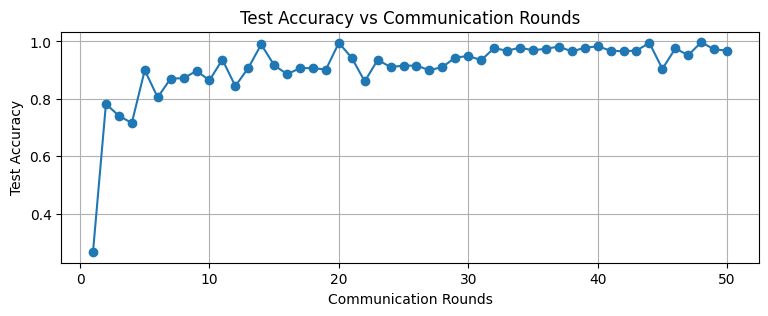

In [ ]:
def plot_accuracy_vs_rounds():
    if test_accuracies:
        plt.figure(figsize=(9,3))
        plt.plot(range(1, len(test_accuracies) + 1), test_accuracies, marker='o', linestyle='-')
        plt.title('Test Accuracy vs Communication Rounds')
        plt.xlabel('Communication Rounds')
        plt.ylabel('Test Accuracy')
        plt.grid(True)
        plt.savefig('accuracy_vs_rounds.png')
        plt.show()
    else:
        print("No accuracy data collected to plot.")

plot_accuracy_vs_rounds()

In [ ]:
params = get_parameters(Net())
from flwr.common import ndarrays_to_parameters

In [ ]:
test_accuracies = []

class CustomFedAvg(FedAvg):
    def aggregate_evaluate(self, server_round, results, failures):
        aggregated_result=super().aggregate_evaluate(server_round,results,failures)

        if aggregated_result is not None:
            loss,metrics=aggregated_result
            accuracy=metrics.get("accuracy",0.0)
            test_accuracies.append(accuracy)
            print(f"Round {server_round}: Test Accuracy: {accuracy:.4f}")
        return aggregated_result

In [ ]:
strategy = CustomFedAvg(
    fraction_fit=1.0,
    fraction_evaluate=0.5,
    min_fit_clients=10,
    min_evaluate_clients=5,
    min_available_clients=10,
    # Passing initial_parameters to FedAvg strategy prevents Flower from asking one of the clients.
    initial_parameters=ndarrays_to_parameters(params),
    evaluate_metrics_aggregation_fn=weighted_average,
)

In [ ]:
run_simulation(
    server_app=server,
    client_app=client,
    num_supernodes=NUM_CLIENTS,
    backend_config=backend_config,
)

(pid=6138) 2025-04-19 18:22:30.200404: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(pid=6138) WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
(pid=6138) E0000 00:00:1745086950.221742    6138 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(pid=6138) E0000 00:00:1745086950.228374    6138 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
(ClientAppActor pid=6138) /usr/local/lib/python3.11/dist-packages/jupyter_client/connect.py:28: DeprecationWarning: Jupyter is migrating its paths to use standard platformdirs
(ClientAppActor pid=6138) given by the platformdirs library.  To remove this warning and
(ClientAppActor pid=6138) see the appropr

(ClientAppActor pid=6138) Context data: {'run_id': 14357686356962983763, 'node_id': 3044876242283094130, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=6138)   array_records={},
(ClientAppActor pid=6138)   metric_records={},
(ClientAppActor pid=6138)   config_records={}
(ClientAppActor pid=6138) ), 'run_config': {}}
(ClientAppActor pid=6138) Using partition_id: 0


(ClientAppActor pid=6138) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=6138)   warnings.warn(


(ClientAppActor pid=6138) Partition 0 size: 3020
(ClientAppActor pid=6138) Partition 0 train size: 2416
(ClientAppActor pid=6138) Partition 0 test size: 604
(ClientAppActor pid=6138) Context data: {'run_id': 14357686356962983763, 'node_id': 10092900326684106736, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=6138)   array_records={},
(ClientAppActor pid=6138)   metric_records={},
(ClientAppActor pid=6138)   config_records={}
(ClientAppActor pid=6138) ), 'run_config': {}}
(ClientAppActor pid=6138) Using partition_id: 6


(ClientAppActor pid=6138) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=6138)   warnings.warn(


(ClientAppActor pid=6138) Partition 6 size: 3965
(ClientAppActor pid=6138) Partition 6 train size: 3172
(ClientAppActor pid=6138) Partition 6 test size: 793
(ClientAppActor pid=6138) Context data: {'run_id': 14357686356962983763, 'node_id': 10585500387969788087, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=6138)   array_records={},
(ClientAppActor pid=6138)   metric_records={},
(ClientAppActor pid=6138)   config_records={}
(ClientAppActor pid=6138) ), 'run_config': {}}
(ClientAppActor pid=6138) Using partition_id: 7


(ClientAppActor pid=6138) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=6138)   warnings.warn(


(ClientAppActor pid=6138) Partition 7 size: 9807
(ClientAppActor pid=6138) Partition 7 train size: 7845
(ClientAppActor pid=6138) Partition 7 test size: 1962
(ClientAppActor pid=6138) Context data: {'run_id': 14357686356962983763, 'node_id': 16113705990370771462, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=6138)   array_records={},
(ClientAppActor pid=6138)   metric_records={},
(ClientAppActor pid=6138)   config_records={}
(ClientAppActor pid=6138) ), 'run_config': {}}
(ClientAppActor pid=6138) Using partition_id: 2


(ClientAppActor pid=6138) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=6138)   warnings.warn(


(ClientAppActor pid=6138) Partition 2 size: 3947
(ClientAppActor pid=6138) Partition 2 train size: 3157
(ClientAppActor pid=6138) Partition 2 test size: 790
(ClientAppActor pid=6138) Context data: {'run_id': 14357686356962983763, 'node_id': 16807725756233906083, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=6138)   array_records={},
(ClientAppActor pid=6138)   metric_records={},
(ClientAppActor pid=6138)   config_records={}
(ClientAppActor pid=6138) ), 'run_config': {}}
(ClientAppActor pid=6138) Using partition_id: 3


(ClientAppActor pid=6138) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=6138)   warnings.warn(


(ClientAppActor pid=6138) Partition 3 size: 3781
(ClientAppActor pid=6138) Partition 3 train size: 3024
(ClientAppActor pid=6138) Partition 3 test size: 757
(ClientAppActor pid=6138) Context data: {'run_id': 14357686356962983763, 'node_id': 1246191053698148921, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=6138)   array_records={},
(ClientAppActor pid=6138)   metric_records={},
(ClientAppActor pid=6138)   config_records={}
(ClientAppActor pid=6138) ), 'run_config': {}}
(ClientAppActor pid=6138) Using partition_id: 1


(ClientAppActor pid=6138) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=6138)   warnings.warn(


(ClientAppActor pid=6138) Partition 1 size: 5987
(ClientAppActor pid=6138) Partition 1 train size: 4789
(ClientAppActor pid=6138) Partition 1 test size: 1198
(ClientAppActor pid=6138) Context data: {'run_id': 14357686356962983763, 'node_id': 14057673959240652263, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=6138)   array_records={},
(ClientAppActor pid=6138)   metric_records={},
(ClientAppActor pid=6138)   config_records={}
(ClientAppActor pid=6138) ), 'run_config': {}}
(ClientAppActor pid=6138) Using partition_id: 3


(ClientAppActor pid=6138) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=6138)   warnings.warn(


(ClientAppActor pid=6138) Partition 3 size: 3781
(ClientAppActor pid=6138) Partition 3 train size: 3024
(ClientAppActor pid=6138) Partition 3 test size: 757
(ClientAppActor pid=6138) Context data: {'run_id': 14357686356962983763, 'node_id': 3632170429766298684, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=6138)   array_records={},
(ClientAppActor pid=6138)   metric_records={},
(ClientAppActor pid=6138)   config_records={}
(ClientAppActor pid=6138) ), 'run_config': {}}
(ClientAppActor pid=6138) Using partition_id: 4


(ClientAppActor pid=6138) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=6138)   warnings.warn(


(ClientAppActor pid=6138) Partition 4 size: 3017
(ClientAppActor pid=6138) Partition 4 train size: 2413
(ClientAppActor pid=6138) Partition 4 test size: 604
(ClientAppActor pid=6138) Context data: {'run_id': 14357686356962983763, 'node_id': 16765704846954335168, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=6138)   array_records={},
(ClientAppActor pid=6138)   metric_records={},
(ClientAppActor pid=6138)   config_records={}
(ClientAppActor pid=6138) ), 'run_config': {}}
(ClientAppActor pid=6138) Using partition_id: 8


(ClientAppActor pid=6138) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=6138)   warnings.warn(


(ClientAppActor pid=6138) Partition 8 size: 3016
(ClientAppActor pid=6138) Partition 8 train size: 2412
(ClientAppActor pid=6138) Partition 8 test size: 604
(ClientAppActor pid=6138) Context data: {'run_id': 14357686356962983763, 'node_id': 5658368351167323924, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=6138)   array_records={},
(ClientAppActor pid=6138)   metric_records={},
(ClientAppActor pid=6138)   config_records={}
(ClientAppActor pid=6138) ), 'run_config': {}}
(ClientAppActor pid=6138) Using partition_id: 4


(ClientAppActor pid=6138) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=6138)   warnings.warn(


(ClientAppActor pid=6138) Partition 4 size: 3017
(ClientAppActor pid=6138) Partition 4 train size: 2413
(ClientAppActor pid=6138) Partition 4 test size: 604
(ClientAppActor pid=6138) Context data: {'run_id': 14357686356962983763, 'node_id': 3044876242283094130, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=6138)   array_records={},
(ClientAppActor pid=6138)   metric_records={},
(ClientAppActor pid=6138)   config_records={}
(ClientAppActor pid=6138) ), 'run_config': {}}
(ClientAppActor pid=6138) Using partition_id: 0


(ClientAppActor pid=6138) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=6138)   warnings.warn(


(ClientAppActor pid=6138) Partition 0 size: 3020
(ClientAppActor pid=6138) Partition 0 train size: 2416
(ClientAppActor pid=6138) Partition 0 test size: 604
(ClientAppActor pid=6138) Context data: {'run_id': 14357686356962983763, 'node_id': 5658368351167323924, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=6138)   array_records={},
(ClientAppActor pid=6138)   metric_records={},
(ClientAppActor pid=6138)   config_records={}
(ClientAppActor pid=6138) ), 'run_config': {}}
(ClientAppActor pid=6138) Using partition_id: 4


(ClientAppActor pid=6138) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=6138)   warnings.warn(


(ClientAppActor pid=6138) Partition 4 size: 3017
(ClientAppActor pid=6138) Partition 4 train size: 2413
(ClientAppActor pid=6138) Partition 4 test size: 604
(ClientAppActor pid=6138) Context data: {'run_id': 14357686356962983763, 'node_id': 14057673959240652263, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=6138)   array_records={},
(ClientAppActor pid=6138)   metric_records={},
(ClientAppActor pid=6138)   config_records={}
(ClientAppActor pid=6138) ), 'run_config': {}}
(ClientAppActor pid=6138) Using partition_id: 3


(ClientAppActor pid=6138) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=6138)   warnings.warn(


(ClientAppActor pid=6138) Partition 3 size: 3781
(ClientAppActor pid=6138) Partition 3 train size: 3024
(ClientAppActor pid=6138) Partition 3 test size: 757
(ClientAppActor pid=6138) Context data: {'run_id': 14357686356962983763, 'node_id': 16113705990370771462, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=6138)   array_records={},
(ClientAppActor pid=6138)   metric_records={},
(ClientAppActor pid=6138)   config_records={}
(ClientAppActor pid=6138) ), 'run_config': {}}
(ClientAppActor pid=6138) Using partition_id: 2


(ClientAppActor pid=6138) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=6138)   warnings.warn(


(ClientAppActor pid=6138) Partition 2 size: 3947
(ClientAppActor pid=6138) Partition 2 train size: 3157
(ClientAppActor pid=6138) Partition 2 test size: 790
(ClientAppActor pid=6138) Context data: {'run_id': 14357686356962983763, 'node_id': 1246191053698148921, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=6138)   array_records={},
(ClientAppActor pid=6138)   metric_records={},
(ClientAppActor pid=6138)   config_records={}
(ClientAppActor pid=6138) ), 'run_config': {}}
(ClientAppActor pid=6138) Using partition_id: 1


(ClientAppActor pid=6138) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=6138)   warnings.warn(


(ClientAppActor pid=6138) Partition 1 size: 5987
(ClientAppActor pid=6138) Partition 1 train size: 4789
(ClientAppActor pid=6138) Partition 1 test size: 1198
Round 1: Test Accuracy: 0.1656
(ClientAppActor pid=6138) Context data: {'run_id': 14357686356962983763, 'node_id': 16765704846954335168, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=6138)   array_records={},
(ClientAppActor pid=6138)   metric_records={},
(ClientAppActor pid=6138)   config_records={}
(ClientAppActor pid=6138) ), 'run_config': {}}
(ClientAppActor pid=6138) Using partition_id: 8


(ClientAppActor pid=6138) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=6138)   warnings.warn(


(ClientAppActor pid=6138) Partition 8 size: 3016
(ClientAppActor pid=6138) Partition 8 train size: 2412
(ClientAppActor pid=6138) Partition 8 test size: 604
(ClientAppActor pid=6138) Context data: {'run_id': 14357686356962983763, 'node_id': 10092900326684106736, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=6138)   array_records={},
(ClientAppActor pid=6138)   metric_records={},
(ClientAppActor pid=6138)   config_records={}
(ClientAppActor pid=6138) ), 'run_config': {}}
(ClientAppActor pid=6138) Using partition_id: 6


(ClientAppActor pid=6138) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=6138)   warnings.warn(


(ClientAppActor pid=6138) Partition 6 size: 3965
(ClientAppActor pid=6138) Partition 6 train size: 3172
(ClientAppActor pid=6138) Partition 6 test size: 793
(ClientAppActor pid=6138) Context data: {'run_id': 14357686356962983763, 'node_id': 10585500387969788087, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=6138)   array_records={},
(ClientAppActor pid=6138)   metric_records={},
(ClientAppActor pid=6138)   config_records={}
(ClientAppActor pid=6138) ), 'run_config': {}}
(ClientAppActor pid=6138) Using partition_id: 7


(ClientAppActor pid=6138) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=6138)   warnings.warn(


(ClientAppActor pid=6138) Partition 7 size: 9807
(ClientAppActor pid=6138) Partition 7 train size: 7845
(ClientAppActor pid=6138) Partition 7 test size: 1962
(ClientAppActor pid=6138) Context data: {'run_id': 14357686356962983763, 'node_id': 5658368351167323924, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=6138)   array_records={},
(ClientAppActor pid=6138)   metric_records={},
(ClientAppActor pid=6138)   config_records={}
(ClientAppActor pid=6138) ), 'run_config': {}}
(ClientAppActor pid=6138) Using partition_id: 4


(ClientAppActor pid=6138) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=6138)   warnings.warn(


(ClientAppActor pid=6138) Partition 4 size: 3017
(ClientAppActor pid=6138) Partition 4 train size: 2413
(ClientAppActor pid=6138) Partition 4 test size: 604
(ClientAppActor pid=6138) Context data: {'run_id': 14357686356962983763, 'node_id': 14057673959240652263, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=6138)   array_records={},
(ClientAppActor pid=6138)   metric_records={},
(ClientAppActor pid=6138)   config_records={}
(ClientAppActor pid=6138) ), 'run_config': {}}
(ClientAppActor pid=6138) Using partition_id: 3


(ClientAppActor pid=6138) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=6138)   warnings.warn(


(ClientAppActor pid=6138) Partition 3 size: 3781
(ClientAppActor pid=6138) Partition 3 train size: 3024
(ClientAppActor pid=6138) Partition 3 test size: 757
(ClientAppActor pid=6138) Context data: {'run_id': 14357686356962983763, 'node_id': 3632170429766298684, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=6138)   array_records={},
(ClientAppActor pid=6138)   metric_records={},
(ClientAppActor pid=6138)   config_records={}
(ClientAppActor pid=6138) ), 'run_config': {}}
(ClientAppActor pid=6138) Using partition_id: 4


(ClientAppActor pid=6138) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=6138)   warnings.warn(


(ClientAppActor pid=6138) Partition 4 size: 3017
(ClientAppActor pid=6138) Partition 4 train size: 2413
(ClientAppActor pid=6138) Partition 4 test size: 604
(ClientAppActor pid=6138) Context data: {'run_id': 14357686356962983763, 'node_id': 1246191053698148921, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=6138)   array_records={},
(ClientAppActor pid=6138)   metric_records={},
(ClientAppActor pid=6138)   config_records={}
(ClientAppActor pid=6138) ), 'run_config': {}}
(ClientAppActor pid=6138) Using partition_id: 1


(ClientAppActor pid=6138) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=6138)   warnings.warn(


(ClientAppActor pid=6138) Partition 1 size: 5987
(ClientAppActor pid=6138) Partition 1 train size: 4789
(ClientAppActor pid=6138) Partition 1 test size: 1198
(ClientAppActor pid=6138) Context data: {'run_id': 14357686356962983763, 'node_id': 16113705990370771462, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=6138)   array_records={},
(ClientAppActor pid=6138)   metric_records={},
(ClientAppActor pid=6138)   config_records={}
(ClientAppActor pid=6138) ), 'run_config': {}}
(ClientAppActor pid=6138) Using partition_id: 2


(ClientAppActor pid=6138) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=6138)   warnings.warn(


(ClientAppActor pid=6138) Partition 2 size: 3947
(ClientAppActor pid=6138) Partition 2 train size: 3157
(ClientAppActor pid=6138) Partition 2 test size: 790
(ClientAppActor pid=6138) Context data: {'run_id': 14357686356962983763, 'node_id': 16807725756233906083, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=6138)   array_records={},
(ClientAppActor pid=6138)   metric_records={},
(ClientAppActor pid=6138)   config_records={}
(ClientAppActor pid=6138) ), 'run_config': {}}
(ClientAppActor pid=6138) Using partition_id: 3


(ClientAppActor pid=6138) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=6138)   warnings.warn(


(ClientAppActor pid=6138) Partition 3 size: 3781
(ClientAppActor pid=6138) Partition 3 train size: 3024
(ClientAppActor pid=6138) Partition 3 test size: 757
(ClientAppActor pid=6138) Context data: {'run_id': 14357686356962983763, 'node_id': 3044876242283094130, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=6138)   array_records={},
(ClientAppActor pid=6138)   metric_records={},
(ClientAppActor pid=6138)   config_records={}
(ClientAppActor pid=6138) ), 'run_config': {}}
(ClientAppActor pid=6138) Using partition_id: 0


(ClientAppActor pid=6138) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=6138)   warnings.warn(


(ClientAppActor pid=6138) Partition 0 size: 3020
(ClientAppActor pid=6138) Partition 0 train size: 2416
(ClientAppActor pid=6138) Partition 0 test size: 604
(ClientAppActor pid=6138) Context data: {'run_id': 14357686356962983763, 'node_id': 16765704846954335168, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=6138)   array_records={},
(ClientAppActor pid=6138)   metric_records={},
(ClientAppActor pid=6138)   config_records={}
(ClientAppActor pid=6138) ), 'run_config': {}}
(ClientAppActor pid=6138) Using partition_id: 8


(ClientAppActor pid=6138) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=6138)   warnings.warn(


(ClientAppActor pid=6138) Partition 8 size: 3016
(ClientAppActor pid=6138) Partition 8 train size: 2412
(ClientAppActor pid=6138) Partition 8 test size: 604
(ClientAppActor pid=6138) Context data: {'run_id': 14357686356962983763, 'node_id': 14057673959240652263, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=6138)   array_records={},
(ClientAppActor pid=6138)   metric_records={},
(ClientAppActor pid=6138)   config_records={}
(ClientAppActor pid=6138) ), 'run_config': {}}
(ClientAppActor pid=6138) Using partition_id: 3


(ClientAppActor pid=6138) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=6138)   warnings.warn(


(ClientAppActor pid=6138) Partition 3 size: 3781
(ClientAppActor pid=6138) Partition 3 train size: 3024
(ClientAppActor pid=6138) Partition 3 test size: 757
(ClientAppActor pid=6138) Context data: {'run_id': 14357686356962983763, 'node_id': 16807725756233906083, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=6138)   array_records={},
(ClientAppActor pid=6138)   metric_records={},
(ClientAppActor pid=6138)   config_records={}
(ClientAppActor pid=6138) ), 'run_config': {}}
(ClientAppActor pid=6138) Using partition_id: 3


(ClientAppActor pid=6138) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=6138)   warnings.warn(


(ClientAppActor pid=6138) Partition 3 size: 3781
(ClientAppActor pid=6138) Partition 3 train size: 3024
(ClientAppActor pid=6138) Partition 3 test size: 757
(ClientAppActor pid=6138) Context data: {'run_id': 14357686356962983763, 'node_id': 1246191053698148921, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=6138)   array_records={},
(ClientAppActor pid=6138)   metric_records={},
(ClientAppActor pid=6138)   config_records={}
(ClientAppActor pid=6138) ), 'run_config': {}}
(ClientAppActor pid=6138) Using partition_id: 1


(ClientAppActor pid=6138) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=6138)   warnings.warn(


(ClientAppActor pid=6138) Partition 1 size: 5987
(ClientAppActor pid=6138) Partition 1 train size: 4789
(ClientAppActor pid=6138) Partition 1 test size: 1198
(ClientAppActor pid=6138) Context data: {'run_id': 14357686356962983763, 'node_id': 3632170429766298684, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=6138)   array_records={},
(ClientAppActor pid=6138)   metric_records={},
(ClientAppActor pid=6138)   config_records={}
(ClientAppActor pid=6138) ), 'run_config': {}}
(ClientAppActor pid=6138) Using partition_id: 4


(ClientAppActor pid=6138) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=6138)   warnings.warn(


(ClientAppActor pid=6138) Partition 4 size: 3017
(ClientAppActor pid=6138) Partition 4 train size: 2413
(ClientAppActor pid=6138) Partition 4 test size: 604
Round 2: Test Accuracy: 0.5813
(ClientAppActor pid=6138) Context data: {'run_id': 14357686356962983763, 'node_id': 10092900326684106736, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=6138)   array_records={},
(ClientAppActor pid=6138)   metric_records={},
(ClientAppActor pid=6138)   config_records={}
(ClientAppActor pid=6138) ), 'run_config': {}}
(ClientAppActor pid=6138) Using partition_id: 6


(ClientAppActor pid=6138) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=6138)   warnings.warn(


(ClientAppActor pid=6138) Partition 6 size: 3965
(ClientAppActor pid=6138) Partition 6 train size: 3172
(ClientAppActor pid=6138) Partition 6 test size: 793
(ClientAppActor pid=6138) Context data: {'run_id': 14357686356962983763, 'node_id': 10585500387969788087, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=6138)   array_records={},
(ClientAppActor pid=6138)   metric_records={},
(ClientAppActor pid=6138)   config_records={}
(ClientAppActor pid=6138) ), 'run_config': {}}
(ClientAppActor pid=6138) Using partition_id: 7


(ClientAppActor pid=6138) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=6138)   warnings.warn(


(ClientAppActor pid=6138) Partition 7 size: 9807
(ClientAppActor pid=6138) Partition 7 train size: 7845
(ClientAppActor pid=6138) Partition 7 test size: 1962
(ClientAppActor pid=6138) Context data: {'run_id': 14357686356962983763, 'node_id': 14057673959240652263, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=6138)   array_records={},
(ClientAppActor pid=6138)   metric_records={},
(ClientAppActor pid=6138)   config_records={}
(ClientAppActor pid=6138) ), 'run_config': {}}
(ClientAppActor pid=6138) Using partition_id: 3


(ClientAppActor pid=6138) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=6138)   warnings.warn(


(ClientAppActor pid=6138) Partition 3 size: 3781
(ClientAppActor pid=6138) Partition 3 train size: 3024
(ClientAppActor pid=6138) Partition 3 test size: 757
(ClientAppActor pid=6138) Context data: {'run_id': 14357686356962983763, 'node_id': 16113705990370771462, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=6138)   array_records={},
(ClientAppActor pid=6138)   metric_records={},
(ClientAppActor pid=6138)   config_records={}
(ClientAppActor pid=6138) ), 'run_config': {}}
(ClientAppActor pid=6138) Using partition_id: 2


(ClientAppActor pid=6138) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=6138)   warnings.warn(


(ClientAppActor pid=6138) Partition 2 size: 3947
(ClientAppActor pid=6138) Partition 2 train size: 3157
(ClientAppActor pid=6138) Partition 2 test size: 790
(ClientAppActor pid=6138) Context data: {'run_id': 14357686356962983763, 'node_id': 16807725756233906083, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=6138)   array_records={},
(ClientAppActor pid=6138)   metric_records={},
(ClientAppActor pid=6138)   config_records={}
(ClientAppActor pid=6138) ), 'run_config': {}}
(ClientAppActor pid=6138) Using partition_id: 3


(ClientAppActor pid=6138) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=6138)   warnings.warn(


(ClientAppActor pid=6138) Partition 3 size: 3781
(ClientAppActor pid=6138) Partition 3 train size: 3024
(ClientAppActor pid=6138) Partition 3 test size: 757
(ClientAppActor pid=6138) Context data: {'run_id': 14357686356962983763, 'node_id': 3632170429766298684, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=6138)   array_records={},
(ClientAppActor pid=6138)   metric_records={},
(ClientAppActor pid=6138)   config_records={}
(ClientAppActor pid=6138) ), 'run_config': {}}
(ClientAppActor pid=6138) Using partition_id: 4


(ClientAppActor pid=6138) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=6138)   warnings.warn(


(ClientAppActor pid=6138) Partition 4 size: 3017
(ClientAppActor pid=6138) Partition 4 train size: 2413
(ClientAppActor pid=6138) Partition 4 test size: 604
(ClientAppActor pid=6138) Context data: {'run_id': 14357686356962983763, 'node_id': 3044876242283094130, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=6138)   array_records={},
(ClientAppActor pid=6138)   metric_records={},
(ClientAppActor pid=6138)   config_records={}
(ClientAppActor pid=6138) ), 'run_config': {}}
(ClientAppActor pid=6138) Using partition_id: 0


(ClientAppActor pid=6138) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=6138)   warnings.warn(


(ClientAppActor pid=6138) Partition 0 size: 3020
(ClientAppActor pid=6138) Partition 0 train size: 2416
(ClientAppActor pid=6138) Partition 0 test size: 604
(ClientAppActor pid=6138) Context data: {'run_id': 14357686356962983763, 'node_id': 16765704846954335168, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=6138)   array_records={},
(ClientAppActor pid=6138)   metric_records={},
(ClientAppActor pid=6138)   config_records={}
(ClientAppActor pid=6138) ), 'run_config': {}}
(ClientAppActor pid=6138) Using partition_id: 8


(ClientAppActor pid=6138) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=6138)   warnings.warn(


(ClientAppActor pid=6138) Partition 8 size: 3016
(ClientAppActor pid=6138) Partition 8 train size: 2412
(ClientAppActor pid=6138) Partition 8 test size: 604
(ClientAppActor pid=6138) Context data: {'run_id': 14357686356962983763, 'node_id': 1246191053698148921, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=6138)   array_records={},
(ClientAppActor pid=6138)   metric_records={},
(ClientAppActor pid=6138)   config_records={}
(ClientAppActor pid=6138) ), 'run_config': {}}
(ClientAppActor pid=6138) Using partition_id: 1


(ClientAppActor pid=6138) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=6138)   warnings.warn(


(ClientAppActor pid=6138) Partition 1 size: 5987
(ClientAppActor pid=6138) Partition 1 train size: 4789
(ClientAppActor pid=6138) Partition 1 test size: 1198
(ClientAppActor pid=6138) Context data: {'run_id': 14357686356962983763, 'node_id': 5658368351167323924, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=6138)   array_records={},
(ClientAppActor pid=6138)   metric_records={},
(ClientAppActor pid=6138)   config_records={}
(ClientAppActor pid=6138) ), 'run_config': {}}
(ClientAppActor pid=6138) Using partition_id: 4


(ClientAppActor pid=6138) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=6138)   warnings.warn(


(ClientAppActor pid=6138) Partition 4 size: 3017
(ClientAppActor pid=6138) Partition 4 train size: 2413
(ClientAppActor pid=6138) Partition 4 test size: 604
(ClientAppActor pid=6138) Context data: {'run_id': 14357686356962983763, 'node_id': 16765704846954335168, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=6138)   array_records={},
(ClientAppActor pid=6138)   metric_records={},
(ClientAppActor pid=6138)   config_records={}
(ClientAppActor pid=6138) ), 'run_config': {}}
(ClientAppActor pid=6138) Using partition_id: 8


(ClientAppActor pid=6138) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=6138)   warnings.warn(


(ClientAppActor pid=6138) Partition 8 size: 3016
(ClientAppActor pid=6138) Partition 8 train size: 2412
(ClientAppActor pid=6138) Partition 8 test size: 604
(ClientAppActor pid=6138) Context data: {'run_id': 14357686356962983763, 'node_id': 3044876242283094130, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=6138)   array_records={},
(ClientAppActor pid=6138)   metric_records={},
(ClientAppActor pid=6138)   config_records={}
(ClientAppActor pid=6138) ), 'run_config': {}}
(ClientAppActor pid=6138) Using partition_id: 0


(ClientAppActor pid=6138) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=6138)   warnings.warn(


(ClientAppActor pid=6138) Partition 0 size: 3020
(ClientAppActor pid=6138) Partition 0 train size: 2416
(ClientAppActor pid=6138) Partition 0 test size: 604
(ClientAppActor pid=6138) Context data: {'run_id': 14357686356962983763, 'node_id': 5658368351167323924, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=6138)   array_records={},
(ClientAppActor pid=6138)   metric_records={},
(ClientAppActor pid=6138)   config_records={}
(ClientAppActor pid=6138) ), 'run_config': {}}
(ClientAppActor pid=6138) Using partition_id: 4


(ClientAppActor pid=6138) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=6138)   warnings.warn(


(ClientAppActor pid=6138) Partition 4 size: 3017
(ClientAppActor pid=6138) Partition 4 train size: 2413
(ClientAppActor pid=6138) Partition 4 test size: 604
(ClientAppActor pid=6138) Context data: {'run_id': 14357686356962983763, 'node_id': 16113705990370771462, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=6138)   array_records={},
(ClientAppActor pid=6138)   metric_records={},
(ClientAppActor pid=6138)   config_records={}
(ClientAppActor pid=6138) ), 'run_config': {}}
(ClientAppActor pid=6138) Using partition_id: 2


(ClientAppActor pid=6138) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=6138)   warnings.warn(


(ClientAppActor pid=6138) Partition 2 size: 3947
(ClientAppActor pid=6138) Partition 2 train size: 3157
(ClientAppActor pid=6138) Partition 2 test size: 790
(ClientAppActor pid=6138) Context data: {'run_id': 14357686356962983763, 'node_id': 1246191053698148921, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=6138)   array_records={},
(ClientAppActor pid=6138)   metric_records={},
(ClientAppActor pid=6138)   config_records={}
(ClientAppActor pid=6138) ), 'run_config': {}}
(ClientAppActor pid=6138) Using partition_id: 1


(ClientAppActor pid=6138) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=6138)   warnings.warn(


(ClientAppActor pid=6138) Partition 1 size: 5987
(ClientAppActor pid=6138) Partition 1 train size: 4789
(ClientAppActor pid=6138) Partition 1 test size: 1198
Round 3: Test Accuracy: 0.9426
(ClientAppActor pid=6138) Context data: {'run_id': 14357686356962983763, 'node_id': 16765704846954335168, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=6138)   array_records={},
(ClientAppActor pid=6138)   metric_records={},
(ClientAppActor pid=6138)   config_records={}
(ClientAppActor pid=6138) ), 'run_config': {}}
(ClientAppActor pid=6138) Using partition_id: 8


(ClientAppActor pid=6138) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=6138)   warnings.warn(


(ClientAppActor pid=6138) Partition 8 size: 3016
(ClientAppActor pid=6138) Partition 8 train size: 2412
(ClientAppActor pid=6138) Partition 8 test size: 604
(ClientAppActor pid=6138) Context data: {'run_id': 14357686356962983763, 'node_id': 3044876242283094130, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=6138)   array_records={},
(ClientAppActor pid=6138)   metric_records={},
(ClientAppActor pid=6138)   config_records={}
(ClientAppActor pid=6138) ), 'run_config': {}}
(ClientAppActor pid=6138) Using partition_id: 0


(ClientAppActor pid=6138) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=6138)   warnings.warn(


(ClientAppActor pid=6138) Partition 0 size: 3020
(ClientAppActor pid=6138) Partition 0 train size: 2416
(ClientAppActor pid=6138) Partition 0 test size: 604
(ClientAppActor pid=6138) Context data: {'run_id': 14357686356962983763, 'node_id': 14057673959240652263, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=6138)   array_records={},
(ClientAppActor pid=6138)   metric_records={},
(ClientAppActor pid=6138)   config_records={}
(ClientAppActor pid=6138) ), 'run_config': {}}
(ClientAppActor pid=6138) Using partition_id: 3


(ClientAppActor pid=6138) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=6138)   warnings.warn(


(ClientAppActor pid=6138) Partition 3 size: 3781
(ClientAppActor pid=6138) Partition 3 train size: 3024
(ClientAppActor pid=6138) Partition 3 test size: 757
(ClientAppActor pid=6138) Context data: {'run_id': 14357686356962983763, 'node_id': 16807725756233906083, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=6138)   array_records={},
(ClientAppActor pid=6138)   metric_records={},
(ClientAppActor pid=6138)   config_records={}
(ClientAppActor pid=6138) ), 'run_config': {}}
(ClientAppActor pid=6138) Using partition_id: 3
(ClientAppActor pid=6138) Context data: {'run_id': 14357686356962983763, 'node_id': 1246191053698148921, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=6138)   array_records={},
(ClientAppActor pid=6138)   metric_records={},
(ClientAppActor pid=6138)   config_records={}
(ClientAppActor pid=6138) ), 'run_config': {}}
(ClientAppActor pid=6138) Using partition_id: 1


(ClientAppActor pid=6138) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=6138) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Sat Apr 19 18:23:10 2025).
(ClientAppActor pid=6138) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=6138)   warnings.warn(


(ClientAppActor pid=6138) Partition 1 size: 5987
(ClientAppActor pid=6138) Partition 1 train size: 4789
(ClientAppActor pid=6138) Partition 1 test size: 1198
(ClientAppActor pid=6138) Context data: {'run_id': 14357686356962983763, 'node_id': 3632170429766298684, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=6138)   array_records={},
(ClientAppActor pid=6138)   metric_records={},
(ClientAppActor pid=6138)   config_records={}
(ClientAppActor pid=6138) ), 'run_config': {}}
(ClientAppActor pid=6138) Using partition_id: 4


(ClientAppActor pid=6138) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=6138) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Sat Apr 19 18:23:10 2025).
(ClientAppActor pid=6138) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=6138)   warnings.warn(


(ClientAppActor pid=6138) Partition 4 size: 3017
(ClientAppActor pid=6138) Partition 4 train size: 2413
(ClientAppActor pid=6138) Partition 4 test size: 604
(ClientAppActor pid=6138) Context data: {'run_id': 14357686356962983763, 'node_id': 5658368351167323924, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=6138)   array_records={},
(ClientAppActor pid=6138)   metric_records={},
(ClientAppActor pid=6138)   config_records={}
(ClientAppActor pid=6138) ), 'run_config': {}}
(ClientAppActor pid=6138) Using partition_id: 4


(ClientAppActor pid=6138) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=6138) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Sat Apr 19 18:23:10 2025).
(ClientAppActor pid=6138) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=6138)   warnings.warn(


(ClientAppActor pid=6138) Partition 4 size: 3017
(ClientAppActor pid=6138) Partition 4 train size: 2413
(ClientAppActor pid=6138) Partition 4 test size: 604
(ClientAppActor pid=6138) Context data: {'run_id': 14357686356962983763, 'node_id': 16113705990370771462, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=6138)   array_records={},
(ClientAppActor pid=6138)   metric_records={},
(ClientAppActor pid=6138)   config_records={}
(ClientAppActor pid=6138) ), 'run_config': {}}
(ClientAppActor pid=6138) Using partition_id: 2


(ClientAppActor pid=6138) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=6138) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Sat Apr 19 18:23:10 2025).
(ClientAppActor pid=6138) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=6138)   warnings.warn(


(ClientAppActor pid=6138) Partition 2 size: 3947
(ClientAppActor pid=6138) Partition 2 train size: 3157
(ClientAppActor pid=6138) Partition 2 test size: 790
(ClientAppActor pid=6138) Context data: {'run_id': 14357686356962983763, 'node_id': 10092900326684106736, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=6138)   array_records={},
(ClientAppActor pid=6138)   metric_records={},
(ClientAppActor pid=6138)   config_records={}
(ClientAppActor pid=6138) ), 'run_config': {}}
(ClientAppActor pid=6138) Using partition_id: 6


(ClientAppActor pid=6138) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=6138) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Sat Apr 19 18:23:10 2025).
(ClientAppActor pid=6138) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=6138)   warnings.warn(


(ClientAppActor pid=6138) Partition 6 size: 3965
(ClientAppActor pid=6138) Partition 6 train size: 3172
(ClientAppActor pid=6138) Partition 6 test size: 793
(ClientAppActor pid=6138) Context data: {'run_id': 14357686356962983763, 'node_id': 10585500387969788087, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=6138)   array_records={},
(ClientAppActor pid=6138)   metric_records={},
(ClientAppActor pid=6138)   config_records={}
(ClientAppActor pid=6138) ), 'run_config': {}}
(ClientAppActor pid=6138) Using partition_id: 7


(ClientAppActor pid=6138) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=6138) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Sat Apr 19 18:23:10 2025).
(ClientAppActor pid=6138) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=6138)   warnings.warn(


(ClientAppActor pid=6138) Partition 7 size: 9807
(ClientAppActor pid=6138) Partition 7 train size: 7845
(ClientAppActor pid=6138) Partition 7 test size: 1962
(ClientAppActor pid=6138) Context data: {'run_id': 14357686356962983763, 'node_id': 16765704846954335168, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=6138)   array_records={},
(ClientAppActor pid=6138)   metric_records={},
(ClientAppActor pid=6138)   config_records={}
(ClientAppActor pid=6138) ), 'run_config': {}}
(ClientAppActor pid=6138) Using partition_id: 8


(ClientAppActor pid=6138) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=6138) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Sat Apr 19 18:23:10 2025).
(ClientAppActor pid=6138) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=6138)   warnings.warn(


(ClientAppActor pid=6138) Partition 8 size: 3016
(ClientAppActor pid=6138) Partition 8 train size: 2412
(ClientAppActor pid=6138) Partition 8 test size: 604
(ClientAppActor pid=6138) Context data: {'run_id': 14357686356962983763, 'node_id': 3044876242283094130, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=6138)   array_records={},
(ClientAppActor pid=6138)   metric_records={},
(ClientAppActor pid=6138)   config_records={}
(ClientAppActor pid=6138) ), 'run_config': {}}
(ClientAppActor pid=6138) Using partition_id: 0


(ClientAppActor pid=6138) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=6138) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Sat Apr 19 18:23:10 2025).
(ClientAppActor pid=6138) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=6138)   warnings.warn(


(ClientAppActor pid=6138) Partition 0 size: 3020
(ClientAppActor pid=6138) Partition 0 train size: 2416
(ClientAppActor pid=6138) Partition 0 test size: 604
(ClientAppActor pid=6138) Context data: {'run_id': 14357686356962983763, 'node_id': 10585500387969788087, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=6138)   array_records={},
(ClientAppActor pid=6138)   metric_records={},
(ClientAppActor pid=6138)   config_records={}
(ClientAppActor pid=6138) ), 'run_config': {}}
(ClientAppActor pid=6138) Using partition_id: 7


(ClientAppActor pid=6138) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=6138) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Sat Apr 19 18:23:10 2025).
(ClientAppActor pid=6138) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=6138)   warnings.warn(


(ClientAppActor pid=6138) Partition 7 size: 9807
(ClientAppActor pid=6138) Partition 7 train size: 7845
(ClientAppActor pid=6138) Partition 7 test size: 1962
(ClientAppActor pid=6138) Context data: {'run_id': 14357686356962983763, 'node_id': 5658368351167323924, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=6138)   array_records={},
(ClientAppActor pid=6138)   metric_records={},
(ClientAppActor pid=6138)   config_records={}
(ClientAppActor pid=6138) ), 'run_config': {}}
(ClientAppActor pid=6138) Using partition_id: 4


(ClientAppActor pid=6138) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=6138) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Sat Apr 19 18:23:10 2025).
(ClientAppActor pid=6138) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=6138)   warnings.warn(


(ClientAppActor pid=6138) Partition 4 size: 3017
(ClientAppActor pid=6138) Partition 4 train size: 2413
(ClientAppActor pid=6138) Partition 4 test size: 604
(ClientAppActor pid=6138) Context data: {'run_id': 14357686356962983763, 'node_id': 1246191053698148921, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=6138)   array_records={},
(ClientAppActor pid=6138)   metric_records={},
(ClientAppActor pid=6138)   config_records={}
(ClientAppActor pid=6138) ), 'run_config': {}}
(ClientAppActor pid=6138) Using partition_id: 1


(ClientAppActor pid=6138) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=6138) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Sat Apr 19 18:23:10 2025).
(ClientAppActor pid=6138) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=6138)   warnings.warn(


(ClientAppActor pid=6138) Partition 1 size: 5987
(ClientAppActor pid=6138) Partition 1 train size: 4789
(ClientAppActor pid=6138) Partition 1 test size: 1198
Round 4: Test Accuracy: 0.9404
(ClientAppActor pid=6138) Context data: {'run_id': 14357686356962983763, 'node_id': 3044876242283094130, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=6138)   array_records={},
(ClientAppActor pid=6138)   metric_records={},
(ClientAppActor pid=6138)   config_records={}
(ClientAppActor pid=6138) ), 'run_config': {}}
(ClientAppActor pid=6138) Using partition_id: 0


(ClientAppActor pid=6138) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=6138) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Sat Apr 19 18:23:10 2025).
(ClientAppActor pid=6138) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=6138)   warnings.warn(


(ClientAppActor pid=6138) Partition 0 size: 3020
(ClientAppActor pid=6138) Partition 0 train size: 2416
(ClientAppActor pid=6138) Partition 0 test size: 604
(ClientAppActor pid=6138) Context data: {'run_id': 14357686356962983763, 'node_id': 10585500387969788087, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=6138)   array_records={},
(ClientAppActor pid=6138)   metric_records={},
(ClientAppActor pid=6138)   config_records={}
(ClientAppActor pid=6138) ), 'run_config': {}}
(ClientAppActor pid=6138) Using partition_id: 7


(ClientAppActor pid=6138) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=6138) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Sat Apr 19 18:23:10 2025).
(ClientAppActor pid=6138) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=6138)   warnings.warn(


(ClientAppActor pid=6138) Partition 7 size: 9807
(ClientAppActor pid=6138) Partition 7 train size: 7845
(ClientAppActor pid=6138) Partition 7 test size: 1962
(ClientAppActor pid=6138) Context data: {'run_id': 14357686356962983763, 'node_id': 5658368351167323924, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=6138)   array_records={},
(ClientAppActor pid=6138)   metric_records={},
(ClientAppActor pid=6138)   config_records={}
(ClientAppActor pid=6138) ), 'run_config': {}}
(ClientAppActor pid=6138) Using partition_id: 4


(ClientAppActor pid=6138) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=6138) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Sat Apr 19 18:23:10 2025).
(ClientAppActor pid=6138) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=6138)   warnings.warn(


(ClientAppActor pid=6138) Partition 4 size: 3017
(ClientAppActor pid=6138) Partition 4 train size: 2413
(ClientAppActor pid=6138) Partition 4 test size: 604
(ClientAppActor pid=6138) Context data: {'run_id': 14357686356962983763, 'node_id': 14057673959240652263, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=6138)   array_records={},
(ClientAppActor pid=6138)   metric_records={},
(ClientAppActor pid=6138)   config_records={}
(ClientAppActor pid=6138) ), 'run_config': {}}
(ClientAppActor pid=6138) Using partition_id: 3


(ClientAppActor pid=6138) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=6138)   warnings.warn(


(ClientAppActor pid=6138) Partition 3 size: 3781
(ClientAppActor pid=6138) Partition 3 train size: 3024
(ClientAppActor pid=6138) Partition 3 test size: 757
(ClientAppActor pid=6138) Context data: {'run_id': 14357686356962983763, 'node_id': 16113705990370771462, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=6138)   array_records={},
(ClientAppActor pid=6138)   metric_records={},
(ClientAppActor pid=6138)   config_records={}
(ClientAppActor pid=6138) ), 'run_config': {}}
(ClientAppActor pid=6138) Using partition_id: 2


(ClientAppActor pid=6138) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=6138)   warnings.warn(


(ClientAppActor pid=6138) Partition 2 size: 3947
(ClientAppActor pid=6138) Partition 2 train size: 3157
(ClientAppActor pid=6138) Partition 2 test size: 790
(ClientAppActor pid=6138) Context data: {'run_id': 14357686356962983763, 'node_id': 1246191053698148921, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=6138)   array_records={},
(ClientAppActor pid=6138)   metric_records={},
(ClientAppActor pid=6138)   config_records={}
(ClientAppActor pid=6138) ), 'run_config': {}}
(ClientAppActor pid=6138) Using partition_id: 1


(ClientAppActor pid=6138) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=6138)   warnings.warn(


(ClientAppActor pid=6138) Partition 1 size: 5987
(ClientAppActor pid=6138) Partition 1 train size: 4789
(ClientAppActor pid=6138) Partition 1 test size: 1198
(ClientAppActor pid=6138) Context data: {'run_id': 14357686356962983763, 'node_id': 3632170429766298684, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=6138)   array_records={},
(ClientAppActor pid=6138)   metric_records={},
(ClientAppActor pid=6138)   config_records={}
(ClientAppActor pid=6138) ), 'run_config': {}}
(ClientAppActor pid=6138) Using partition_id: 4


(ClientAppActor pid=6138) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=6138)   warnings.warn(


(ClientAppActor pid=6138) Partition 4 size: 3017
(ClientAppActor pid=6138) Partition 4 train size: 2413
(ClientAppActor pid=6138) Partition 4 test size: 604
(ClientAppActor pid=6138) Context data: {'run_id': 14357686356962983763, 'node_id': 10092900326684106736, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=6138)   array_records={},
(ClientAppActor pid=6138)   metric_records={},
(ClientAppActor pid=6138)   config_records={}
(ClientAppActor pid=6138) ), 'run_config': {}}
(ClientAppActor pid=6138) Using partition_id: 6


(ClientAppActor pid=6138) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=6138)   warnings.warn(


(ClientAppActor pid=6138) Partition 6 size: 3965
(ClientAppActor pid=6138) Partition 6 train size: 3172
(ClientAppActor pid=6138) Partition 6 test size: 793
(ClientAppActor pid=6138) Context data: {'run_id': 14357686356962983763, 'node_id': 16807725756233906083, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=6138)   array_records={},
(ClientAppActor pid=6138)   metric_records={},
(ClientAppActor pid=6138)   config_records={}
(ClientAppActor pid=6138) ), 'run_config': {}}
(ClientAppActor pid=6138) Using partition_id: 3


(ClientAppActor pid=6138) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=6138)   warnings.warn(


(ClientAppActor pid=6138) Partition 3 size: 3781
(ClientAppActor pid=6138) Partition 3 train size: 3024
(ClientAppActor pid=6138) Partition 3 test size: 757
(ClientAppActor pid=6138) Context data: {'run_id': 14357686356962983763, 'node_id': 16765704846954335168, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=6138)   array_records={},
(ClientAppActor pid=6138)   metric_records={},
(ClientAppActor pid=6138)   config_records={}
(ClientAppActor pid=6138) ), 'run_config': {}}
(ClientAppActor pid=6138) Using partition_id: 8


(ClientAppActor pid=6138) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=6138)   warnings.warn(


(ClientAppActor pid=6138) Partition 8 size: 3016
(ClientAppActor pid=6138) Partition 8 train size: 2412
(ClientAppActor pid=6138) Partition 8 test size: 604
(ClientAppActor pid=6138) Context data: {'run_id': 14357686356962983763, 'node_id': 3044876242283094130, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=6138)   array_records={},
(ClientAppActor pid=6138)   metric_records={},
(ClientAppActor pid=6138)   config_records={}
(ClientAppActor pid=6138) ), 'run_config': {}}
(ClientAppActor pid=6138) Using partition_id: 0


(ClientAppActor pid=6138) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=6138)   warnings.warn(


(ClientAppActor pid=6138) Partition 0 size: 3020
(ClientAppActor pid=6138) Partition 0 train size: 2416
(ClientAppActor pid=6138) Partition 0 test size: 604
(ClientAppActor pid=6138) Context data: {'run_id': 14357686356962983763, 'node_id': 10585500387969788087, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=6138)   array_records={},
(ClientAppActor pid=6138)   metric_records={},
(ClientAppActor pid=6138)   config_records={}
(ClientAppActor pid=6138) ), 'run_config': {}}
(ClientAppActor pid=6138) Using partition_id: 7


(ClientAppActor pid=6138) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=6138)   warnings.warn(


(ClientAppActor pid=6138) Partition 7 size: 9807
(ClientAppActor pid=6138) Partition 7 train size: 7845
(ClientAppActor pid=6138) Partition 7 test size: 1962
(ClientAppActor pid=6138) Context data: {'run_id': 14357686356962983763, 'node_id': 5658368351167323924, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=6138)   array_records={},
(ClientAppActor pid=6138)   metric_records={},
(ClientAppActor pid=6138)   config_records={}
(ClientAppActor pid=6138) ), 'run_config': {}}
(ClientAppActor pid=6138) Using partition_id: 4


(ClientAppActor pid=6138) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=6138)   warnings.warn(


(ClientAppActor pid=6138) Partition 4 size: 3017
(ClientAppActor pid=6138) Partition 4 train size: 2413
(ClientAppActor pid=6138) Partition 4 test size: 604
(ClientAppActor pid=6138) Context data: {'run_id': 14357686356962983763, 'node_id': 16113705990370771462, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=6138)   array_records={},
(ClientAppActor pid=6138)   metric_records={},
(ClientAppActor pid=6138)   config_records={}
(ClientAppActor pid=6138) ), 'run_config': {}}
(ClientAppActor pid=6138) Using partition_id: 2


(ClientAppActor pid=6138) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=6138)   warnings.warn(


(ClientAppActor pid=6138) Partition 2 size: 3947
(ClientAppActor pid=6138) Partition 2 train size: 3157
(ClientAppActor pid=6138) Partition 2 test size: 790
(ClientAppActor pid=6138) Context data: {'run_id': 14357686356962983763, 'node_id': 1246191053698148921, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=6138)   array_records={},
(ClientAppActor pid=6138)   metric_records={},
(ClientAppActor pid=6138)   config_records={}
(ClientAppActor pid=6138) ), 'run_config': {}}
(ClientAppActor pid=6138) Using partition_id: 1


(ClientAppActor pid=6138) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=6138)   warnings.warn(


(ClientAppActor pid=6138) Partition 1 size: 5987
(ClientAppActor pid=6138) Partition 1 train size: 4789
(ClientAppActor pid=6138) Partition 1 test size: 1198
Round 5: Test Accuracy: 0.9542
(ClientAppActor pid=6138) Context data: {'run_id': 14357686356962983763, 'node_id': 10092900326684106736, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=6138)   array_records={},
(ClientAppActor pid=6138)   metric_records={},
(ClientAppActor pid=6138)   config_records={}
(ClientAppActor pid=6138) ), 'run_config': {}}
(ClientAppActor pid=6138) Using partition_id: 6


(ClientAppActor pid=6138) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=6138)   warnings.warn(


(ClientAppActor pid=6138) Partition 6 size: 3965
(ClientAppActor pid=6138) Partition 6 train size: 3172
(ClientAppActor pid=6138) Partition 6 test size: 793
(ClientAppActor pid=6138) Context data: {'run_id': 14357686356962983763, 'node_id': 5658368351167323924, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=6138)   array_records={},
(ClientAppActor pid=6138)   metric_records={},
(ClientAppActor pid=6138)   config_records={}
(ClientAppActor pid=6138) ), 'run_config': {}}
(ClientAppActor pid=6138) Using partition_id: 4


(ClientAppActor pid=6138) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=6138)   warnings.warn(


(ClientAppActor pid=6138) Partition 4 size: 3017
(ClientAppActor pid=6138) Partition 4 train size: 2413
(ClientAppActor pid=6138) Partition 4 test size: 604
(ClientAppActor pid=6138) Context data: {'run_id': 14357686356962983763, 'node_id': 14057673959240652263, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=6138)   array_records={},
(ClientAppActor pid=6138)   metric_records={},
(ClientAppActor pid=6138)   config_records={}
(ClientAppActor pid=6138) ), 'run_config': {}}
(ClientAppActor pid=6138) Using partition_id: 3


(ClientAppActor pid=6138) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=6138)   warnings.warn(


(ClientAppActor pid=6138) Partition 3 size: 3781
(ClientAppActor pid=6138) Partition 3 train size: 3024
(ClientAppActor pid=6138) Partition 3 test size: 757
(ClientAppActor pid=6138) Context data: {'run_id': 14357686356962983763, 'node_id': 16113705990370771462, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=6138)   array_records={},
(ClientAppActor pid=6138)   metric_records={},
(ClientAppActor pid=6138)   config_records={}
(ClientAppActor pid=6138) ), 'run_config': {}}
(ClientAppActor pid=6138) Using partition_id: 2


(ClientAppActor pid=6138) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=6138)   warnings.warn(


(ClientAppActor pid=6138) Partition 2 size: 3947
(ClientAppActor pid=6138) Partition 2 train size: 3157
(ClientAppActor pid=6138) Partition 2 test size: 790
(ClientAppActor pid=6138) Context data: {'run_id': 14357686356962983763, 'node_id': 16807725756233906083, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=6138)   array_records={},
(ClientAppActor pid=6138)   metric_records={},
(ClientAppActor pid=6138)   config_records={}
(ClientAppActor pid=6138) ), 'run_config': {}}
(ClientAppActor pid=6138) Using partition_id: 3


(ClientAppActor pid=6138) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=6138)   warnings.warn(


(ClientAppActor pid=6138) Partition 3 size: 3781
(ClientAppActor pid=6138) Partition 3 train size: 3024
(ClientAppActor pid=6138) Partition 3 test size: 757
(ClientAppActor pid=6138) Context data: {'run_id': 14357686356962983763, 'node_id': 1246191053698148921, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=6138)   array_records={},
(ClientAppActor pid=6138)   metric_records={},
(ClientAppActor pid=6138)   config_records={}
(ClientAppActor pid=6138) ), 'run_config': {}}
(ClientAppActor pid=6138) Using partition_id: 1


(ClientAppActor pid=6138) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=6138)   warnings.warn(


(ClientAppActor pid=6138) Partition 1 size: 5987
(ClientAppActor pid=6138) Partition 1 train size: 4789
(ClientAppActor pid=6138) Partition 1 test size: 1198
(ClientAppActor pid=6138) Context data: {'run_id': 14357686356962983763, 'node_id': 16765704846954335168, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=6138)   array_records={},
(ClientAppActor pid=6138)   metric_records={},
(ClientAppActor pid=6138)   config_records={}
(ClientAppActor pid=6138) ), 'run_config': {}}
(ClientAppActor pid=6138) Using partition_id: 8


(ClientAppActor pid=6138) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=6138)   warnings.warn(


(ClientAppActor pid=6138) Partition 8 size: 3016
(ClientAppActor pid=6138) Partition 8 train size: 2412
(ClientAppActor pid=6138) Partition 8 test size: 604
(ClientAppActor pid=6138) Context data: {'run_id': 14357686356962983763, 'node_id': 10585500387969788087, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=6138)   array_records={},
(ClientAppActor pid=6138)   metric_records={},
(ClientAppActor pid=6138)   config_records={}
(ClientAppActor pid=6138) ), 'run_config': {}}
(ClientAppActor pid=6138) Using partition_id: 7


(ClientAppActor pid=6138) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=6138)   warnings.warn(


(ClientAppActor pid=6138) Partition 7 size: 9807
(ClientAppActor pid=6138) Partition 7 train size: 7845
(ClientAppActor pid=6138) Partition 7 test size: 1962
(ClientAppActor pid=6138) Context data: {'run_id': 14357686356962983763, 'node_id': 3044876242283094130, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=6138)   array_records={},
(ClientAppActor pid=6138)   metric_records={},
(ClientAppActor pid=6138)   config_records={}
(ClientAppActor pid=6138) ), 'run_config': {}}
(ClientAppActor pid=6138) Using partition_id: 0


(ClientAppActor pid=6138) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=6138)   warnings.warn(


(ClientAppActor pid=6138) Partition 0 size: 3020
(ClientAppActor pid=6138) Partition 0 train size: 2416
(ClientAppActor pid=6138) Partition 0 test size: 604
(ClientAppActor pid=6138) Context data: {'run_id': 14357686356962983763, 'node_id': 3632170429766298684, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=6138)   array_records={},
(ClientAppActor pid=6138)   metric_records={},
(ClientAppActor pid=6138)   config_records={}
(ClientAppActor pid=6138) ), 'run_config': {}}
(ClientAppActor pid=6138) Using partition_id: 4


(ClientAppActor pid=6138) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=6138)   warnings.warn(


(ClientAppActor pid=6138) Partition 4 size: 3017
(ClientAppActor pid=6138) Partition 4 train size: 2413
(ClientAppActor pid=6138) Partition 4 test size: 604
(ClientAppActor pid=6138) Context data: {'run_id': 14357686356962983763, 'node_id': 10585500387969788087, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=6138)   array_records={},
(ClientAppActor pid=6138)   metric_records={},
(ClientAppActor pid=6138)   config_records={}
(ClientAppActor pid=6138) ), 'run_config': {}}
(ClientAppActor pid=6138) Using partition_id: 7


(ClientAppActor pid=6138) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=6138)   warnings.warn(


(ClientAppActor pid=6138) Partition 7 size: 9807
(ClientAppActor pid=6138) Partition 7 train size: 7845
(ClientAppActor pid=6138) Partition 7 test size: 1962
(ClientAppActor pid=6138) Context data: {'run_id': 14357686356962983763, 'node_id': 3044876242283094130, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=6138)   array_records={},
(ClientAppActor pid=6138)   metric_records={},
(ClientAppActor pid=6138)   config_records={}
(ClientAppActor pid=6138) ), 'run_config': {}}
(ClientAppActor pid=6138) Using partition_id: 0


(ClientAppActor pid=6138) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=6138)   warnings.warn(


(ClientAppActor pid=6138) Partition 0 size: 3020
(ClientAppActor pid=6138) Partition 0 train size: 2416
(ClientAppActor pid=6138) Partition 0 test size: 604
(ClientAppActor pid=6138) Context data: {'run_id': 14357686356962983763, 'node_id': 14057673959240652263, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=6138)   array_records={},
(ClientAppActor pid=6138)   metric_records={},
(ClientAppActor pid=6138)   config_records={}
(ClientAppActor pid=6138) ), 'run_config': {}}
(ClientAppActor pid=6138) Using partition_id: 3


(ClientAppActor pid=6138) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=6138)   warnings.warn(


(ClientAppActor pid=6138) Partition 3 size: 3781
(ClientAppActor pid=6138) Partition 3 train size: 3024
(ClientAppActor pid=6138) Partition 3 test size: 757
(ClientAppActor pid=6138) Context data: {'run_id': 14357686356962983763, 'node_id': 16113705990370771462, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=6138)   array_records={},
(ClientAppActor pid=6138)   metric_records={},
(ClientAppActor pid=6138)   config_records={}
(ClientAppActor pid=6138) ), 'run_config': {}}
(ClientAppActor pid=6138) Using partition_id: 2


(ClientAppActor pid=6138) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=6138)   warnings.warn(


(ClientAppActor pid=6138) Partition 2 size: 3947
(ClientAppActor pid=6138) Partition 2 train size: 3157
(ClientAppActor pid=6138) Partition 2 test size: 790
(ClientAppActor pid=6138) Context data: {'run_id': 14357686356962983763, 'node_id': 3632170429766298684, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=6138)   array_records={},
(ClientAppActor pid=6138)   metric_records={},
(ClientAppActor pid=6138)   config_records={}
(ClientAppActor pid=6138) ), 'run_config': {}}
(ClientAppActor pid=6138) Using partition_id: 4


(ClientAppActor pid=6138) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=6138)   warnings.warn(


(ClientAppActor pid=6138) Partition 4 size: 3017
(ClientAppActor pid=6138) Partition 4 train size: 2413
(ClientAppActor pid=6138) Partition 4 test size: 604
Round 6: Test Accuracy: 0.8797
(ClientAppActor pid=6138) Context data: {'run_id': 14357686356962983763, 'node_id': 3044876242283094130, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=6138)   array_records={},
(ClientAppActor pid=6138)   metric_records={},
(ClientAppActor pid=6138)   config_records={}
(ClientAppActor pid=6138) ), 'run_config': {}}
(ClientAppActor pid=6138) Using partition_id: 0


(ClientAppActor pid=6138) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=6138)   warnings.warn(


(ClientAppActor pid=6138) Partition 0 size: 3020
(ClientAppActor pid=6138) Partition 0 train size: 2416
(ClientAppActor pid=6138) Partition 0 test size: 604
(ClientAppActor pid=6138) Context data: {'run_id': 14357686356962983763, 'node_id': 10092900326684106736, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=6138)   array_records={},
(ClientAppActor pid=6138)   metric_records={},
(ClientAppActor pid=6138)   config_records={}
(ClientAppActor pid=6138) ), 'run_config': {}}
(ClientAppActor pid=6138) Using partition_id: 6


(ClientAppActor pid=6138) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=6138)   warnings.warn(


(ClientAppActor pid=6138) Partition 6 size: 3965
(ClientAppActor pid=6138) Partition 6 train size: 3172
(ClientAppActor pid=6138) Partition 6 test size: 793
(ClientAppActor pid=6138) Context data: {'run_id': 14357686356962983763, 'node_id': 10585500387969788087, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=6138)   array_records={},
(ClientAppActor pid=6138)   metric_records={},
(ClientAppActor pid=6138)   config_records={}
(ClientAppActor pid=6138) ), 'run_config': {}}
(ClientAppActor pid=6138) Using partition_id: 7


(ClientAppActor pid=6138) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=6138) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Sat Apr 19 18:23:10 2025).
(ClientAppActor pid=6138) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=6138)   warnings.warn(


(ClientAppActor pid=6138) Partition 7 size: 9807
(ClientAppActor pid=6138) Partition 7 train size: 7845
(ClientAppActor pid=6138) Partition 7 test size: 1962
(ClientAppActor pid=6138) Context data: {'run_id': 14357686356962983763, 'node_id': 5658368351167323924, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=6138)   array_records={},
(ClientAppActor pid=6138)   metric_records={},
(ClientAppActor pid=6138)   config_records={}
(ClientAppActor pid=6138) ), 'run_config': {}}
(ClientAppActor pid=6138) Using partition_id: 4


(ClientAppActor pid=6138) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=6138) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Sat Apr 19 18:23:10 2025).
(ClientAppActor pid=6138) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=6138)   warnings.warn(


(ClientAppActor pid=6138) Partition 4 size: 3017
(ClientAppActor pid=6138) Partition 4 train size: 2413
(ClientAppActor pid=6138) Partition 4 test size: 604
(ClientAppActor pid=6138) Context data: {'run_id': 14357686356962983763, 'node_id': 16807725756233906083, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=6138)   array_records={},
(ClientAppActor pid=6138)   metric_records={},
(ClientAppActor pid=6138)   config_records={}
(ClientAppActor pid=6138) ), 'run_config': {}}
(ClientAppActor pid=6138) Using partition_id: 3


(ClientAppActor pid=6138) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=6138) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Sat Apr 19 18:23:10 2025).
(ClientAppActor pid=6138) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=6138)   warnings.warn(


(ClientAppActor pid=6138) Partition 3 size: 3781
(ClientAppActor pid=6138) Partition 3 train size: 3024
(ClientAppActor pid=6138) Partition 3 test size: 757
(ClientAppActor pid=6138) Context data: {'run_id': 14357686356962983763, 'node_id': 3632170429766298684, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=6138)   array_records={},
(ClientAppActor pid=6138)   metric_records={},
(ClientAppActor pid=6138)   config_records={}
(ClientAppActor pid=6138) ), 'run_config': {}}
(ClientAppActor pid=6138) Using partition_id: 4


(ClientAppActor pid=6138) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=6138) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Sat Apr 19 18:23:10 2025).
(ClientAppActor pid=6138) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=6138)   warnings.warn(


(ClientAppActor pid=6138) Partition 4 size: 3017
(ClientAppActor pid=6138) Partition 4 train size: 2413
(ClientAppActor pid=6138) Partition 4 test size: 604
(ClientAppActor pid=6138) Context data: {'run_id': 14357686356962983763, 'node_id': 1246191053698148921, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=6138)   array_records={},
(ClientAppActor pid=6138)   metric_records={},
(ClientAppActor pid=6138)   config_records={}
(ClientAppActor pid=6138) ), 'run_config': {}}
(ClientAppActor pid=6138) Using partition_id: 1


(ClientAppActor pid=6138) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=6138) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Sat Apr 19 18:23:10 2025).
(ClientAppActor pid=6138) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=6138)   warnings.warn(


(ClientAppActor pid=6138) Partition 1 size: 5987
(ClientAppActor pid=6138) Partition 1 train size: 4789
(ClientAppActor pid=6138) Partition 1 test size: 1198
(ClientAppActor pid=6138) Context data: {'run_id': 14357686356962983763, 'node_id': 14057673959240652263, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=6138)   array_records={},
(ClientAppActor pid=6138)   metric_records={},
(ClientAppActor pid=6138)   config_records={}
(ClientAppActor pid=6138) ), 'run_config': {}}
(ClientAppActor pid=6138) Using partition_id: 3


(ClientAppActor pid=6138) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=6138) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Sat Apr 19 18:23:10 2025).
(ClientAppActor pid=6138) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=6138)   warnings.warn(


(ClientAppActor pid=6138) Partition 3 size: 3781
(ClientAppActor pid=6138) Partition 3 train size: 3024
(ClientAppActor pid=6138) Partition 3 test size: 757
(ClientAppActor pid=6138) Context data: {'run_id': 14357686356962983763, 'node_id': 16113705990370771462, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=6138)   array_records={},
(ClientAppActor pid=6138)   metric_records={},
(ClientAppActor pid=6138)   config_records={}
(ClientAppActor pid=6138) ), 'run_config': {}}
(ClientAppActor pid=6138) Using partition_id: 2


(ClientAppActor pid=6138) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=6138) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Sat Apr 19 18:23:10 2025).
(ClientAppActor pid=6138) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=6138)   warnings.warn(


(ClientAppActor pid=6138) Partition 2 size: 3947
(ClientAppActor pid=6138) Partition 2 train size: 3157
(ClientAppActor pid=6138) Partition 2 test size: 790
(ClientAppActor pid=6138) Context data: {'run_id': 14357686356962983763, 'node_id': 16765704846954335168, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=6138)   array_records={},
(ClientAppActor pid=6138)   metric_records={},
(ClientAppActor pid=6138)   config_records={}
(ClientAppActor pid=6138) ), 'run_config': {}}
(ClientAppActor pid=6138) Using partition_id: 8


(ClientAppActor pid=6138) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=6138) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Sat Apr 19 18:23:10 2025).
(ClientAppActor pid=6138) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=6138)   warnings.warn(


(ClientAppActor pid=6138) Partition 8 size: 3016
(ClientAppActor pid=6138) Partition 8 train size: 2412
(ClientAppActor pid=6138) Partition 8 test size: 604
(ClientAppActor pid=6138) Context data: {'run_id': 14357686356962983763, 'node_id': 10092900326684106736, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=6138)   array_records={},
(ClientAppActor pid=6138)   metric_records={},
(ClientAppActor pid=6138)   config_records={}
(ClientAppActor pid=6138) ), 'run_config': {}}
(ClientAppActor pid=6138) Using partition_id: 6


(ClientAppActor pid=6138) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=6138) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Sat Apr 19 18:23:10 2025).
(ClientAppActor pid=6138) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=6138)   warnings.warn(


(ClientAppActor pid=6138) Partition 6 size: 3965
(ClientAppActor pid=6138) Partition 6 train size: 3172
(ClientAppActor pid=6138) Partition 6 test size: 793
(ClientAppActor pid=6138) Context data: {'run_id': 14357686356962983763, 'node_id': 10585500387969788087, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=6138)   array_records={},
(ClientAppActor pid=6138)   metric_records={},
(ClientAppActor pid=6138)   config_records={}
(ClientAppActor pid=6138) ), 'run_config': {}}
(ClientAppActor pid=6138) Using partition_id: 7


(ClientAppActor pid=6138) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=6138)   warnings.warn(


(ClientAppActor pid=6138) Partition 7 size: 9807
(ClientAppActor pid=6138) Partition 7 train size: 7845
(ClientAppActor pid=6138) Partition 7 test size: 1962
(ClientAppActor pid=6138) Context data: {'run_id': 14357686356962983763, 'node_id': 16113705990370771462, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=6138)   array_records={},
(ClientAppActor pid=6138)   metric_records={},
(ClientAppActor pid=6138)   config_records={}
(ClientAppActor pid=6138) ), 'run_config': {}}
(ClientAppActor pid=6138) Using partition_id: 2


(ClientAppActor pid=6138) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=6138)   warnings.warn(


(ClientAppActor pid=6138) Partition 2 size: 3947
(ClientAppActor pid=6138) Partition 2 train size: 3157
(ClientAppActor pid=6138) Partition 2 test size: 790
(ClientAppActor pid=6138) Context data: {'run_id': 14357686356962983763, 'node_id': 1246191053698148921, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=6138)   array_records={},
(ClientAppActor pid=6138)   metric_records={},
(ClientAppActor pid=6138)   config_records={}
(ClientAppActor pid=6138) ), 'run_config': {}}
(ClientAppActor pid=6138) Using partition_id: 1


(ClientAppActor pid=6138) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=6138)   warnings.warn(


(ClientAppActor pid=6138) Partition 1 size: 5987
(ClientAppActor pid=6138) Partition 1 train size: 4789
(ClientAppActor pid=6138) Partition 1 test size: 1198
(ClientAppActor pid=6138) Context data: {'run_id': 14357686356962983763, 'node_id': 3632170429766298684, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=6138)   array_records={},
(ClientAppActor pid=6138)   metric_records={},
(ClientAppActor pid=6138)   config_records={}
(ClientAppActor pid=6138) ), 'run_config': {}}
(ClientAppActor pid=6138) Using partition_id: 4


(ClientAppActor pid=6138) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=6138)   warnings.warn(


(ClientAppActor pid=6138) Partition 4 size: 3017
(ClientAppActor pid=6138) Partition 4 train size: 2413
(ClientAppActor pid=6138) Partition 4 test size: 604
Round 7: Test Accuracy: 0.9639
(ClientAppActor pid=6138) Context data: {'run_id': 14357686356962983763, 'node_id': 3044876242283094130, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=6138)   array_records={},
(ClientAppActor pid=6138)   metric_records={},
(ClientAppActor pid=6138)   config_records={}
(ClientAppActor pid=6138) ), 'run_config': {}}
(ClientAppActor pid=6138) Using partition_id: 0


(ClientAppActor pid=6138) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=6138)   warnings.warn(


(ClientAppActor pid=6138) Partition 0 size: 3020
(ClientAppActor pid=6138) Partition 0 train size: 2416
(ClientAppActor pid=6138) Partition 0 test size: 604
(ClientAppActor pid=6138) Context data: {'run_id': 14357686356962983763, 'node_id': 10585500387969788087, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=6138)   array_records={},
(ClientAppActor pid=6138)   metric_records={},
(ClientAppActor pid=6138)   config_records={}
(ClientAppActor pid=6138) ), 'run_config': {}}
(ClientAppActor pid=6138) Using partition_id: 7


(ClientAppActor pid=6138) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=6138)   warnings.warn(


(ClientAppActor pid=6138) Partition 7 size: 9807
(ClientAppActor pid=6138) Partition 7 train size: 7845
(ClientAppActor pid=6138) Partition 7 test size: 1962
(ClientAppActor pid=6138) Context data: {'run_id': 14357686356962983763, 'node_id': 5658368351167323924, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=6138)   array_records={},
(ClientAppActor pid=6138)   metric_records={},
(ClientAppActor pid=6138)   config_records={}
(ClientAppActor pid=6138) ), 'run_config': {}}
(ClientAppActor pid=6138) Using partition_id: 4


(ClientAppActor pid=6138) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=6138)   warnings.warn(


(ClientAppActor pid=6138) Partition 4 size: 3017
(ClientAppActor pid=6138) Partition 4 train size: 2413
(ClientAppActor pid=6138) Partition 4 test size: 604
(ClientAppActor pid=6138) Context data: {'run_id': 14357686356962983763, 'node_id': 14057673959240652263, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=6138)   array_records={},
(ClientAppActor pid=6138)   metric_records={},
(ClientAppActor pid=6138)   config_records={}
(ClientAppActor pid=6138) ), 'run_config': {}}
(ClientAppActor pid=6138) Using partition_id: 3


(ClientAppActor pid=6138) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=6138)   warnings.warn(


(ClientAppActor pid=6138) Partition 3 size: 3781
(ClientAppActor pid=6138) Partition 3 train size: 3024
(ClientAppActor pid=6138) Partition 3 test size: 757
(ClientAppActor pid=6138) Context data: {'run_id': 14357686356962983763, 'node_id': 16807725756233906083, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=6138)   array_records={},
(ClientAppActor pid=6138)   metric_records={},
(ClientAppActor pid=6138)   config_records={}
(ClientAppActor pid=6138) ), 'run_config': {}}
(ClientAppActor pid=6138) Using partition_id: 3


(ClientAppActor pid=6138) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=6138)   warnings.warn(


(ClientAppActor pid=6138) Partition 3 size: 3781
(ClientAppActor pid=6138) Partition 3 train size: 3024
(ClientAppActor pid=6138) Partition 3 test size: 757
(ClientAppActor pid=6138) Context data: {'run_id': 14357686356962983763, 'node_id': 1246191053698148921, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=6138)   array_records={},
(ClientAppActor pid=6138)   metric_records={},
(ClientAppActor pid=6138)   config_records={}
(ClientAppActor pid=6138) ), 'run_config': {}}
(ClientAppActor pid=6138) Using partition_id: 1


(ClientAppActor pid=6138) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=6138)   warnings.warn(


(ClientAppActor pid=6138) Partition 1 size: 5987
(ClientAppActor pid=6138) Partition 1 train size: 4789
(ClientAppActor pid=6138) Partition 1 test size: 1198
(ClientAppActor pid=6138) Context data: {'run_id': 14357686356962983763, 'node_id': 16113705990370771462, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=6138)   array_records={},
(ClientAppActor pid=6138)   metric_records={},
(ClientAppActor pid=6138)   config_records={}
(ClientAppActor pid=6138) ), 'run_config': {}}
(ClientAppActor pid=6138) Using partition_id: 2


(ClientAppActor pid=6138) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=6138)   warnings.warn(


(ClientAppActor pid=6138) Partition 2 size: 3947
(ClientAppActor pid=6138) Partition 2 train size: 3157
(ClientAppActor pid=6138) Partition 2 test size: 790
(ClientAppActor pid=6138) Context data: {'run_id': 14357686356962983763, 'node_id': 16765704846954335168, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=6138)   array_records={},
(ClientAppActor pid=6138)   metric_records={},
(ClientAppActor pid=6138)   config_records={}
(ClientAppActor pid=6138) ), 'run_config': {}}
(ClientAppActor pid=6138) Using partition_id: 8


(ClientAppActor pid=6138) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=6138)   warnings.warn(


(ClientAppActor pid=6138) Partition 8 size: 3016
(ClientAppActor pid=6138) Partition 8 train size: 2412
(ClientAppActor pid=6138) Partition 8 test size: 604
(ClientAppActor pid=6138) Context data: {'run_id': 14357686356962983763, 'node_id': 3632170429766298684, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=6138)   array_records={},
(ClientAppActor pid=6138)   metric_records={},
(ClientAppActor pid=6138)   config_records={}
(ClientAppActor pid=6138) ), 'run_config': {}}
(ClientAppActor pid=6138) Using partition_id: 4


(ClientAppActor pid=6138) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=6138)   warnings.warn(


(ClientAppActor pid=6138) Partition 4 size: 3017
(ClientAppActor pid=6138) Partition 4 train size: 2413
(ClientAppActor pid=6138) Partition 4 test size: 604
(ClientAppActor pid=6138) Context data: {'run_id': 14357686356962983763, 'node_id': 10092900326684106736, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=6138)   array_records={},
(ClientAppActor pid=6138)   metric_records={},
(ClientAppActor pid=6138)   config_records={}
(ClientAppActor pid=6138) ), 'run_config': {}}
(ClientAppActor pid=6138) Using partition_id: 6


(ClientAppActor pid=6138) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=6138)   warnings.warn(


(ClientAppActor pid=6138) Partition 6 size: 3965
(ClientAppActor pid=6138) Partition 6 train size: 3172
(ClientAppActor pid=6138) Partition 6 test size: 793
(ClientAppActor pid=6138) Context data: {'run_id': 14357686356962983763, 'node_id': 3044876242283094130, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=6138)   array_records={},
(ClientAppActor pid=6138)   metric_records={},
(ClientAppActor pid=6138)   config_records={}
(ClientAppActor pid=6138) ), 'run_config': {}}
(ClientAppActor pid=6138) Using partition_id: 0


(ClientAppActor pid=6138) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=6138)   warnings.warn(


(ClientAppActor pid=6138) Partition 0 size: 3020
(ClientAppActor pid=6138) Partition 0 train size: 2416
(ClientAppActor pid=6138) Partition 0 test size: 604
(ClientAppActor pid=6138) Context data: {'run_id': 14357686356962983763, 'node_id': 10585500387969788087, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=6138)   array_records={},
(ClientAppActor pid=6138)   metric_records={},
(ClientAppActor pid=6138)   config_records={}
(ClientAppActor pid=6138) ), 'run_config': {}}
(ClientAppActor pid=6138) Using partition_id: 7


(ClientAppActor pid=6138) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=6138)   warnings.warn(


(ClientAppActor pid=6138) Partition 7 size: 9807
(ClientAppActor pid=6138) Partition 7 train size: 7845
(ClientAppActor pid=6138) Partition 7 test size: 1962
(ClientAppActor pid=6138) Context data: {'run_id': 14357686356962983763, 'node_id': 14057673959240652263, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=6138)   array_records={},
(ClientAppActor pid=6138)   metric_records={},
(ClientAppActor pid=6138)   config_records={}
(ClientAppActor pid=6138) ), 'run_config': {}}
(ClientAppActor pid=6138) Using partition_id: 3


(ClientAppActor pid=6138) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=6138)   warnings.warn(


(ClientAppActor pid=6138) Partition 3 size: 3781
(ClientAppActor pid=6138) Partition 3 train size: 3024
(ClientAppActor pid=6138) Partition 3 test size: 757
(ClientAppActor pid=6138) Context data: {'run_id': 14357686356962983763, 'node_id': 16113705990370771462, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=6138)   array_records={},
(ClientAppActor pid=6138)   metric_records={},
(ClientAppActor pid=6138)   config_records={}
(ClientAppActor pid=6138) ), 'run_config': {}}
(ClientAppActor pid=6138) Using partition_id: 2


(ClientAppActor pid=6138) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=6138)   warnings.warn(


(ClientAppActor pid=6138) Partition 2 size: 3947
(ClientAppActor pid=6138) Partition 2 train size: 3157
(ClientAppActor pid=6138) Partition 2 test size: 790
(ClientAppActor pid=6138) Context data: {'run_id': 14357686356962983763, 'node_id': 1246191053698148921, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=6138)   array_records={},
(ClientAppActor pid=6138)   metric_records={},
(ClientAppActor pid=6138)   config_records={}
(ClientAppActor pid=6138) ), 'run_config': {}}
(ClientAppActor pid=6138) Using partition_id: 1


(ClientAppActor pid=6138) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=6138)   warnings.warn(


(ClientAppActor pid=6138) Partition 1 size: 5987
(ClientAppActor pid=6138) Partition 1 train size: 4789
(ClientAppActor pid=6138) Partition 1 test size: 1198
Round 8: Test Accuracy: 0.9025
(ClientAppActor pid=6138) Context data: {'run_id': 14357686356962983763, 'node_id': 16765704846954335168, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=6138)   array_records={},
(ClientAppActor pid=6138)   metric_records={},
(ClientAppActor pid=6138)   config_records={}
(ClientAppActor pid=6138) ), 'run_config': {}}
(ClientAppActor pid=6138) Using partition_id: 8


(ClientAppActor pid=6138) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=6138)   warnings.warn(


(ClientAppActor pid=6138) Partition 8 size: 3016
(ClientAppActor pid=6138) Partition 8 train size: 2412
(ClientAppActor pid=6138) Partition 8 test size: 604
(ClientAppActor pid=6138) Context data: {'run_id': 14357686356962983763, 'node_id': 3044876242283094130, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=6138)   array_records={},
(ClientAppActor pid=6138)   metric_records={},
(ClientAppActor pid=6138)   config_records={}
(ClientAppActor pid=6138) ), 'run_config': {}}
(ClientAppActor pid=6138) Using partition_id: 0


(ClientAppActor pid=6138) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=6138)   warnings.warn(


(ClientAppActor pid=6138) Partition 0 size: 3020
(ClientAppActor pid=6138) Partition 0 train size: 2416
(ClientAppActor pid=6138) Partition 0 test size: 604
(ClientAppActor pid=6138) Context data: {'run_id': 14357686356962983763, 'node_id': 10092900326684106736, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=6138)   array_records={},
(ClientAppActor pid=6138)   metric_records={},
(ClientAppActor pid=6138)   config_records={}
(ClientAppActor pid=6138) ), 'run_config': {}}
(ClientAppActor pid=6138) Using partition_id: 6


(ClientAppActor pid=6138) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=6138)   warnings.warn(


(ClientAppActor pid=6138) Partition 6 size: 3965
(ClientAppActor pid=6138) Partition 6 train size: 3172
(ClientAppActor pid=6138) Partition 6 test size: 793
(ClientAppActor pid=6138) Context data: {'run_id': 14357686356962983763, 'node_id': 14057673959240652263, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=6138)   array_records={},
(ClientAppActor pid=6138)   metric_records={},
(ClientAppActor pid=6138)   config_records={}
(ClientAppActor pid=6138) ), 'run_config': {}}
(ClientAppActor pid=6138) Using partition_id: 3


(ClientAppActor pid=6138) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=6138)   warnings.warn(


(ClientAppActor pid=6138) Partition 3 size: 3781
(ClientAppActor pid=6138) Partition 3 train size: 3024
(ClientAppActor pid=6138) Partition 3 test size: 757
(ClientAppActor pid=6138) Context data: {'run_id': 14357686356962983763, 'node_id': 16113705990370771462, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=6138)   array_records={},
(ClientAppActor pid=6138)   metric_records={},
(ClientAppActor pid=6138)   config_records={}
(ClientAppActor pid=6138) ), 'run_config': {}}
(ClientAppActor pid=6138) Using partition_id: 2


(ClientAppActor pid=6138) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=6138)   warnings.warn(


(ClientAppActor pid=6138) Partition 2 size: 3947
(ClientAppActor pid=6138) Partition 2 train size: 3157
(ClientAppActor pid=6138) Partition 2 test size: 790
(ClientAppActor pid=6138) Context data: {'run_id': 14357686356962983763, 'node_id': 1246191053698148921, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=6138)   array_records={},
(ClientAppActor pid=6138)   metric_records={},
(ClientAppActor pid=6138)   config_records={}
(ClientAppActor pid=6138) ), 'run_config': {}}
(ClientAppActor pid=6138) Using partition_id: 1


(ClientAppActor pid=6138) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=6138)   warnings.warn(


(ClientAppActor pid=6138) Partition 1 size: 5987
(ClientAppActor pid=6138) Partition 1 train size: 4789
(ClientAppActor pid=6138) Partition 1 test size: 1198
(ClientAppActor pid=6138) Context data: {'run_id': 14357686356962983763, 'node_id': 16807725756233906083, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=6138)   array_records={},
(ClientAppActor pid=6138)   metric_records={},
(ClientAppActor pid=6138)   config_records={}
(ClientAppActor pid=6138) ), 'run_config': {}}
(ClientAppActor pid=6138) Using partition_id: 3


(ClientAppActor pid=6138) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=6138) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Sat Apr 19 18:23:10 2025).
(ClientAppActor pid=6138) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=6138)   warnings.warn(


(ClientAppActor pid=6138) Partition 3 size: 3781
(ClientAppActor pid=6138) Partition 3 train size: 3024
(ClientAppActor pid=6138) Partition 3 test size: 757
(ClientAppActor pid=6138) Context data: {'run_id': 14357686356962983763, 'node_id': 3632170429766298684, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=6138)   array_records={},
(ClientAppActor pid=6138)   metric_records={},
(ClientAppActor pid=6138)   config_records={}
(ClientAppActor pid=6138) ), 'run_config': {}}
(ClientAppActor pid=6138) Using partition_id: 4


(ClientAppActor pid=6138) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=6138) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Sat Apr 19 18:23:10 2025).
(ClientAppActor pid=6138) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=6138)   warnings.warn(


(ClientAppActor pid=6138) Partition 4 size: 3017
(ClientAppActor pid=6138) Partition 4 train size: 2413
(ClientAppActor pid=6138) Partition 4 test size: 604
(ClientAppActor pid=6138) Context data: {'run_id': 14357686356962983763, 'node_id': 10585500387969788087, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=6138)   array_records={},
(ClientAppActor pid=6138)   metric_records={},
(ClientAppActor pid=6138)   config_records={}
(ClientAppActor pid=6138) ), 'run_config': {}}
(ClientAppActor pid=6138) Using partition_id: 7


(ClientAppActor pid=6138) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=6138) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Sat Apr 19 18:23:10 2025).
(ClientAppActor pid=6138) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=6138)   warnings.warn(


(ClientAppActor pid=6138) Partition 7 size: 9807
(ClientAppActor pid=6138) Partition 7 train size: 7845
(ClientAppActor pid=6138) Partition 7 test size: 1962
(ClientAppActor pid=6138) Context data: {'run_id': 14357686356962983763, 'node_id': 5658368351167323924, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=6138)   array_records={},
(ClientAppActor pid=6138)   metric_records={},
(ClientAppActor pid=6138)   config_records={}
(ClientAppActor pid=6138) ), 'run_config': {}}
(ClientAppActor pid=6138) Using partition_id: 4


(ClientAppActor pid=6138) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=6138) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Sat Apr 19 18:23:10 2025).
(ClientAppActor pid=6138) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=6138)   warnings.warn(


(ClientAppActor pid=6138) Partition 4 size: 3017
(ClientAppActor pid=6138) Partition 4 train size: 2413
(ClientAppActor pid=6138) Partition 4 test size: 604
(ClientAppActor pid=6138) Context data: {'run_id': 14357686356962983763, 'node_id': 3044876242283094130, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=6138)   array_records={},
(ClientAppActor pid=6138)   metric_records={},
(ClientAppActor pid=6138)   config_records={}
(ClientAppActor pid=6138) ), 'run_config': {}}
(ClientAppActor pid=6138) Using partition_id: 0


(ClientAppActor pid=6138) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=6138) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Sat Apr 19 18:23:10 2025).
(ClientAppActor pid=6138) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=6138)   warnings.warn(


(ClientAppActor pid=6138) Partition 0 size: 3020
(ClientAppActor pid=6138) Partition 0 train size: 2416
(ClientAppActor pid=6138) Partition 0 test size: 604
(ClientAppActor pid=6138) Context data: {'run_id': 14357686356962983763, 'node_id': 10092900326684106736, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=6138)   array_records={},
(ClientAppActor pid=6138)   metric_records={},
(ClientAppActor pid=6138)   config_records={}
(ClientAppActor pid=6138) ), 'run_config': {}}
(ClientAppActor pid=6138) Using partition_id: 6


(ClientAppActor pid=6138) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=6138) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Sat Apr 19 18:23:10 2025).
(ClientAppActor pid=6138) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=6138)   warnings.warn(


(ClientAppActor pid=6138) Partition 6 size: 3965
(ClientAppActor pid=6138) Partition 6 train size: 3172
(ClientAppActor pid=6138) Partition 6 test size: 793
(ClientAppActor pid=6138) Context data: {'run_id': 14357686356962983763, 'node_id': 5658368351167323924, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=6138)   array_records={},
(ClientAppActor pid=6138)   metric_records={},
(ClientAppActor pid=6138)   config_records={}
(ClientAppActor pid=6138) ), 'run_config': {}}
(ClientAppActor pid=6138) Using partition_id: 4


(ClientAppActor pid=6138) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=6138) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Sat Apr 19 18:23:10 2025).
(ClientAppActor pid=6138) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=6138)   warnings.warn(


(ClientAppActor pid=6138) Partition 4 size: 3017
(ClientAppActor pid=6138) Partition 4 train size: 2413
(ClientAppActor pid=6138) Partition 4 test size: 604
(ClientAppActor pid=6138) Context data: {'run_id': 14357686356962983763, 'node_id': 14057673959240652263, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=6138)   array_records={},
(ClientAppActor pid=6138)   metric_records={},
(ClientAppActor pid=6138)   config_records={}
(ClientAppActor pid=6138) ), 'run_config': {}}
(ClientAppActor pid=6138) Using partition_id: 3


(ClientAppActor pid=6138) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=6138) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Sat Apr 19 18:23:10 2025).
(ClientAppActor pid=6138) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=6138)   warnings.warn(


(ClientAppActor pid=6138) Partition 3 size: 3781
(ClientAppActor pid=6138) Partition 3 train size: 3024
(ClientAppActor pid=6138) Partition 3 test size: 757
(ClientAppActor pid=6138) Context data: {'run_id': 14357686356962983763, 'node_id': 1246191053698148921, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=6138)   array_records={},
(ClientAppActor pid=6138)   metric_records={},
(ClientAppActor pid=6138)   config_records={}
(ClientAppActor pid=6138) ), 'run_config': {}}
(ClientAppActor pid=6138) Using partition_id: 1


(ClientAppActor pid=6138) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=6138) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Sat Apr 19 18:23:10 2025).
(ClientAppActor pid=6138) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=6138)   warnings.warn(


(ClientAppActor pid=6138) Partition 1 size: 5987
(ClientAppActor pid=6138) Partition 1 train size: 4789
(ClientAppActor pid=6138) Partition 1 test size: 1198
Round 9: Test Accuracy: 0.8801
(ClientAppActor pid=6138) Context data: {'run_id': 14357686356962983763, 'node_id': 16765704846954335168, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=6138)   array_records={},
(ClientAppActor pid=6138)   metric_records={},
(ClientAppActor pid=6138)   config_records={}
(ClientAppActor pid=6138) ), 'run_config': {}}
(ClientAppActor pid=6138) Using partition_id: 8


(ClientAppActor pid=6138) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=6138) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Sat Apr 19 18:23:10 2025).
(ClientAppActor pid=6138) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=6138)   warnings.warn(


(ClientAppActor pid=6138) Partition 8 size: 3016
(ClientAppActor pid=6138) Partition 8 train size: 2412
(ClientAppActor pid=6138) Partition 8 test size: 604
(ClientAppActor pid=6138) Context data: {'run_id': 14357686356962983763, 'node_id': 3044876242283094130, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=6138)   array_records={},
(ClientAppActor pid=6138)   metric_records={},
(ClientAppActor pid=6138)   config_records={}
(ClientAppActor pid=6138) ), 'run_config': {}}
(ClientAppActor pid=6138) Using partition_id: 0


(ClientAppActor pid=6138) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=6138)   warnings.warn(


(ClientAppActor pid=6138) Partition 0 size: 3020
(ClientAppActor pid=6138) Partition 0 train size: 2416
(ClientAppActor pid=6138) Partition 0 test size: 604
(ClientAppActor pid=6138) Context data: {'run_id': 14357686356962983763, 'node_id': 10092900326684106736, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=6138)   array_records={},
(ClientAppActor pid=6138)   metric_records={},
(ClientAppActor pid=6138)   config_records={}
(ClientAppActor pid=6138) ), 'run_config': {}}
(ClientAppActor pid=6138) Using partition_id: 6


(ClientAppActor pid=6138) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=6138)   warnings.warn(


(ClientAppActor pid=6138) Partition 6 size: 3965
(ClientAppActor pid=6138) Partition 6 train size: 3172
(ClientAppActor pid=6138) Partition 6 test size: 793
(ClientAppActor pid=6138) Context data: {'run_id': 14357686356962983763, 'node_id': 5658368351167323924, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=6138)   array_records={},
(ClientAppActor pid=6138)   metric_records={},
(ClientAppActor pid=6138)   config_records={}
(ClientAppActor pid=6138) ), 'run_config': {}}
(ClientAppActor pid=6138) Using partition_id: 4


(ClientAppActor pid=6138) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=6138)   warnings.warn(


(ClientAppActor pid=6138) Partition 4 size: 3017
(ClientAppActor pid=6138) Partition 4 train size: 2413
(ClientAppActor pid=6138) Partition 4 test size: 604
(ClientAppActor pid=6138) Context data: {'run_id': 14357686356962983763, 'node_id': 14057673959240652263, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=6138)   array_records={},
(ClientAppActor pid=6138)   metric_records={},
(ClientAppActor pid=6138)   config_records={}
(ClientAppActor pid=6138) ), 'run_config': {}}
(ClientAppActor pid=6138) Using partition_id: 3


(ClientAppActor pid=6138) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=6138)   warnings.warn(


(ClientAppActor pid=6138) Partition 3 size: 3781
(ClientAppActor pid=6138) Partition 3 train size: 3024
(ClientAppActor pid=6138) Partition 3 test size: 757
(ClientAppActor pid=6138) Context data: {'run_id': 14357686356962983763, 'node_id': 16113705990370771462, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=6138)   array_records={},
(ClientAppActor pid=6138)   metric_records={},
(ClientAppActor pid=6138)   config_records={}
(ClientAppActor pid=6138) ), 'run_config': {}}
(ClientAppActor pid=6138) Using partition_id: 2


(ClientAppActor pid=6138) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=6138)   warnings.warn(


(ClientAppActor pid=6138) Partition 2 size: 3947
(ClientAppActor pid=6138) Partition 2 train size: 3157
(ClientAppActor pid=6138) Partition 2 test size: 790
(ClientAppActor pid=6138) Context data: {'run_id': 14357686356962983763, 'node_id': 16807725756233906083, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=6138)   array_records={},
(ClientAppActor pid=6138)   metric_records={},
(ClientAppActor pid=6138)   config_records={}
(ClientAppActor pid=6138) ), 'run_config': {}}
(ClientAppActor pid=6138) Using partition_id: 3


(ClientAppActor pid=6138) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=6138)   warnings.warn(


(ClientAppActor pid=6138) Partition 3 size: 3781
(ClientAppActor pid=6138) Partition 3 train size: 3024
(ClientAppActor pid=6138) Partition 3 test size: 757
(ClientAppActor pid=6138) Context data: {'run_id': 14357686356962983763, 'node_id': 1246191053698148921, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=6138)   array_records={},
(ClientAppActor pid=6138)   metric_records={},
(ClientAppActor pid=6138)   config_records={}
(ClientAppActor pid=6138) ), 'run_config': {}}
(ClientAppActor pid=6138) Using partition_id: 1


(ClientAppActor pid=6138) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=6138)   warnings.warn(


(ClientAppActor pid=6138) Partition 1 size: 5987
(ClientAppActor pid=6138) Partition 1 train size: 4789
(ClientAppActor pid=6138) Partition 1 test size: 1198
(ClientAppActor pid=6138) Context data: {'run_id': 14357686356962983763, 'node_id': 3632170429766298684, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=6138)   array_records={},
(ClientAppActor pid=6138)   metric_records={},
(ClientAppActor pid=6138)   config_records={}
(ClientAppActor pid=6138) ), 'run_config': {}}
(ClientAppActor pid=6138) Using partition_id: 4


(ClientAppActor pid=6138) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=6138)   warnings.warn(


(ClientAppActor pid=6138) Partition 4 size: 3017
(ClientAppActor pid=6138) Partition 4 train size: 2413
(ClientAppActor pid=6138) Partition 4 test size: 604
(ClientAppActor pid=6138) Context data: {'run_id': 14357686356962983763, 'node_id': 10585500387969788087, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=6138)   array_records={},
(ClientAppActor pid=6138)   metric_records={},
(ClientAppActor pid=6138)   config_records={}
(ClientAppActor pid=6138) ), 'run_config': {}}
(ClientAppActor pid=6138) Using partition_id: 7


(ClientAppActor pid=6138) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=6138)   warnings.warn(


(ClientAppActor pid=6138) Partition 7 size: 9807
(ClientAppActor pid=6138) Partition 7 train size: 7845
(ClientAppActor pid=6138) Partition 7 test size: 1962
(ClientAppActor pid=6138) Context data: {'run_id': 14357686356962983763, 'node_id': 3044876242283094130, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=6138)   array_records={},
(ClientAppActor pid=6138)   metric_records={},
(ClientAppActor pid=6138)   config_records={}
(ClientAppActor pid=6138) ), 'run_config': {}}
(ClientAppActor pid=6138) Using partition_id: 0


(ClientAppActor pid=6138) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=6138)   warnings.warn(


(ClientAppActor pid=6138) Partition 0 size: 3020
(ClientAppActor pid=6138) Partition 0 train size: 2416
(ClientAppActor pid=6138) Partition 0 test size: 604
(ClientAppActor pid=6138) Context data: {'run_id': 14357686356962983763, 'node_id': 10585500387969788087, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=6138)   array_records={},
(ClientAppActor pid=6138)   metric_records={},
(ClientAppActor pid=6138)   config_records={}
(ClientAppActor pid=6138) ), 'run_config': {}}
(ClientAppActor pid=6138) Using partition_id: 7


(ClientAppActor pid=6138) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=6138)   warnings.warn(


(ClientAppActor pid=6138) Partition 7 size: 9807
(ClientAppActor pid=6138) Partition 7 train size: 7845
(ClientAppActor pid=6138) Partition 7 test size: 1962
(ClientAppActor pid=6138) Context data: {'run_id': 14357686356962983763, 'node_id': 14057673959240652263, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=6138)   array_records={},
(ClientAppActor pid=6138)   metric_records={},
(ClientAppActor pid=6138)   config_records={}
(ClientAppActor pid=6138) ), 'run_config': {}}
(ClientAppActor pid=6138) Using partition_id: 3


(ClientAppActor pid=6138) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=6138)   warnings.warn(


(ClientAppActor pid=6138) Partition 3 size: 3781
(ClientAppActor pid=6138) Partition 3 train size: 3024
(ClientAppActor pid=6138) Partition 3 test size: 757
(ClientAppActor pid=6138) Context data: {'run_id': 14357686356962983763, 'node_id': 1246191053698148921, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=6138)   array_records={},
(ClientAppActor pid=6138)   metric_records={},
(ClientAppActor pid=6138)   config_records={}
(ClientAppActor pid=6138) ), 'run_config': {}}
(ClientAppActor pid=6138) Using partition_id: 1


(ClientAppActor pid=6138) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=6138)   warnings.warn(


(ClientAppActor pid=6138) Partition 1 size: 5987
(ClientAppActor pid=6138) Partition 1 train size: 4789
(ClientAppActor pid=6138) Partition 1 test size: 1198
(ClientAppActor pid=6138) Context data: {'run_id': 14357686356962983763, 'node_id': 3632170429766298684, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=6138)   array_records={},
(ClientAppActor pid=6138)   metric_records={},
(ClientAppActor pid=6138)   config_records={}
(ClientAppActor pid=6138) ), 'run_config': {}}
(ClientAppActor pid=6138) Using partition_id: 4


(ClientAppActor pid=6138) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=6138)   warnings.warn(


(ClientAppActor pid=6138) Partition 4 size: 3017
(ClientAppActor pid=6138) Partition 4 train size: 2413
(ClientAppActor pid=6138) Partition 4 test size: 604
Round 10: Test Accuracy: 0.9112


In [ ]:
print("\n===== SUMMARY OF TEST ACCURACIES =====")
for round_num, accuracy in enumerate(test_accuracies, 1):
    print(f"Round {round_num}: {accuracy:.4f}")
print("=====================================\n")


===== SUMMARY OF TEST ACCURACIES =====
Round 1: 0.1656
Round 2: 0.5813
Round 3: 0.9426
Round 4: 0.9404
Round 5: 0.9542
Round 6: 0.8797
Round 7: 0.9639
Round 8: 0.9025
Round 9: 0.8801
Round 10: 0.9112



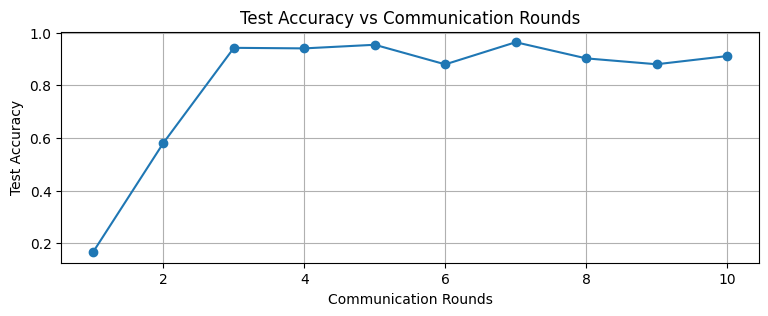

In [ ]:
def plot_accuracy_vs_rounds():
    if test_accuracies:
        plt.figure(figsize=(9,3))
        plt.plot(range(1, len(test_accuracies) + 1), test_accuracies, marker='o', linestyle='-')
        plt.title('Test Accuracy vs Communication Rounds')
        plt.xlabel('Communication Rounds')
        plt.ylabel('Test Accuracy')
        plt.grid(True)
        plt.savefig('accuracy_vs_rounds.png')
        plt.show()
    else:
        print("No accuracy data collected to plot.")

plot_accuracy_vs_rounds()